In [384]:
%matplotlib inline
import signac
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path
from itertools import product
import pandas as pd
import json
from copy import deepcopy
sns.set(context="notebook", style="whitegrid",font_scale=1.2)

sys.path.insert(0,'./scripts/')
from utils.colormap import get_energyCmap

cmap = plt.get_cmap('viridis_r')

In [385]:
# base = './results/scripts_all_5/'
# base = './results/scripts_ri_sph_2/'
fn_projects = {
    'ri':base+'radial_integral',
    'sph':base+'spherical_harmonics',
    'se':base+'spherical_expansion',
    'si':base+'spherical_invariants',
}
# fn_projects = {
#     'si':'./results/si_split/',
# }

In [386]:
# import signac

# base = './results/scripts_all_2/'
# fn_projects = {
#     'ri':base+'radial_integral',
#     'sph':base+'spherical_harmonics',
#     'se':base+'spherical_expansion',
#     'si':base+'spherical_invariants',
#     'mod':base+'model',
# }

# for k,fn_proj in fn_projects.items():
#     print(k, '###########')
#     project = signac.get_project(fn_proj)
#     names = set()
#     for job in project:
#         if len(job.document) < 1:
#             names.add(job.sp.name)
#     print(names)

In [387]:
queries = {}
dfs = {}

In [388]:
names = [
    'qm9',
    'molecular_crystals',
    'silicon_bulk',
    'methane_liquid',
    'methane_sulfonic'
]
radial_basis = ['GTO','DVR','GTO Spline','DVR Spline']
grads = [True, False]

fpfx = 'figures/v5/'

In [389]:
# for pp in fn_projects:
#     aa = fpfx+pp
#     !mkdir $aa

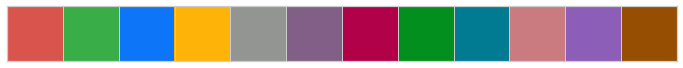

In [390]:
colors = ["pale red","medium green",
          "deep sky blue", "amber", "grey",  "dusty purple",
          "raspberry","emerald green","ocean","dirty pink",
         "deep lavender","warm brown"]
palette = sns.xkcd_palette(colors)
sns.palplot(palette)

In [391]:
def format_contour(data,x,y,z,title_values):
    df = data.pivot_table(index=y, columns=x, values=z)
    df = df.sort_index('index',ascending=False) 
    ax = sns.heatmap(df,cmap=cmap,square=True, cbar_kws={'label': z})
    title = ' / '.join([k+':'+str(data.iloc[0][k]) for k in title_values])
    ax.set_title(title,pad=20)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    return ax

from matplotlib.colors import Normalize,LogNorm
from matplotlib.ticker import LogFormatter , LogFormatterExponent

import matplotlib.cm as cm
def plot_contour(df, x, y, values , row, col, **kwargs):
    
    colorscale = 'linear'
    if 'colorscale' in kwargs:
        colorscale = kwargs.pop('colorscale')
    ticks = []
    if 'ticks' in kwargs:
        ticks = kwargs.pop('ticks')
    aa = deepcopy(ticks)
    aa.extend(df[values])
    vmin=np.min(aa)
    vmax=np.max(aa)
    print(vmin,vmax)
    
    norm = Normalize(vmin=vmin, vmax=vmax)    
    if colorscale == 'log':
        norm = LogNorm(vmin=vmin, vmax=vmax)
        
    g = sns.FacetGrid(df, col=col, row=row, height=5, dropna=False, **kwargs)
    g.map_dataframe(draw_heatmap, x, y, values, cmap=cmap, square=True, cbar=False,
                    norm=norm,vmin=vmin, vmax=vmax)
    fig = g.fig
    fig.tight_layout(h_pad=1.5, w_pad=1.5)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.9, 0.17, 0.05, 0.7])
    # formatter = LogFormatter(10, labelOnlyBase=False) 
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label=values)
    if ticks:
        cb.set_ticks(ticks)
        cb.set_ticklabels(ticks)
        cb.ax.minorticks_off()
        cb.update_ticks()
    return g

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    d = d.sort_index('index',ascending=False) 
    sns.heatmap(d, **kwargs)
    
def plot_lines(df, x, y, hue , row, col, **kwargs):
    g = sns.lmplot(data=df, x='$n_{max}$', hue='$\ell_{max}$', y='timing [$\mu sec/N_{neighbor}$]',
                height=5, palette=palette, col=col, row=row,**kwargs)
    return g

In [392]:

def plot_contour_comp(df_, x, y, values,A,B,tag, row, col, right=0.9, **kwargs):
    df1 = df_[df_[tag] == A].pivot_table(index=y,columns=x,values=values)
    df2 = df_[df_[tag] == B].pivot_table(index=y,columns=x,values=values)
    df = 100*(df2 / df1)
    
    vmin=df.to_numpy().min()
    vmax=df.to_numpy().max()
    datasets = list(np.unique(df_[col]))
    g = sns.FacetGrid(df_, col=col, row=row, height=5,col_order=datasets, **kwargs)
    g.map_dataframe(comparison_heatmap, x, y, values,A,B,tag, cmap=cmap, square=True, cbar=False,
                    vmin=vmin, vmax=vmax)
    fig = g.fig
    fig.tight_layout(h_pad=1.5, w_pad=1.5)
    fig.subplots_adjust(right=right)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
    norm = Normalize(vmin=vmin, vmax=vmax)
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label= 'Computational Gain [%]')
    return g


    
def comparison_heatmap(*args, **kwargs):
    df_ = kwargs.pop('data')
    df1 = df_[df_[args[5]] == args[3]].pivot_table(index=args[1],columns=args[0],values=args[2])
    df2 = df_[df_[args[5]] == args[4]].pivot_table(index=args[1],columns=args[0],values=args[2])
    df = 100*(df2 / df1)
    df = df.sort_index('index',ascending=False) 
    ax = sns.heatmap(df, **kwargs)
    

# radial_integral

In [47]:
names = [
    'qm9','molecular_crystals',
    'silicon_bulk',
]

## Radial integral $n_{max}\;vs\;l_{max}$

In [26]:
# label = 'Radial integral $n_{max}\;vs\;l_{max}$'
# queries[label] = []

# rc = 4
# accuracy = 1e-8
# radial_basis_args = {
#     'GTO' : {'representation.optimization_args.type':{'$exists':False},
#              'representation.radial_basis':'GTO'},
#     'DVR' : {'representation.optimization_args.type':{'$exists':False},
#              'representation.radial_basis':'DVR'},
#     'GTO Spline' : {'representation.optimization_args.type':{'$exists':True},
#                     'representation.optimization_args.accuracy': {'$eq':accuracy},
#                     'representation.radial_basis':'GTO'
#                    },
#     'DVR Spline' : {'representation.optimization_args.type':{'$exists':True},
#                     'representation.optimization_args.accuracy': {'$eq':accuracy},
#                     'representation.radial_basis':'DVR'
#                    },
# }


# for name, grad, rb in product(names, grads, radial_basis):
#     qry = { 'name':name, 'grad':grad, 'type':rb,
#         'query':{
#             'name':name,
#             'representation.compute_gradients':grad,
#             'representation.radial_basis':rb.replace(' Spline',''),
#             'representation.interaction_cutoff': {'$eq':rc}
#         }
#     }
#     qry['query'].update(**radial_basis_args[rb])
#     queries[label].append(qry)

# dfs[label] = []
# project = signac.get_project(fn_projects['ri'])
# for qry in queries[label]:
    # results = []
    # for job in project.find_jobs(qry['query']):
    #     res = {
    #         '$\ell_{max}$':job.sp.representation.max_angular, 
    #         '$n_{max}$':job.sp.representation.max_radial,
    #         'radial basis':qry['type'], 
    #         'compute grad':qry['grad'],
    #         'Dataset': qry['name'], 
    #         '$\sigma$': job.sp.representation.gaussian_sigma_constant
    #     }
    #     res.update(**job.document)
    #     res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
    #     res['memory footprint [MiB]'] = res['mem_max']
    #     results.append(res)
    # dfs[label].append(pd.DataFrame(results))

In [48]:
project = signac.get_project(fn_projects['ri'])
results = []
qry = {'representation.interaction_cutoff': {'$eq':4},
       # 'representation.compute_gradients':True,
       '$or': [
           {'representation.optimization_args.accuracy': {'$eq':1e-8}},
           {'representation.optimization_args.accuracy': {'$exists':False}}
       ],
      }
          
for job in project.find_jobs(qry):
    radial_basis = job.sp.representation.radial_basis
    Radial_Basis = job.sp.representation.radial_basis
    typ = 'Normal'
    
    if 'type' in job.sp.representation.optimization_args:
        radial_basis += ' Spline'
        
        typ = 'Spline'
        if 'DVR' in radial_basis and job.sp.representation.optimization_args['range'][0] < 1e-6:
            continue
    res = {
        '$l_{max}$':job.sp.representation.max_angular, 
        '$n_{max}$':job.sp.representation.max_radial,
        'radial basis':radial_basis, 
        'Radial Basis':Radial_Basis, 
        'type':typ,
        'compute grad':job.sp.representation.compute_gradients,
        'Dataset': job.sp.name, 
        '$\sigma$': job.sp.representation.gaussian_sigma_constant,
        'id':job.id,
    }
    
    res.update(**job.document)
    res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
    res['memory footprint [MiB]'] = res['mem_max']
    results.append(res)
df = pd.DataFrame(results)

molecular_crystals False
0.0992878530315336 8.0


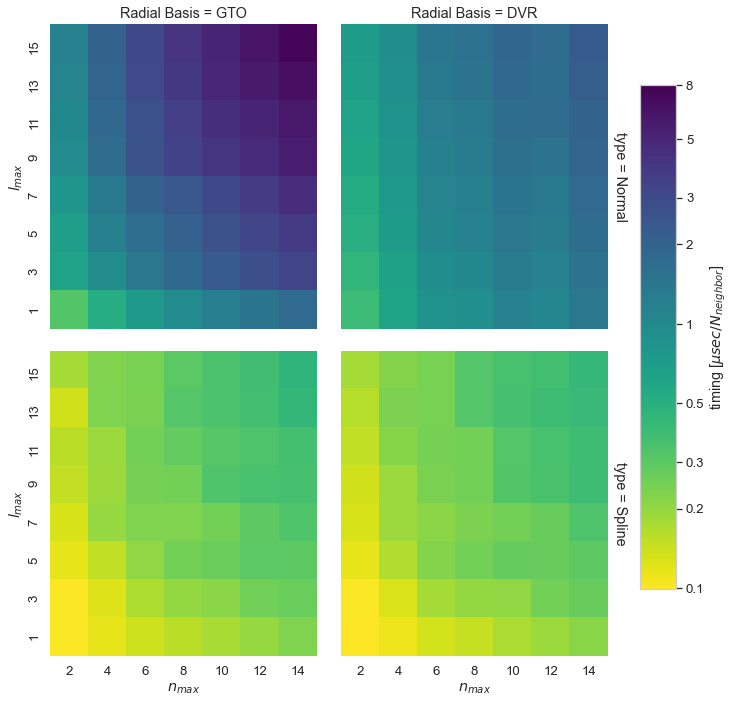

molecular_crystals True
0.09950374554186237 8.0


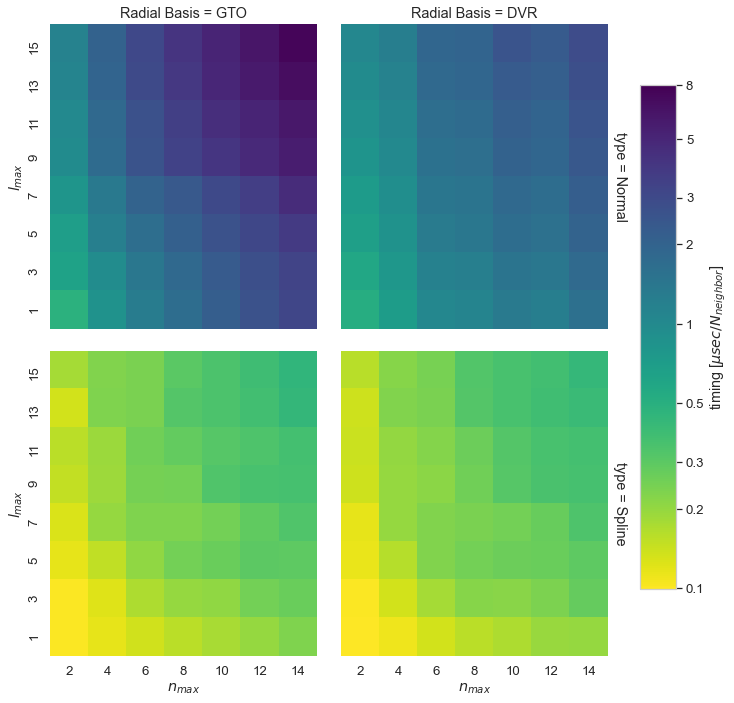

qm9 False
0.1 8.0


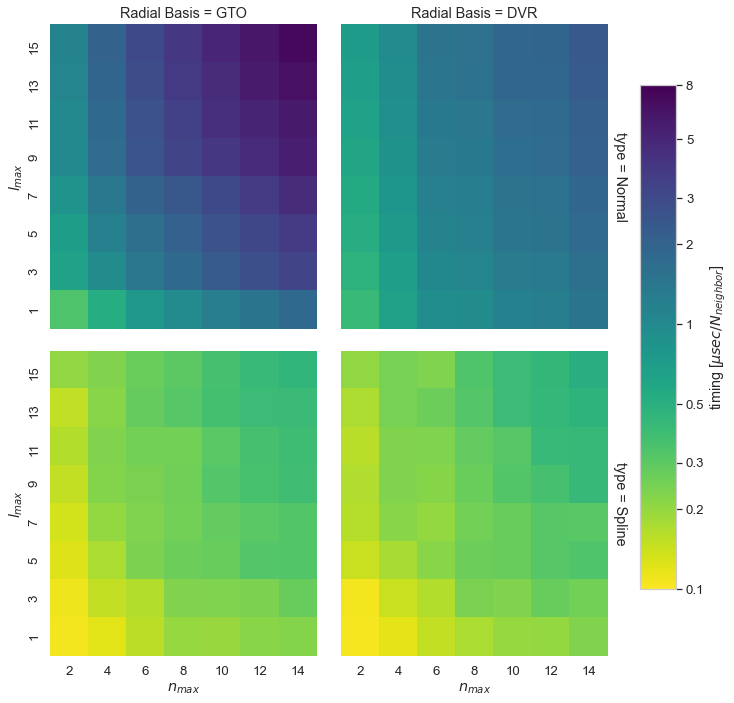

qm9 True
0.1 8.0


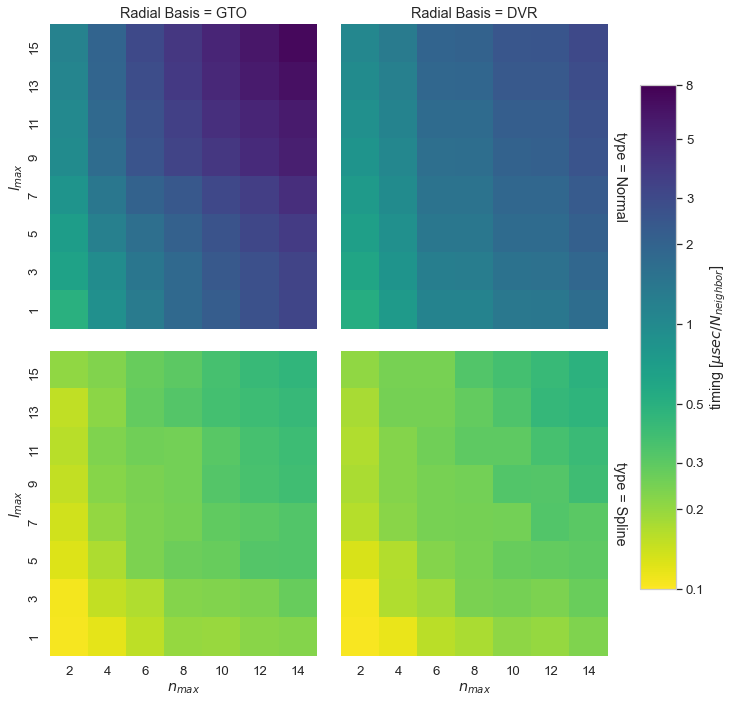

silicon_bulk False
0.1 8.0


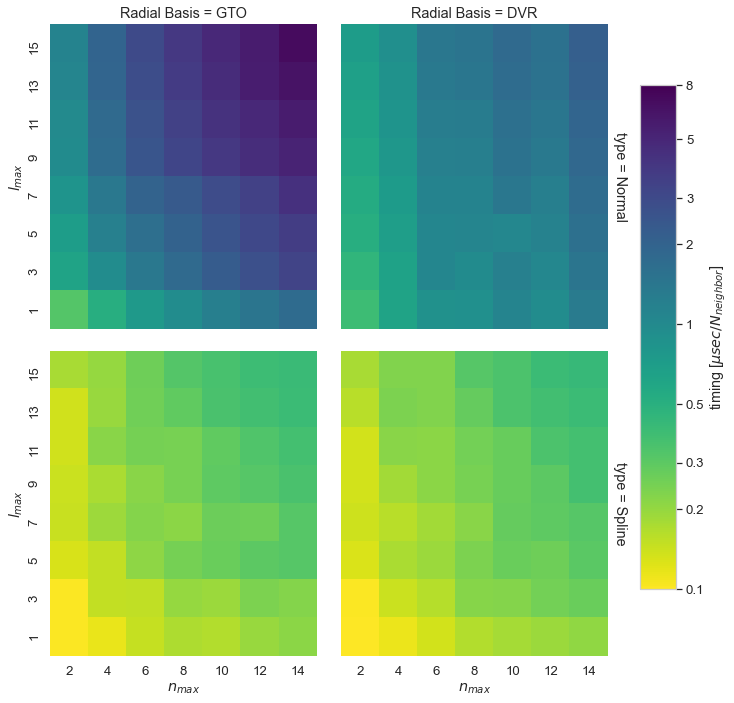

silicon_bulk True
0.1 8.0


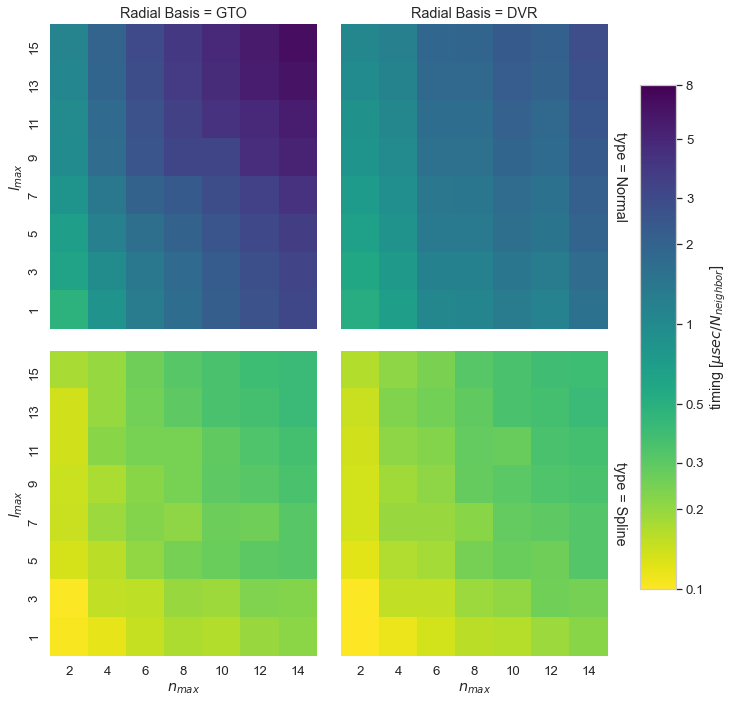

In [49]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True,
              colorscale='log',ticks=[0.1,0.2,0.3,0.5,1,2,3,5,8],
             row_order=['Normal','Spline'],col_order=['GTO','DVR'])
for (dataset,compute_grad), df1 in df.groupby(['Dataset','compute grad']):
    print(dataset,compute_grad)
    g = plot_contour(df1,x='$n_{max}$',y='$l_{max}$', values='timing [$\mu sec/N_{neighbor}$]', 
                               row='type',col='Radial Basis',**kwargs)
    
    fname = 'ri/ri-comparison-{}-{}.png'.format(dataset,compute_grad)
    #plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()
    

molecular_crystals False
0.06714378420848194 8.0


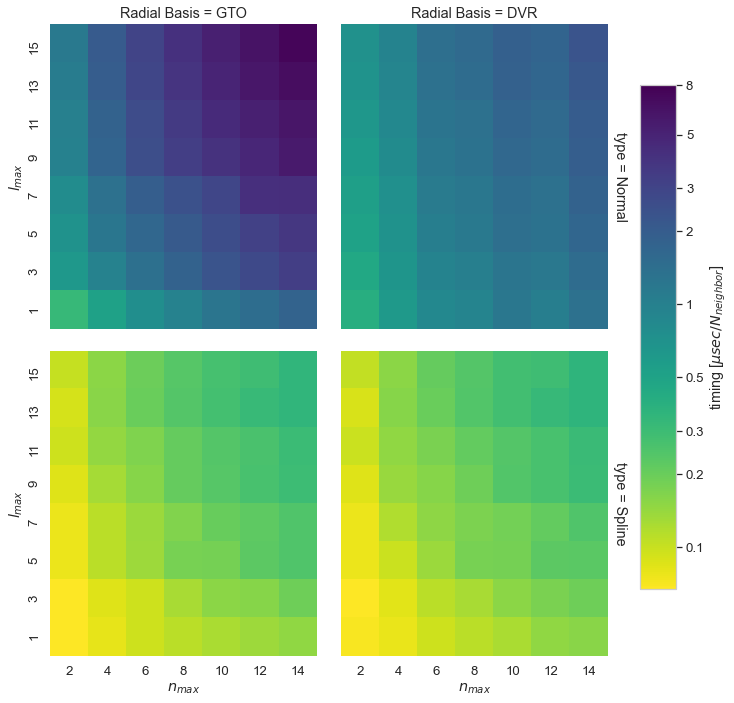

molecular_crystals True
0.06703636392527984 8.0


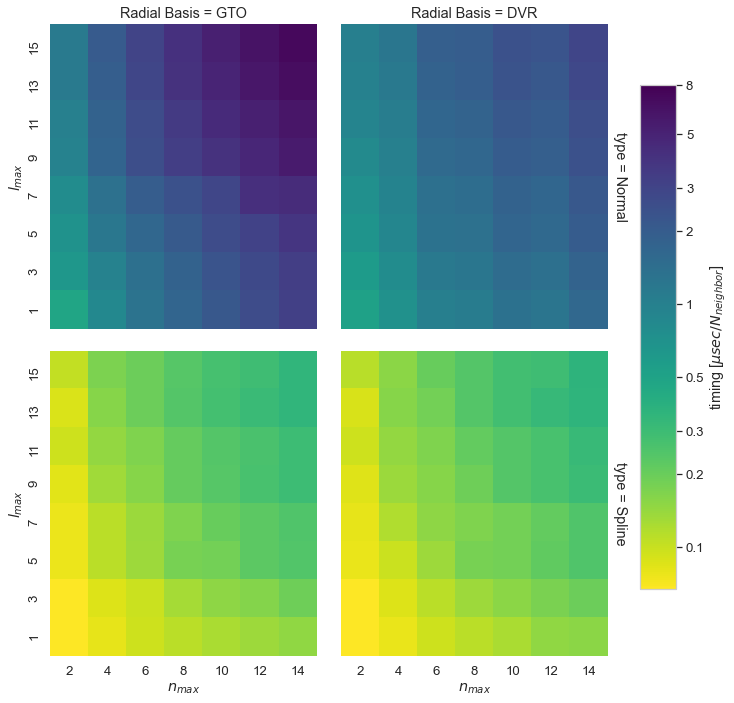

qm9 False
0.07271767008924288 8.0


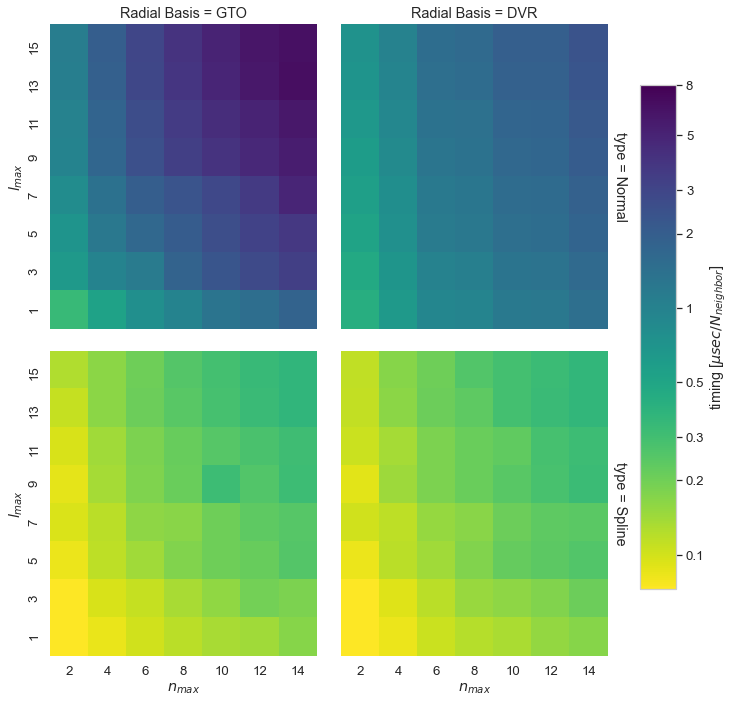

qm9 True
0.07177491205436315 8.0


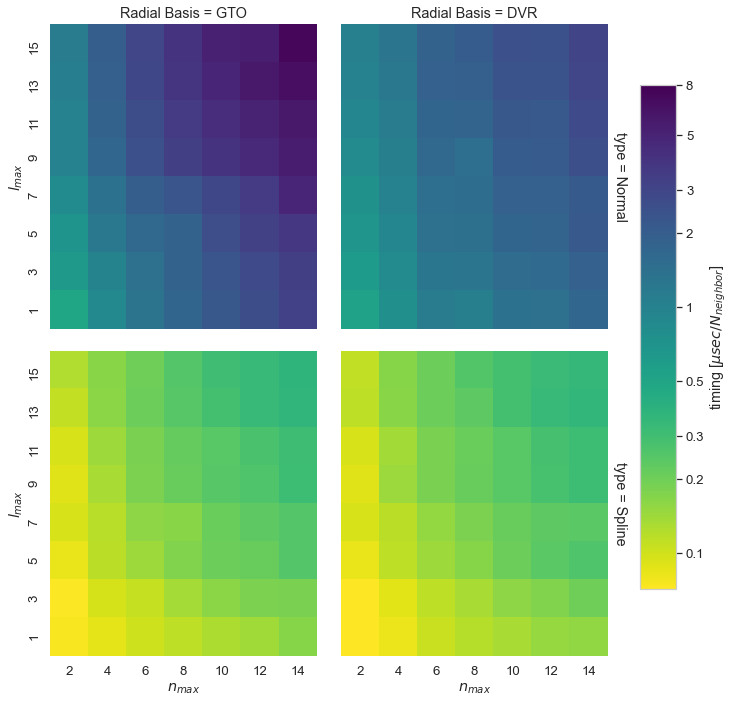

silicon_bulk False
0.06896871070309002 8.0


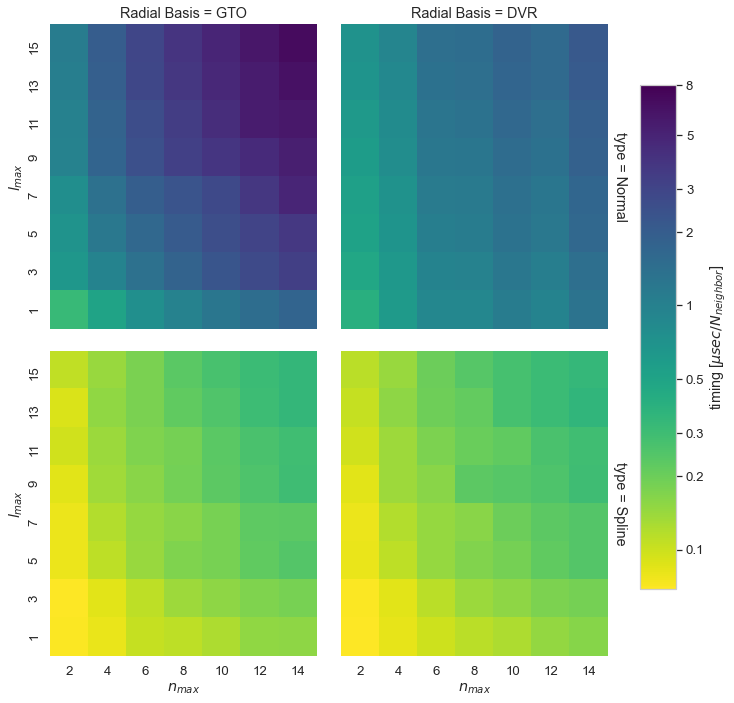

silicon_bulk True
0.06928518226600985 8.0


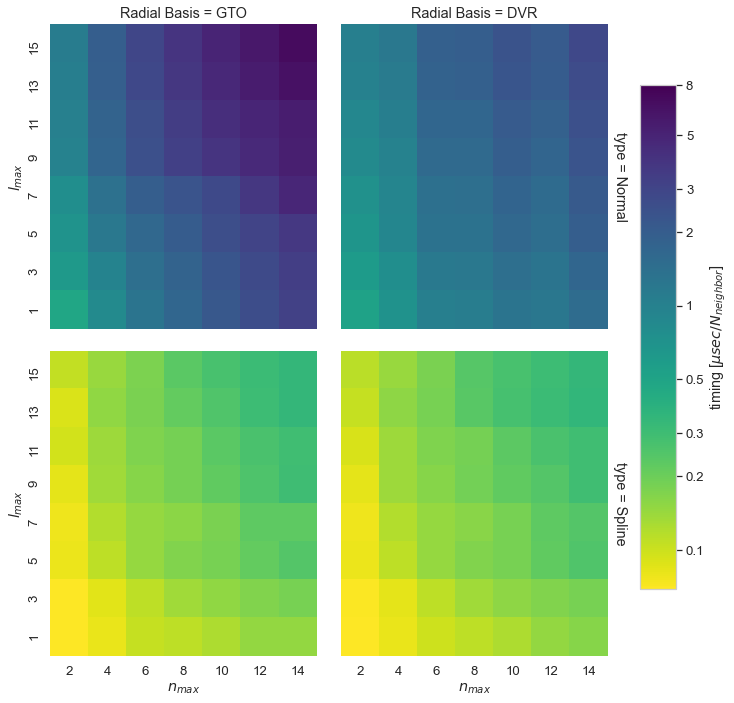

In [14]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True,
              colorscale='log',ticks=[0.1,0.2,0.3,0.5,1,2,3,5,8],
             row_order=['Normal','Spline'],col_order=['GTO','DVR'])
for (dataset,compute_grad), df1 in df.groupby(['Dataset','compute grad']):
    print(dataset,compute_grad)
    g = plot_contour(df1,x='$n_{max}$',y='$l_{max}$', values='timing [$\mu sec/N_{neighbor}$]', 
                               row='type',col='Radial Basis',**kwargs)
    
    fname = 'ri/ri-comparison-{}-{}.png'.format(dataset,compute_grad)
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()
    

molecular_crystals
0.3580299939969632 7.9225278735124816
('$n_{max}$', '$\\ell_{max}$', 'timing [$\\mu sec/N_{neighbor}$]') [[1 12 'GTO' False 'molecular_crystals' 0.3 0.16487064998
  0.0006109750954127591 4174 113276 'seconds' 36.4609375 'MiB'
  1.45547732953141 36.4609375]
 [1 2 'GTO' False 'molecular_crystals' 0.3 0.040556205600000006
  0.0002195047193333023 4174 113276 'seconds' 36.34375 'MiB'
  0.3580299939969632 36.34375]
 [5 8 'GTO' False 'molecular_crystals' 0.3 0.2443371613
  0.0006046404611019688 4174 113276 'seconds' 36.40625 'MiB'
  2.1570073210565344 36.40625]
 [1 14 'GTO' False 'molecular_crystals' 0.3 0.19781636836
  0.0005183433134890102 4174 113276 'seconds' 36.40234375 'MiB'
  1.7463219778240757 36.40234375]
 [9 2 'GTO' False 'molecular_crystals' 0.3 0.12755711196000002
  0.00034761342417333175 4174 113276 'seconds' 36.359375 'MiB'
  1.1260735898160248 36.359375]
 [11 2 'GTO' False 'molecular_crystals' 0.3 0.13661424453999998
  0.00034253201808627184 4174 113276 'seco

('$n_{max}$', '$\\ell_{max}$', 'timing [$\\mu sec/N_{neighbor}$]') [[13 8 'GTO' True 'molecular_crystals' 0.3 0.4703308857400001
  0.001154228923501835 4174 113276 'seconds' 36.40625 'MiB'
  4.15207886701508 36.40625]
 [3 4 'GTO' True 'molecular_crystals' 0.3 0.11645718811999999
  0.00039294599260731537 4174 113276 'seconds' 36.390625 'MiB'
  1.0280835138952646 36.390625]
 [5 6 'GTO' True 'molecular_crystals' 0.3 0.19484135893999993
  0.00046764977795622493 4174 113276 'seconds' 36.3984375 'MiB'
  1.720058608531374 36.3984375]
 [1 12 'GTO' True 'molecular_crystals' 0.3 0.29973348702
  0.000770319973525752 4174 113276 'seconds' 36.40625 'MiB'
  2.6460458263003637 36.40625]
 [1 8 'GTO' True 'molecular_crystals' 0.3 0.19496747384
  0.0010534320975717334 4174 113276 'seconds' 36.40234375 'MiB'
  1.7211719502807301 36.40234375]
 [15 4 'GTO' True 'molecular_crystals' 0.3 0.25391085589999995
  0.0006548310278855454 4174 113276 'seconds' 36.43359375 'MiB'
  2.2415238523606056 36.43359375]
 [9 

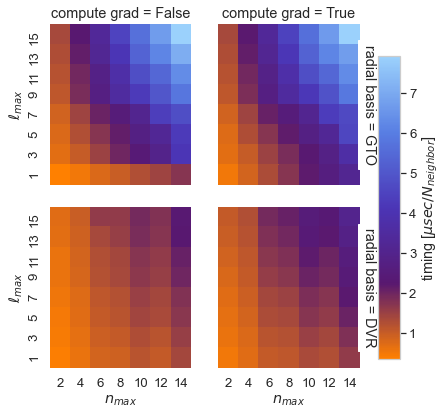

qm9
0.374232855594295 7.719680778627203
('$n_{max}$', '$\\ell_{max}$', 'timing [$\\mu sec/N_{neighbor}$]') [[13 4 'GTO' False 'qm9' 0.3 1.18955446368 0.008938792256358854 44975
  562734 'seconds' 116.28125 'MiB' 2.113884115194746 116.28125]
 [9 8 'GTO' False 'qm9' 0.3 1.94913509474 0.009050234560100144 44975
  562734 'seconds' 116.296875 'MiB' 3.463688163039731 116.296875]
 [5 6 'GTO' False 'qm9' 0.3 0.9653801053800001 0.006237656531542057 44975
  562734 'seconds' 116.29296875 'MiB' 1.7155176431137982 116.29296875]
 [7 14 'GTO' False 'qm9' 0.3 2.8766054936199996 0.01320354730336815 44975
  562734 'seconds' 116.296875 'MiB' 5.111838797051537 116.296875]
 [3 8 'GTO' False 'qm9' 0.3 1.05261246658 0.010776064129370764 44975
  562734 'seconds' 116.296875 'MiB' 1.8705329100072148 116.296875]
 [15 14 'GTO' False 'qm9' 0.3 4.31231232914 0.009978312103825255 44975
  562734 'seconds' 116.30078125 'MiB' 7.663145161195165 116.30078125]
 [7 4 'GTO' False 'qm9' 0.3 0.8435761461599998 0.0071615486463

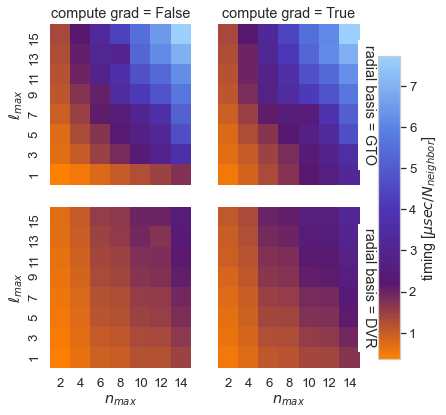

silicon_bulk
0.3554733925959098 7.3615951992834745
('$n_{max}$', '$\\ell_{max}$', 'timing [$\\mu sec/N_{neighbor}$]') [[13 6 'DVR' False 'silicon_bulk' 0.3 0.18558686790000004
  0.0012633842278674116 8508 133980 'seconds' 179.36328125 'MiB'
  1.3851833699059564 179.36328125]
 [5 10 'DVR' False 'silicon_bulk' 0.3 0.18088807328 0.0009502297955365484
  8508 133980 'seconds' 179.36328125 'MiB' 1.3501125039558144
  179.36328125]
 [1 14 'DVR' False 'silicon_bulk' 0.3 0.17582988844000003
  0.0009881428355176735 8508 133980 'seconds' 179.36328125 'MiB'
  1.312359221077773 179.36328125]
 [3 2 'DVR' False 'silicon_bulk' 0.3 0.060615593819999994
  0.000536425942150212 8508 133980 'seconds' 179.36328125 'MiB'
  0.4524227035378414 179.36328125]
 [3 8 'DVR' False 'silicon_bulk' 0.3 0.1322863936 0.0008698798532508249
  8508 133980 'seconds' 179.36328125 'MiB' 0.9873592595909838
  179.36328125]
 [13 8 'DVR' False 'silicon_bulk' 0.3 0.19877215666 0.0011717819178819278
  8508 133980 'seconds' 179.359375

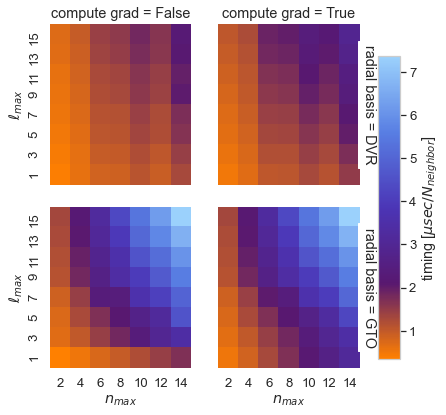

molecular_crystals
0.09940438857304286 0.9666471900490836
('$n_{max}$', '$\\ell_{max}$', 'timing [$\\mu sec/N_{neighbor}$]') [[9 8 'GTO Spline' False 'molecular_crystals' 0.3 0.049019664360000006
  0.00021805004469792208 4174 113276 'seconds' 37.5546875 'MiB'
  0.4327453684805255 37.5546875]
 [11 4 'GTO Spline' False 'molecular_crystals' 0.3 0.034349382459999994
  7.46927743201521e-05 4174 113276 'seconds' 36.3984375 'MiB'
  0.30323618824817256 36.3984375]
 [3 4 'GTO Spline' False 'molecular_crystals' 0.3 0.0214860199
  6.587774109798739e-05 4174 113276 'seconds' 36.39453125 'MiB'
  0.18967848352696068 36.39453125]
 [5 8 'GTO Spline' False 'molecular_crystals' 0.3 0.0420237618
  0.0003007604371296332 4174 113276 'seconds' 37.32421875 'MiB'
  0.37098557329001725 37.32421875]
 [9 10 'GTO Spline' False 'molecular_crystals' 0.3 0.05528321394
  0.0003425575484568867 4174 113276 'seconds' 39.8046875 'MiB'
  0.4880399549772238 39.8046875]
 [7 6 'GTO Spline' False 'molecular_crystals' 0.3 0.03

('$n_{max}$', '$\\ell_{max}$', 'timing [$\\mu sec/N_{neighbor}$]') [[9 8 'GTO Spline' True 'molecular_crystals' 0.3 0.04853330670000001
  0.0009543668231587328 4174 113276 'seconds' 37.5546875 'MiB'
  0.42845180532504684 37.5546875]
 [1 6 'GTO Spline' True 'molecular_crystals' 0.3 0.02178412848
  5.150878088535523e-05 4174 113276 'seconds' 36.39453125 'MiB'
  0.19231018468166253 36.39453125]
 [15 8 'GTO Spline' True 'molecular_crystals' 0.3 0.06213412359999999
  0.00023509711880551109 4174 113276 'seconds' 38.97265625 'MiB'
  0.54851975352237 38.97265625]
 [11 2 'GTO Spline' True 'molecular_crystals' 0.3 0.024559436219999998
  0.00033016346338395075 4174 113276 'seconds' 36.39453125 'MiB'
  0.21681058847416929 36.39453125]
 [11 6 'GTO Spline' True 'molecular_crystals' 0.3 0.040996352900000005
  0.00027124873839144215 4174 113276 'seconds' 37.55859375 'MiB'
  0.3619156123097568 37.55859375]
 [5 8 'GTO Spline' True 'molecular_crystals' 0.3 0.0420879363
  0.00030800271731310267 4174 11327

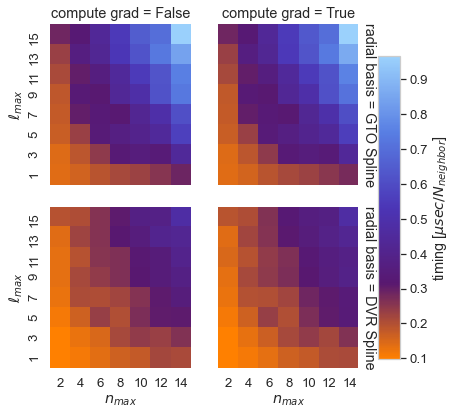

qm9
0.1059394186596154 0.8570899225211202
('$n_{max}$', '$\\ell_{max}$', 'timing [$\\mu sec/N_{neighbor}$]') [[13 8 'DVR Spline' False 'qm9' 0.3 0.15491112816000002
  0.010564242663778381 44975 562734 'seconds' 116.2734375 'MiB'
  0.2752830434272676 116.2734375]
 [15 10 'DVR Spline' False 'qm9' 0.3 0.22132128556000003
  0.0066360048931252014 44975 562734 'seconds' 116.27734375 'MiB'
  0.39329645189379 116.27734375]
 [3 14 'DVR Spline' False 'qm9' 0.3 0.16636844476 0.004500838672936564
  44975 562734 'seconds' 116.27734375 'MiB' 0.29564313647300505
  116.27734375]
 [5 6 'DVR Spline' False 'qm9' 0.3 0.1271616033 0.004087009031146437
  44975 562734 'seconds' 116.27734375 'MiB' 0.22597106856880872
  116.27734375]
 [13 10 'DVR Spline' False 'qm9' 0.3 0.21544492528 0.004340066360679322
  44975 562734 'seconds' 116.27734375 'MiB' 0.382853933261541
  116.27734375]
 [7 12 'DVR Spline' False 'qm9' 0.3 0.17052847961999998
  0.012194303534029973 44975 562734 'seconds' 116.3046875 'MiB'
  0.3030356

('$n_{max}$', '$\\ell_{max}$', 'timing [$\\mu sec/N_{neighbor}$]') [[11 6 'DVR Spline' True 'qm9' 0.3 0.15051735755999998
  0.005146065794703119 44975 562734 'seconds' 116.28125 'MiB'
  0.2674751437801874 116.28125]
 [7 12 'DVR Spline' True 'qm9' 0.3 0.16478218644 0.012673979566583058
  44975 562734 'seconds' 116.30859375 'MiB' 0.2928242943202295
  116.30859375]
 [1 12 'DVR Spline' True 'qm9' 0.3 0.1156892414 0.0036448071604947047
  44975 562734 'seconds' 116.30859375 'MiB' 0.20558423944527965
  116.30859375]
 [9 2 'DVR Spline' True 'qm9' 0.3 0.08610514578 0.003305257691533796
  44975 562734 'seconds' 116.28515625 'MiB' 0.15301216166074913
  116.28515625]
 [5 6 'DVR Spline' True 'qm9' 0.3 0.12850506284000002
  0.012205620981383477 44975 562734 'seconds' 116.28125 'MiB'
  0.22835844793454815 116.28125]
 [15 14 'DVR Spline' True 'qm9' 0.3 0.23810398649999998
  0.004392344548952798 44975 562734 'seconds' 116.28125 'MiB'
  0.4231199580974314 116.28125]
 [13 14 'DVR Spline' True 'qm9' 0.3 0

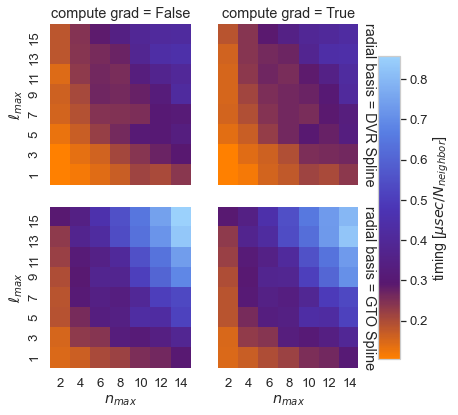

silicon_bulk
0.10077991282280936 0.7559723400507539
('$n_{max}$', '$\\ell_{max}$', 'timing [$\\mu sec/N_{neighbor}$]') [[15 8 'DVR Spline' False 'silicon_bulk' 0.3 0.04327807424000001
  0.000592797209359379 8508 133980 'seconds' 179.2734375 'MiB'
  0.32301891506194963 179.2734375]
 [3 14 'DVR Spline' False 'silicon_bulk' 0.3 0.03485799739999999
  0.0015954152780797497 8508 133980 'seconds' 179.26953125 'MiB'
  0.26017314076727865 179.26953125]
 [5 14 'DVR Spline' False 'silicon_bulk' 0.3 0.04112324568
  0.0004923387951524653 8508 133980 'seconds' 179.25390625 'MiB'
  0.30693570443349755 179.25390625]
 [7 6 'DVR Spline' False 'silicon_bulk' 0.3 0.02827063086
  0.0006021329766982285 8508 133980 'seconds' 179.26171875 'MiB'
  0.21100635064935067 179.26171875]
 [5 6 'DVR Spline' False 'silicon_bulk' 0.3 0.026694114960000005
  0.0004888813858680692 8508 133980 'seconds' 179.265625 'MiB'
  0.19923955038065388 179.265625]
 [3 6 'DVR Spline' False 'silicon_bulk' 0.3 0.022893444059999997
  0.00

('$n_{max}$', '$\\ell_{max}$', 'timing [$\\mu sec/N_{neighbor}$]') [[9 12 'DVR Spline' True 'silicon_bulk' 0.3 0.044272187899999996
  0.0005066391673537166 8508 133980 'seconds' 179.30859375 'MiB'
  0.3304387811613673 179.30859375]
 [3 4 'DVR Spline' True 'silicon_bulk' 0.3 0.01823399638
  0.001433216872317297 8508 133980 'seconds' 179.28125 'MiB'
  0.13609491252425734 179.28125]
 [5 14 'DVR Spline' True 'silicon_bulk' 0.3 0.04079186704
  0.0005704467002452479 8508 133980 'seconds' 179.26171875 'MiB'
  0.30446236035229135 179.26171875]
 [13 8 'DVR Spline' True 'silicon_bulk' 0.3 0.03922555146
  0.0006059690675037423 8508 133980 'seconds' 179.2734375 'MiB'
  0.2927716932377967 179.2734375]
 [7 14 'DVR Spline' True 'silicon_bulk' 0.3 0.04204275676
  0.00060357410758021 8508 133980 'seconds' 179.27734375 'MiB'
  0.3137987517539932 179.27734375]
 [3 10 'DVR Spline' True 'silicon_bulk' 0.3 0.027958852920000003
  0.000489115161045625 8508 133980 'seconds' 179.27734375 'MiB'
  0.2086793022839

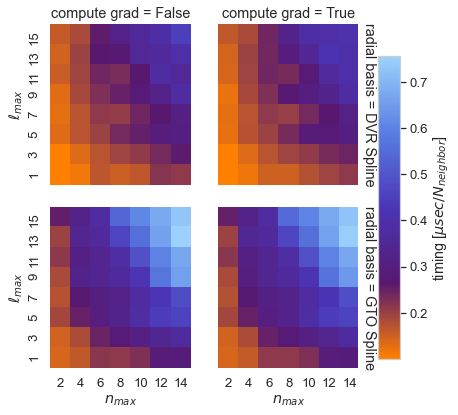

In [26]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
for dataset, df1 in df.query('`radial basis`=="GTO" or `radial basis`=="DVR"').groupby('Dataset'):
    print(dataset)
    
    g = plot_contour(df1,x='$n_{max}$',y='$\ell_{max}$', values='timing [$\mu sec/N_{neighbor}$]', 
                               row='radial basis',col='compute grad',**kwargs)
    
    fname = 'ri/ri-gto_vs_dvr-{}.png'.format(dataset)
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()
    
    
for dataset, df1 in df.query('`radial basis`=="GTO Spline" or `radial basis`=="DVR Spline"').groupby('Dataset'):
    print(dataset)
    
    g = plot_contour(df1,x='$n_{max}$',y='$\ell_{max}$', values='timing [$\mu sec/N_{neighbor}$]', 
                               row='radial basis',col='compute grad',**kwargs)
    
    fname = 'ri/ri-spline-{}.png'.format(dataset)
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()
    

In [15]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for dataset, df_ in df.groupby('Dataset'):
    df_ = df_[df_['compute grad'] == True]
    df1 = df_[df_['radial basis'] == 'GTO'].pivot_table(index=y,columns=x,values=z)
    df2 = df_[df_['radial basis'] == 'GTO Spline'].pivot_table(index=y,columns=x,values=z)
    dd = 100*(1-df2 / df1)
    ax = sns.heatmap(dd,cmap=cmap,square=True, cbar_kws={'label': 'Computational Gain [%]'})
    # title = 'Comparison between GTO and Splined GTO'
    # ax.set_title(title,pad=20)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fname = 'ri/ri-gto_cmp_spline-{}.png'.format(dataset)
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

for dataset, df_ in df.groupby('Dataset'):
    df_ = df_[df_['compute grad'] == True]
    df1 = df_[df_['radial basis'] == 'DVR'].pivot_table(index=y,columns=x,values=z)
    df2 = df_[df_['radial basis'] == 'DVR Spline'].pivot_table(index=y,columns=x,values=z)
    dd = 100*(1-df2 / df1)
    ax = sns.heatmap(dd,cmap=cmap,square=True, cbar_kws={'label': 'Computational Gain [%]'})
    # title = 'Comparison between DVR and Splined DVR'
    # ax.set_title(title,pad=20)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fname = 'ri/ri-dvr_cmp_spline-{}.png'.format(dataset)
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

for dataset, df_ in df.groupby('Dataset'):
    df_ = df_[df_['compute grad'] == True]
    df1 = df_[df_['radial basis'] == 'GTO'].pivot_table(index=y,columns=x,values=z)
    df2 = df_[df_['radial basis'] == 'DVR'].pivot_table(index=y,columns=x,values=z)
    dd = 100*(1-df2 / df1)
    ax = sns.heatmap(dd,cmap=cmap,square=True, cbar_kws={'label': 'Computational Gain [%]'})
    # title = 'Comparison between GTO and DVR'
    # ax.set_title(title,pad=20)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fname = 'ri/ri-gto_cmp_dvr-{}.png'.format(dataset)
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

KeyError: '$\\ell_{max}$'

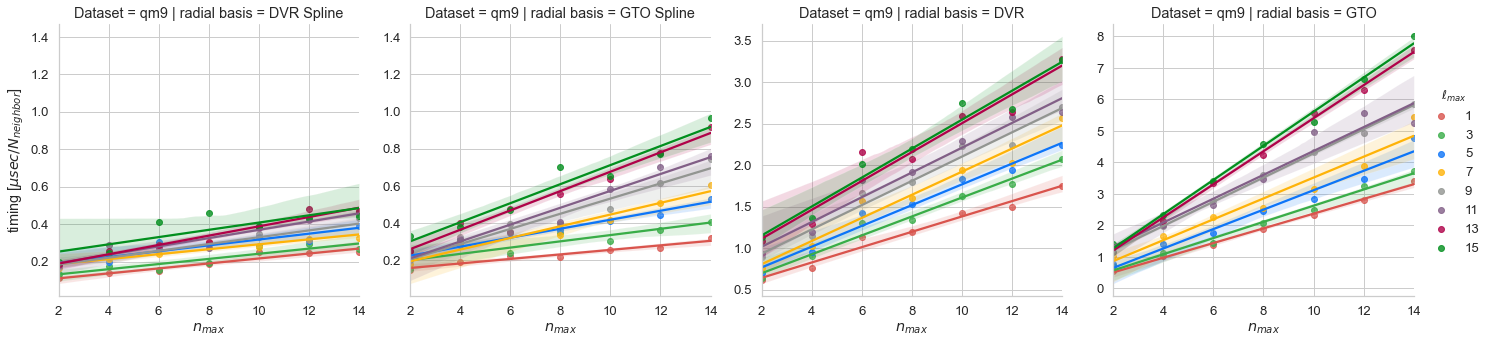

In [52]:
kwargs = dict(sharex=True, sharey=False)
g = plot_lines(df.query('`compute grad`==True'), 
           x='$n_{max}$', hue='$\ell_{max}$', y='timing [$\mu sec/N_{neighbor}$]', 
           col='radial basis',row='Dataset', **kwargs)
    

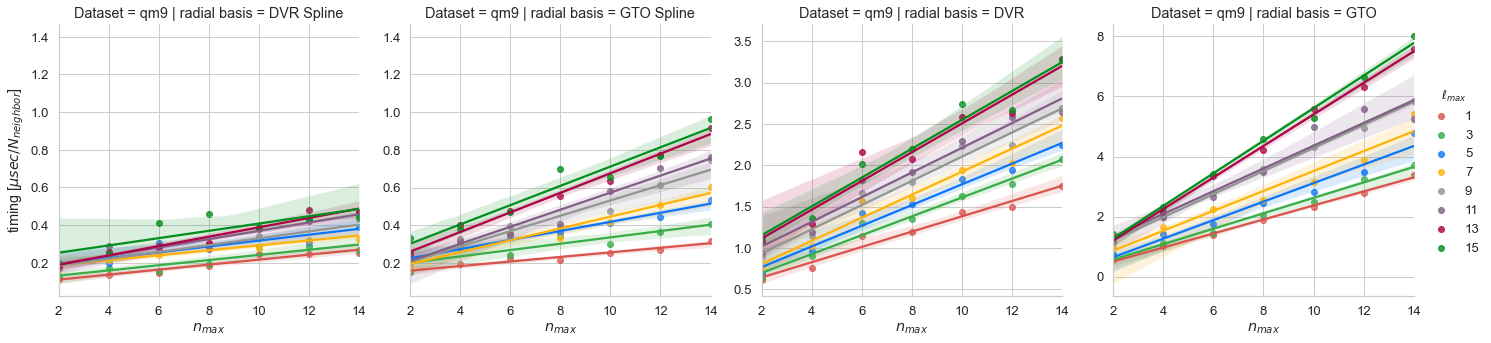

In [53]:
g = plot_lines(df.query('`compute grad`==True'), 
           hue='$n_{max}$', x='$\ell_{max}$', y='timing [$\mu sec/N_{neighbor}$]', 
           col='radial basis',row='Dataset', **kwargs)

molecular_crystals
36.3203125 37.59765625


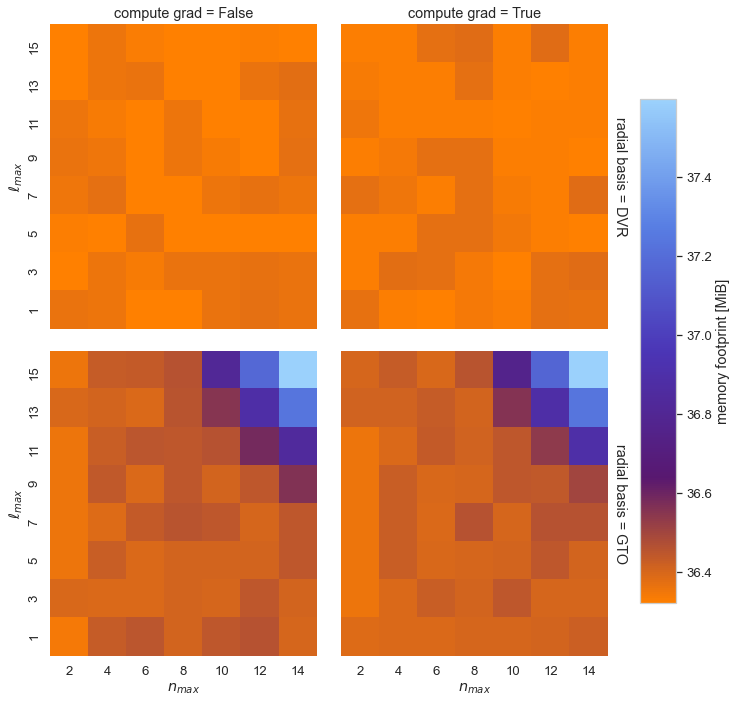

qm9
116.21875 116.30078125


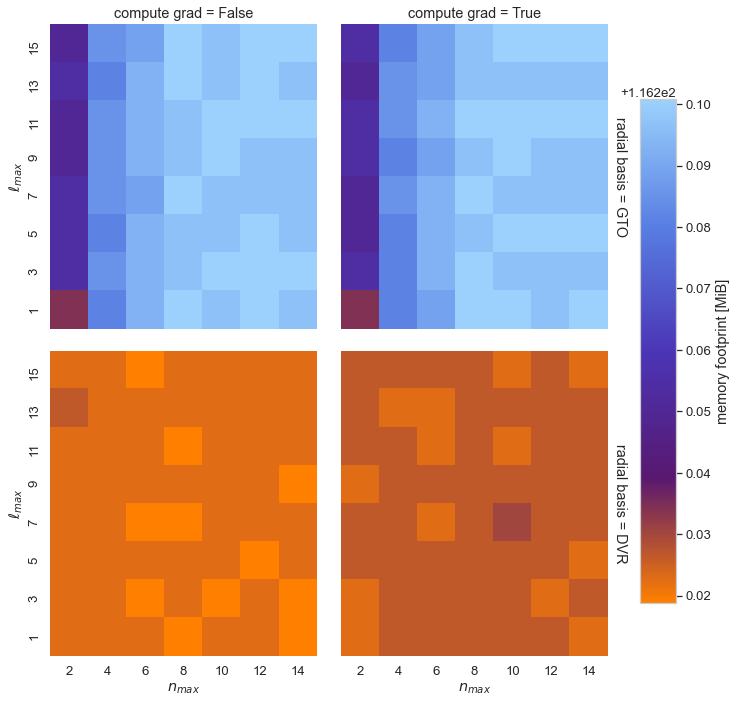

silicon_bulk
179.3515625 179.46484375


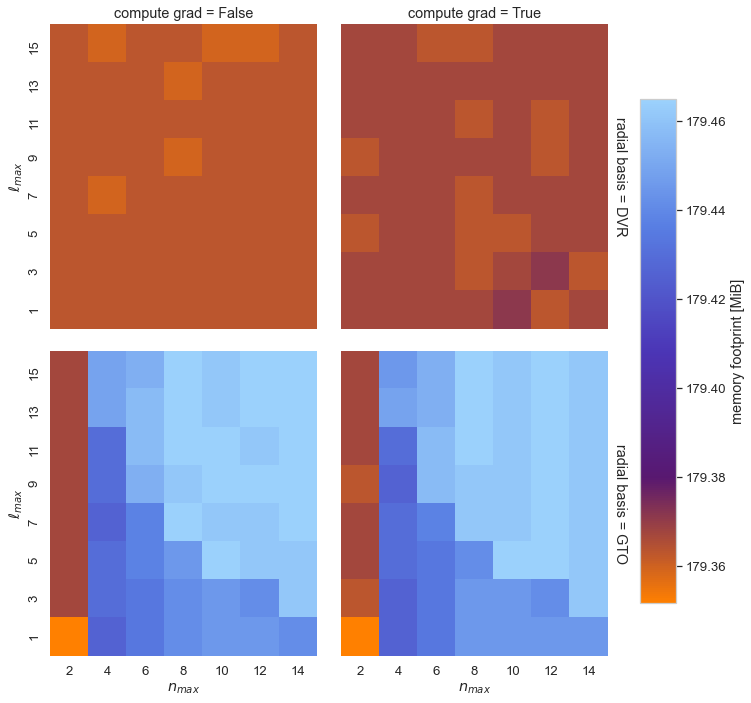

molecular_crystals
36.1328125 72.62109375


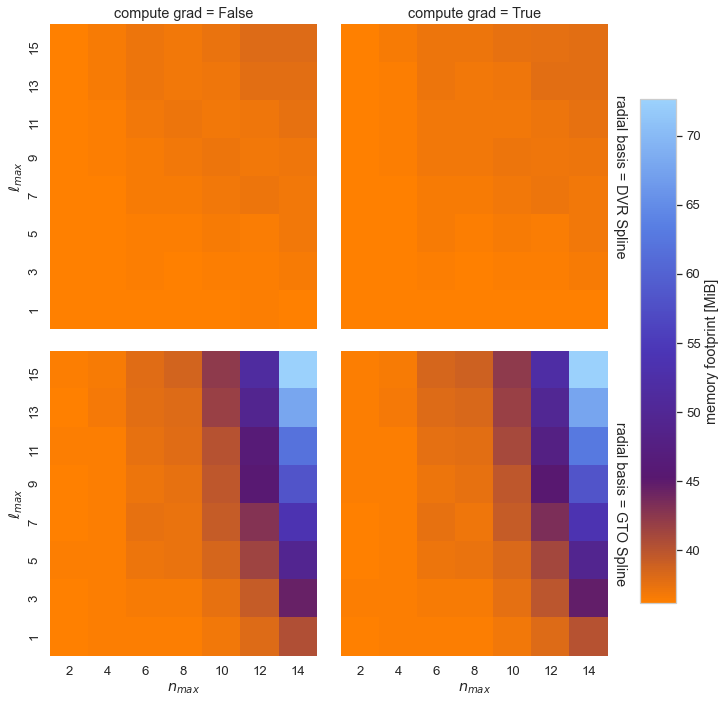

qm9
116.2734375 144.0


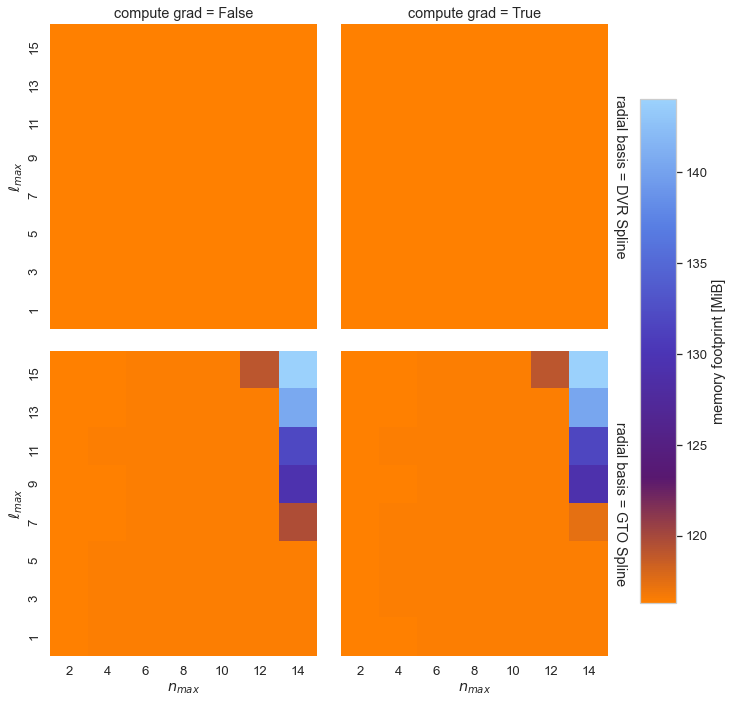

silicon_bulk
179.25 179.40234375


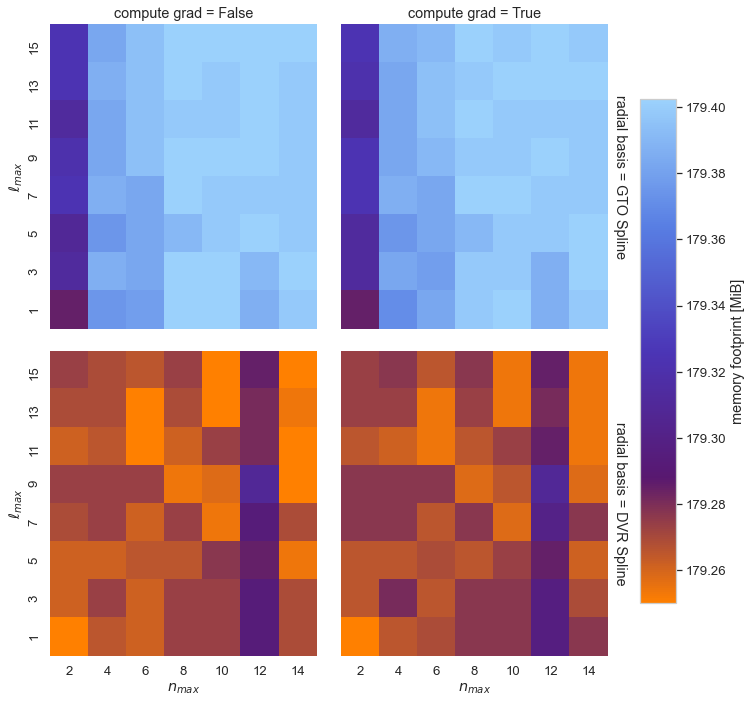

In [22]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
for dataset, df1 in df.query('`radial basis`=="GTO" or `radial basis`=="DVR"').groupby('Dataset'):
    print(dataset)
    
    g = plot_contour(df1,x='$n_{max}$',y='$\ell_{max}$', values='memory footprint [MiB]', 
                               row='radial basis',col='compute grad',**kwargs)
    
    plt.show()
for dataset, df1 in df.query('`radial basis`=="GTO Spline" or `radial basis`=="DVR Spline"').groupby('Dataset'):
    print(dataset)
    
    g = plot_contour(df1,x='$n_{max}$',y='$\ell_{max}$', values='memory footprint [MiB]', 
                               row='radial basis',col='compute grad',**kwargs)
    
    plt.show()

+ increasing n and l increases the computation cost linearly
+ computing the gradient has a marginal cost 
+ GTO is more expensive than DVR for $n_{max}>4$ and/or $l_{max}>4$
+ Spline reduce clearly the cost of GTO and DVR to comparable level
+ Splining increases the memory footprint

## Radial integral: Splining accuracy

In [28]:
project = signac.get_project(fn_projects['ri'])
results = []
qry = {'representation.interaction_cutoff': {'$eq':4},
       'representation.compute_gradients': {'$eq':True},
       'representation.optimization_args.accuracy': {'$exists': True},
      }
          
for job in project.find_jobs(qry):
    radial_basis = job.sp.representation.radial_basis + ' Spline'
    if 'DVR' in radial_basis and job.sp.representation.optimization_args['range'][0] < 1e-6:
        continue
    res = {
        '$\ell_{max}$':job.sp.representation.max_angular, 
        '$n_{max}$':job.sp.representation.max_radial,
        'radial basis':radial_basis, 
        'compute grad':job.sp.representation.compute_gradients,
        'Dataset': job.sp.name, 
        'accuracy':job.sp.representation.optimization_args.accuracy,
        'range':job.sp.representation.optimization_args.range,
        '$\ell_{max}$ / $n_{max}$': '{} / {}'.format(job.sp.representation.max_angular,
                                                         job.sp.representation.max_radial),
        '$\sigma$': job.sp.representation.gaussian_sigma_constant,
        # 'n_structures':job.sp.n_structures,
        # 'nl_type':job.sp.nl_type,
    }
    
    res.update(**job.document)
    res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
    res['memory footprint [MiB]'] = res['mem_max']
    results.append(res)
df = pd.DataFrame(results)

molecular_crystals


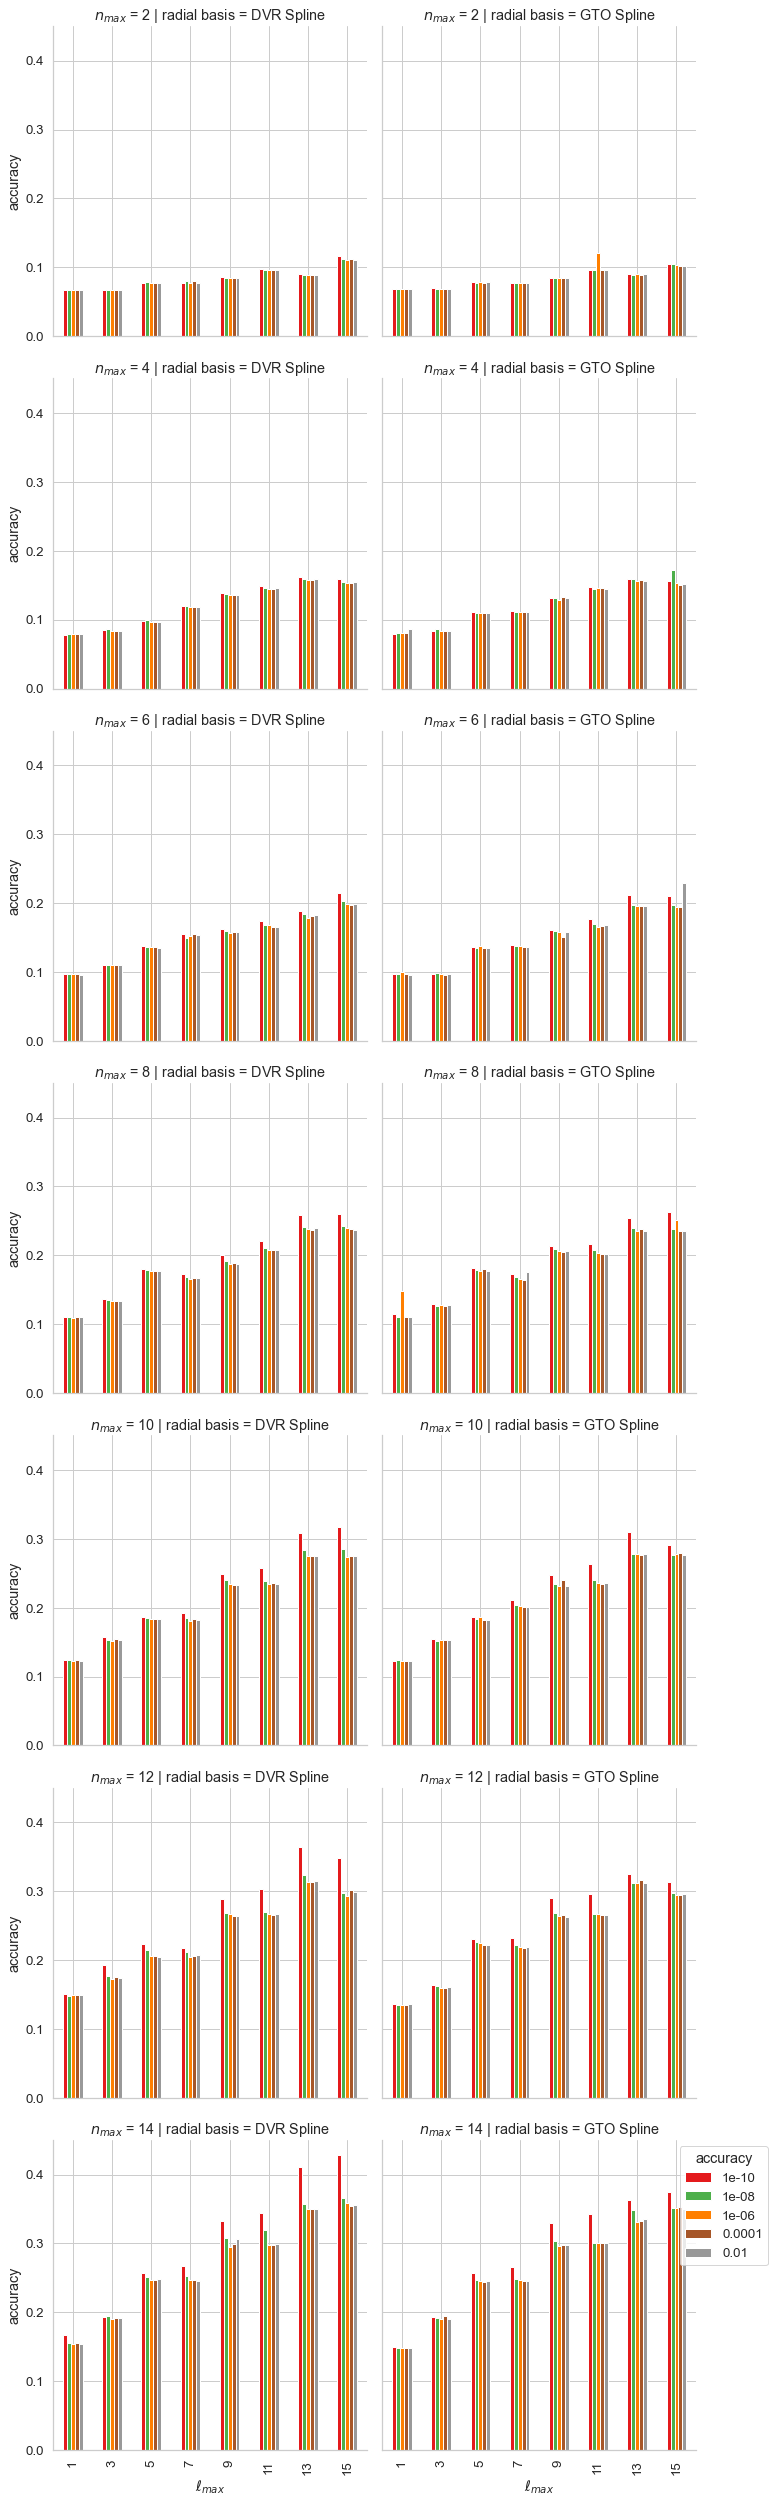

qm9


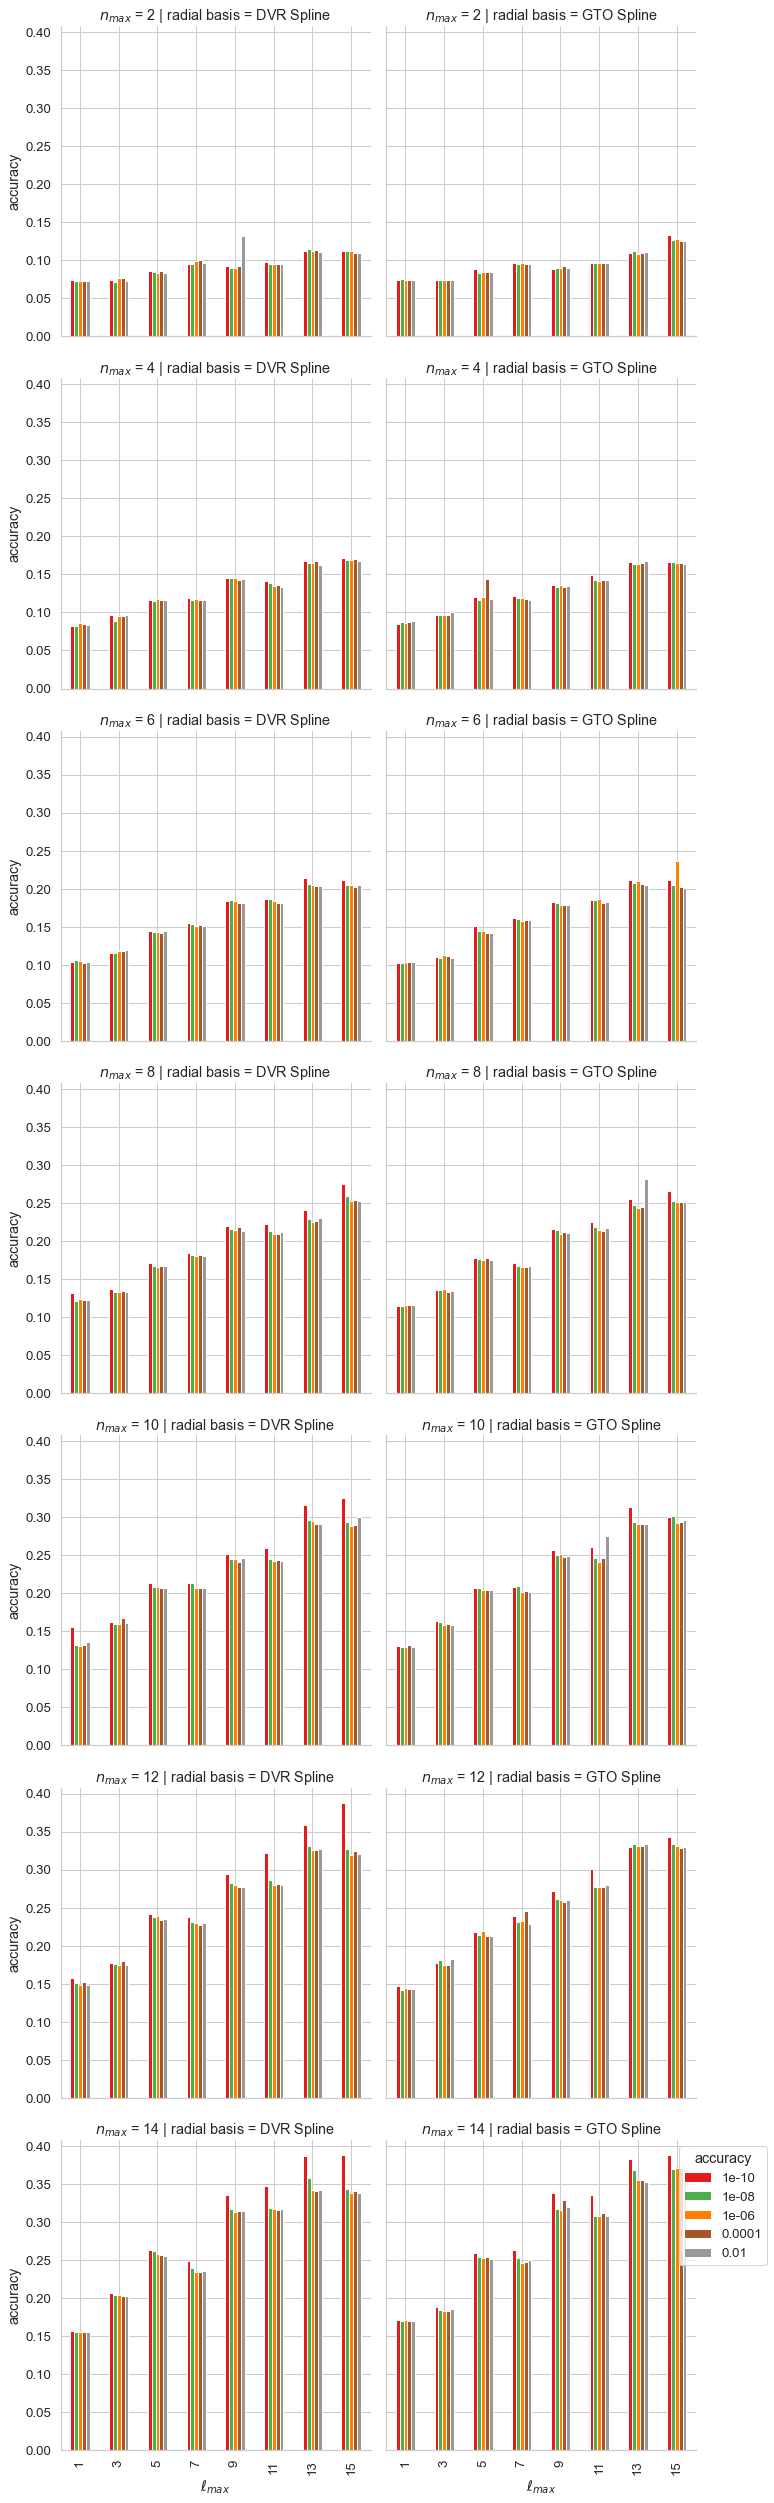

silicon_bulk


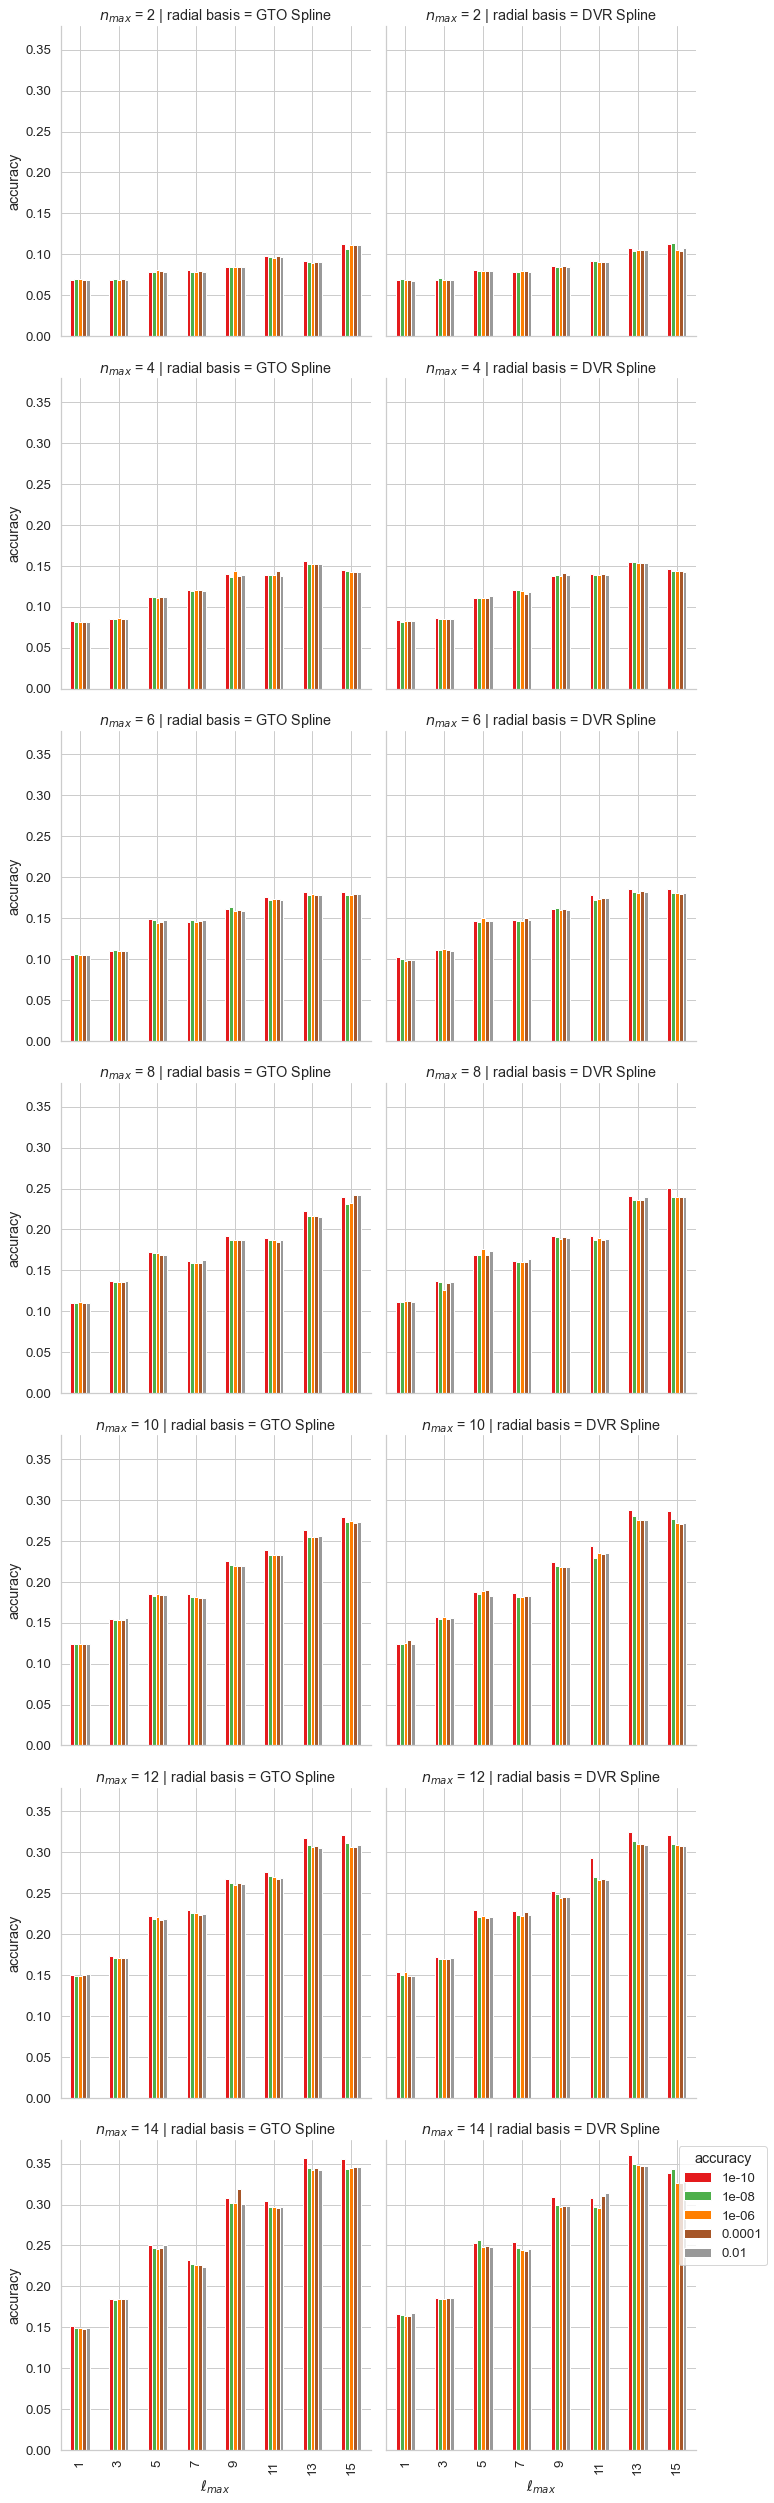

In [29]:
def plot_bars(df, x, y, values , row, col, **kwargs):
    g = sns.FacetGrid(df, col=col, row=row, height=5, **kwargs)
    g.map_dataframe(draw_bar, x, y, values)
    return g
def draw_bar(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[0], columns=args[1], values=args[2])
    ax = plt.gca()
    d.plot(kind='bar',colormap="Set1",stacked=False, ax=ax)
for dataset,df1 in df.groupby(['Dataset']):
    print(dataset)
    plot_bars(df1, '$\ell_{max}$', 'accuracy', 'timing [$\mu sec/N_{neighbor}$]',
              '$n_{max}$', 'radial basis' )
    plt.ylabel('timing [$\mu sec/N_{neighbor}$]')
    plt.legend(title='accuracy',loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.show()

+ splined ri timing does not depend on the accuracy
+ memory footprint does not change much with accuracy

# spherical harmonics

In [27]:
names = [
    'qm9','molecular_crystals',
    'silicon_bulk',
]

In [129]:
project = signac.get_project(fn_projects['sph'])
for job in project.find_jobs():
    print(job.sp)

{'name': 'qm9', 'filename': '../../structures/qm9.json', 'representation': {'interaction_cutoff': 4, 'cutoff_smooth_width': 0.5, 'max_radial': 2, 'max_angular': 9, 'gaussian_sigma_type': 'Constant', 'compute_gradients': True}, 'nl_type': 'Full', 'adaptors': [{'initialization_arguments': {'cutoff': 4}, 'name': 'neighbourlist'}, {'initialization_arguments': {}, 'name': 'centercontribution'}, {'initialization_arguments': {'cutoff': 4}, 'name': 'strict'}], 'seed': 10, 'N_ITERATIONS': 50, 'n_structures': 2500, 'start_structure': 0}
{'name': 'qm9', 'filename': '../../structures/qm9.json', 'representation': {'interaction_cutoff': 4, 'cutoff_smooth_width': 0.5, 'max_radial': 2, 'max_angular': 1, 'gaussian_sigma_type': 'Constant', 'compute_gradients': False}, 'nl_type': 'Full', 'adaptors': [{'initialization_arguments': {'cutoff': 4}, 'name': 'neighbourlist'}, {'initialization_arguments': {}, 'name': 'centercontribution'}, {'initialization_arguments': {'cutoff': 4}, 'name': 'strict'}], 'seed': 1

## spherical harmonics $l_{max}$

In [28]:
project = signac.get_project(fn_projects['sph'])
results = []
qry = {
    # 'representation.interaction_cutoff': {'$eq':4},
      }
          
for job in project.find_jobs(qry):
    res = {
        '$\ell_{max}$':job.sp.representation.max_angular, 
        '$r_{c}$':job.sp.representation.interaction_cutoff,
        'compute grad':job.sp.representation.compute_gradients,
        'Dataset': job.sp.name, 
    }
    
    res.update(**job.document)
    res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
    res['std [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_std'] / res['n_neighbors']
    res['memory footprint [MiB]'] = res['mem_max']
    results.append(res)
df = pd.DataFrame(results)

molecular_crystals


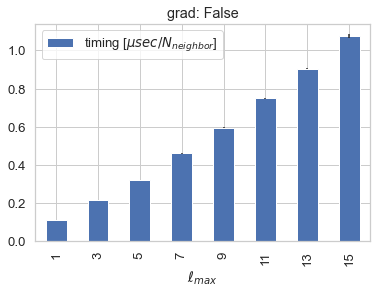

molecular_crystals


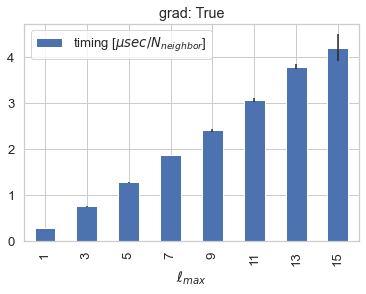

qm9


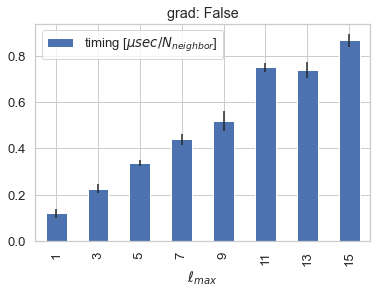

qm9


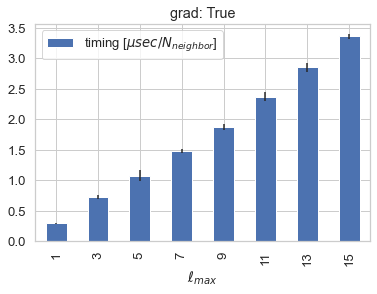

silicon_bulk


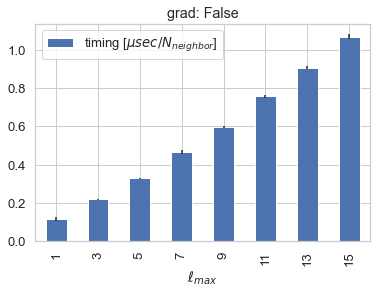

silicon_bulk


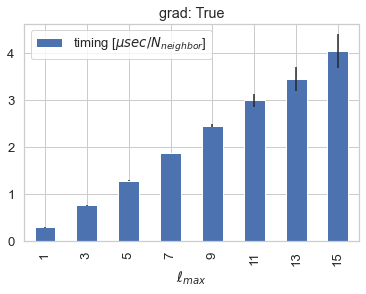

In [29]:
for (name,grad), df1 in df.groupby(['Dataset','compute grad']):
    print(name)
    df1.sort_values('$\ell_{max}$').plot(kind='bar', x='$\ell_{max}$', y='timing [$\mu sec/N_{neighbor}$]', 
             yerr='std [$\mu sec/N_{neighbor}$]', 
             logy=False, title='grad: {}'.format(grad), legend=False)
    plt.legend()
    plt.show()

molecular_crystals


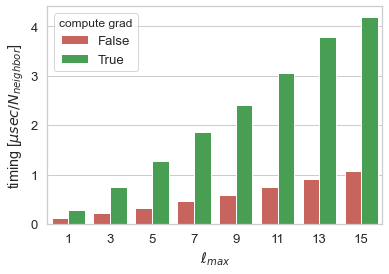

qm9


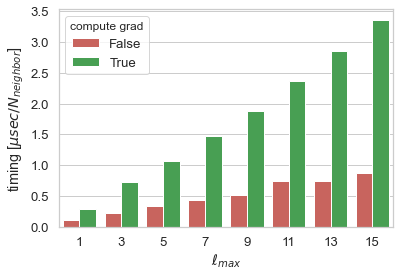

silicon_bulk


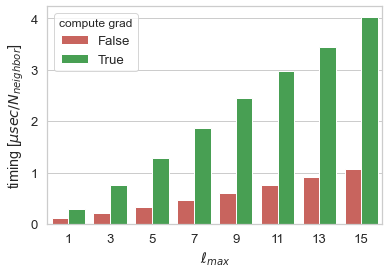

In [30]:
for name, df1 in df.groupby(['Dataset']):
    print(name)
    sns.barplot(x='$\ell_{max}$', y='timing [$\mu sec/N_{neighbor}$]',hue='compute grad', 
                data=df1, ci=None, palette=palette)
    fname = 'sph/sph-{}.png'.format(name)
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

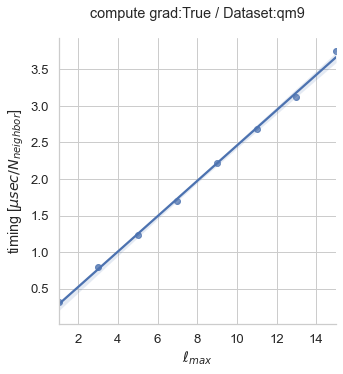

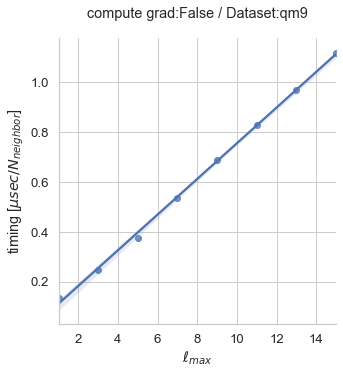

In [132]:
for df in dfs[label]:
    df1 = df[df['$r_{c}$']==rc]
    sns.lmplot(x='$\ell_{max}$', y='timing [$\mu sec/N_{neighbor}$]',
               height=5, data=df1, palette=palette, fit_reg=True)
    title = ' / '.join([k+':'+str(df.iloc[0][k]) for k in title_values])
    plt.title(title,pad=20)
    plt.show()

+ runs with differtent $r_c$ have the same runtime
+ Computing with gradients is 4 times more expansive
+ increasing $\ell_{max}$ increases linearly the cost

# spherical expansion

## spherical expansion $n_{max}\;vs\;l_{max}$

In [133]:
project = signac.get_project(fn_projects['se'])
results = []
qry = {'representation.interaction_cutoff': {'$eq':4},
       '$or': [
           {'representation.optimization_args.accuracy': {'$eq':1e-8}},
           {'representation.optimization_args.accuracy': {'$exists':False}}
       ],
      }
qry = {'representation.interaction_cutoff': {'$eq':4},
       'representation.max_angular': {'$eq':9},
       'representation.max_radial': {'$eq':10},
       'representation.compute_gradients':{'$eq':True},
       'representation.radial_basis':{'$eq':'GTO'},
       'representation.optimization_args.accuracy': {'$eq':1e-8},
       'nl_type':{'$eq':'Full'},
       
      }   
for job in project.find_jobs(qry):
    radial_basis = job.sp.representation.radial_basis
    if 'type' in job.sp.representation.optimization_args:
        radial_basis += ' Spline'
        # if 'DVR' in radial_basis and job.sp.representation.optimization_args['range'][0] < 1e-6:
        #     continue
    # if job.sp.name == 'methane_liquid'::
    n_max = job.sp.representation.max_radial
    l_max = job.sp.representation.max_angular+1
    sp_max = len(job.sp.representation.global_species)
    res = {
        'lmax':job.sp.representation.max_angular, 
        'nmax':job.sp.representation.max_radial,
        '$\ell_{max}^2n_{max}$':(l_max+1)**2*n_max,
        'radial basis':radial_basis, 
        'compute grad':job.sp.representation.compute_gradients,
        'Dataset': job.sp.name, 
        '$\sigma$': job.sp.representation.gaussian_sigma_constant,
        'nl_type':job.sp.nl_type
    }
    
    res.update(**job.document)
    res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
    res['timing [$ms/N_{atom}$]'] = 1e3 * res['elapsed_mean'] / res['n_centers']
    res['memory footprint [MiB]'] = res['mem_max']
    results.append(res)
df = pd.DataFrame(results)

In [134]:
df

lmax  nmax  $\ell_{max}^2n_{max}$ radial basis  compute grad  \
0     9    10                   1210   GTO Spline          True   
1     9    10                   1210   GTO Spline          True   
2     9    10                   1210   GTO Spline          True   
3     9    10                   1210   GTO Spline          True   
4     9    10                   1210   GTO Spline          True   

              Dataset  $\sigma$ nl_type  elapsed_mean  elapsed_std  n_centers  \
0                 qm9       0.3    Full      4.295119     0.236273       8977   
1    methane_sulfonic       0.3    Full      5.981832     0.351933      42125   
2  molecular_crystals       0.3    Full      4.026418     0.042866       4174   
3        silicon_bulk       0.3    Full      5.234846     0.054190       8508   
4      methane_liquid       0.3    Full      4.190368     0.072288       6750   

   n_neighbors time_unit      mem_max mem_unit  \
0       112120   seconds  3572.980469      MiB   
1       115446   seconds  7915.218750      MiB   
2       113276   seconds  3138.765625      MiB   
3       133980   seconds  3422.679688      MiB   
4       104946   seconds  2885.191406      MiB   

   timing [$\mu sec/N_{neighbor}$]  timing [$ms/N_{atom}$]  \
0                        38.308228                0.478458   
1                        51.814981                0.142002   
2                        35.545202                0.964643   
3                        39.071849                0.615285   
4                        39.928798                0.620795   

   memory footprint [MiB]  
0             3572.980469  
1             7915.218750  
2             3138.765625  
3             3422.679688  
4             2885.191406

methane_liquid Full False
0.5197039358336668 17.52571533884093


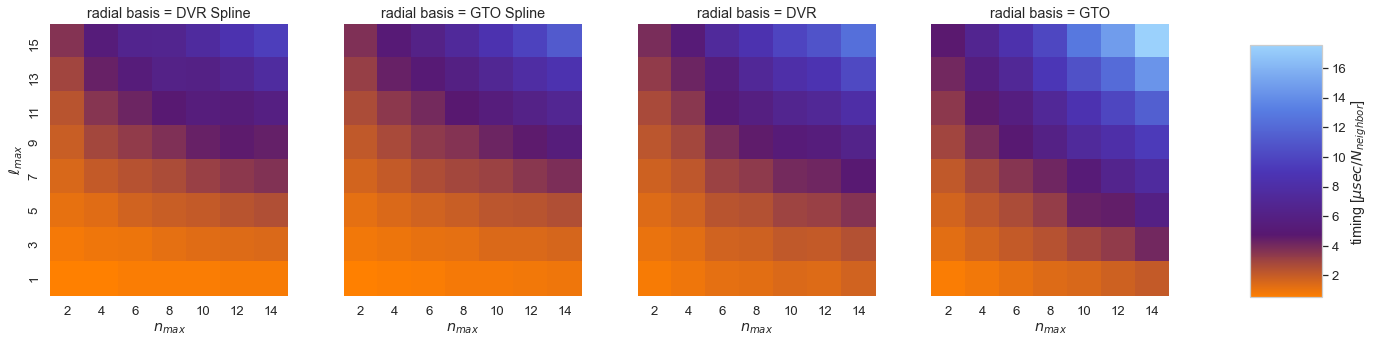

methane_liquid Full True
2.7397179077811447 133.73212921978924


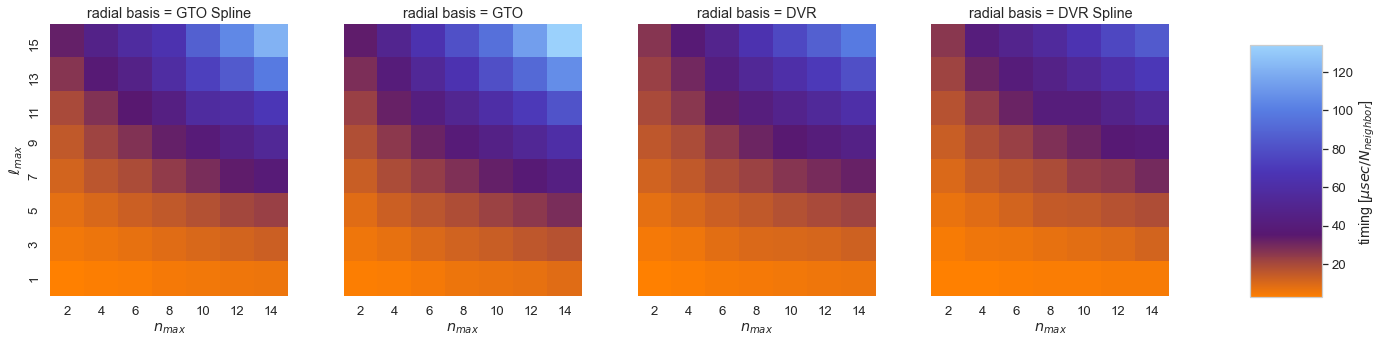

methane_liquid Half False
0.6310023880030925 20.330745962859766


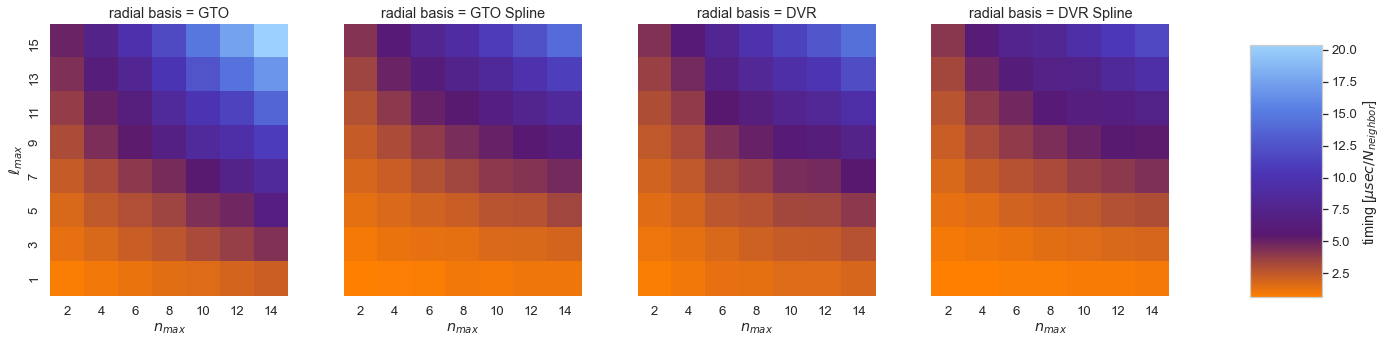

methane_liquid Half True
3.078447275021517 148.56913230076879


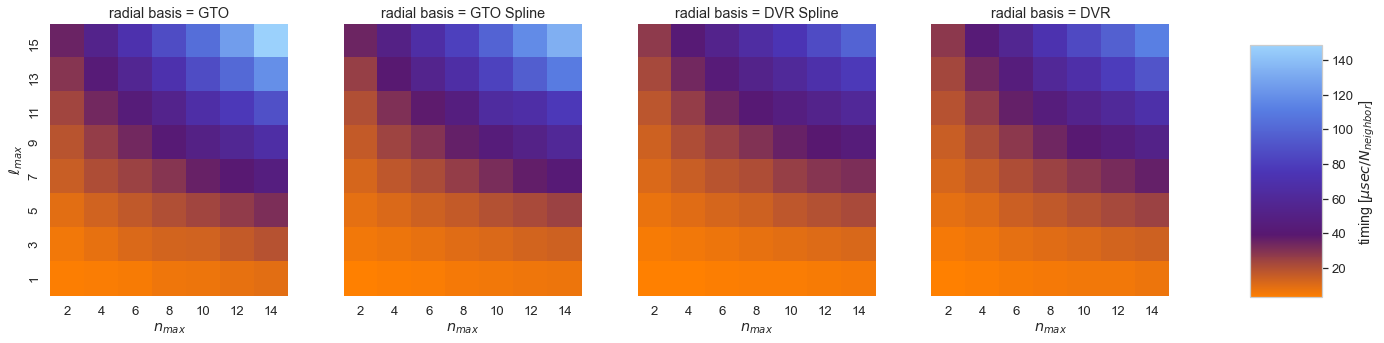

methane_sulfonic Full False
1.4857457902395923 35.61324288845002


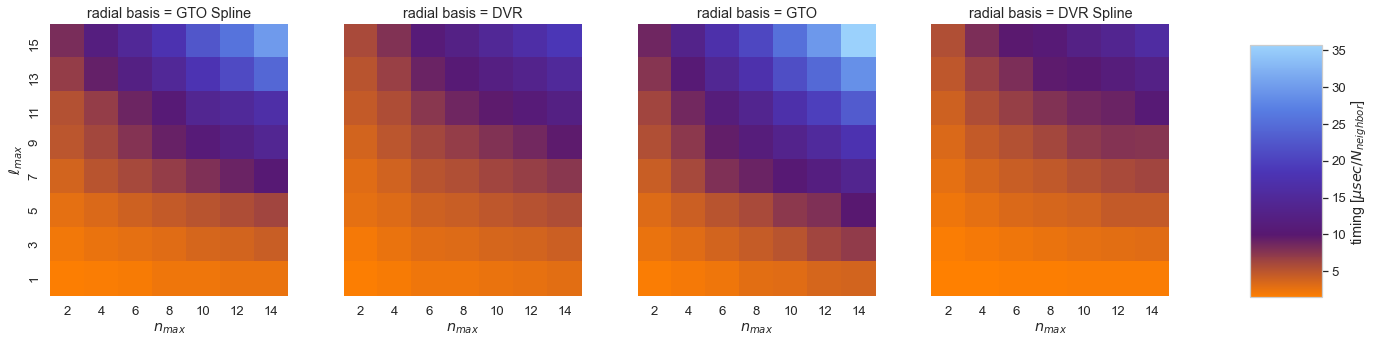

methane_sulfonic Full True
4.744938896540373 189.9663910975694


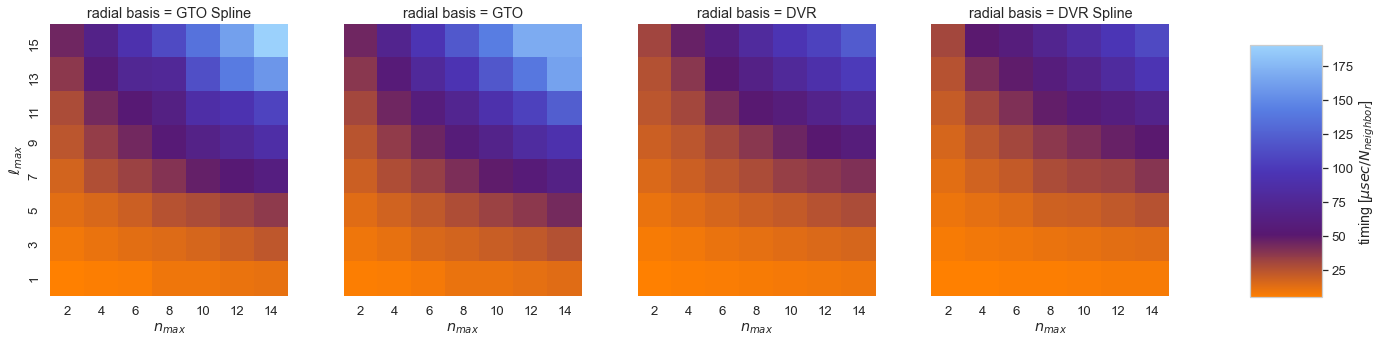

methane_sulfonic Half False
2.415586003744919 53.00523610193486


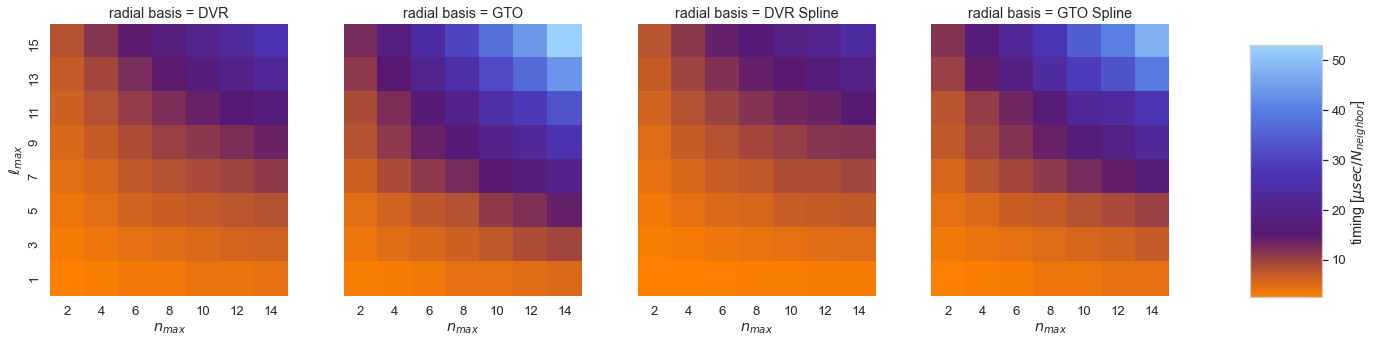

methane_sulfonic Half True
6.741401101402061 272.4170469332765


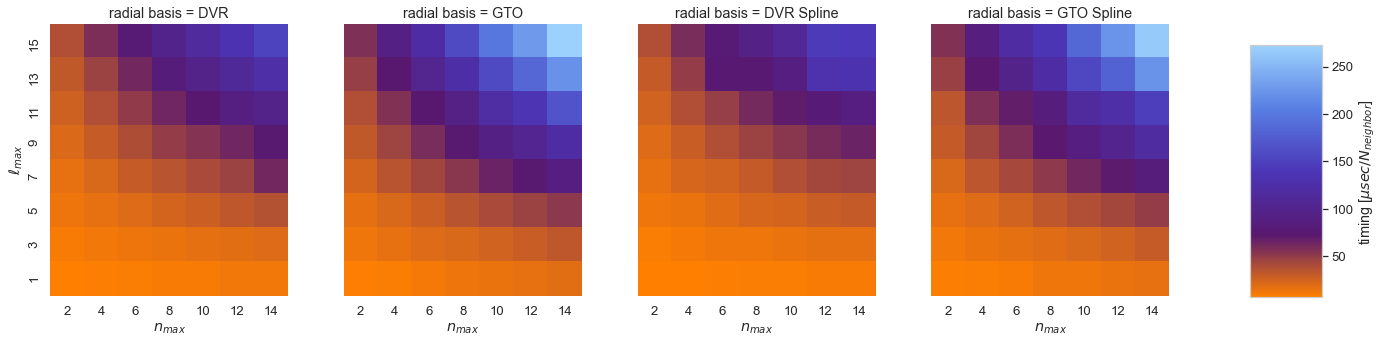

molecular_crystals Full False
0.5183816285003001 15.230897036441966


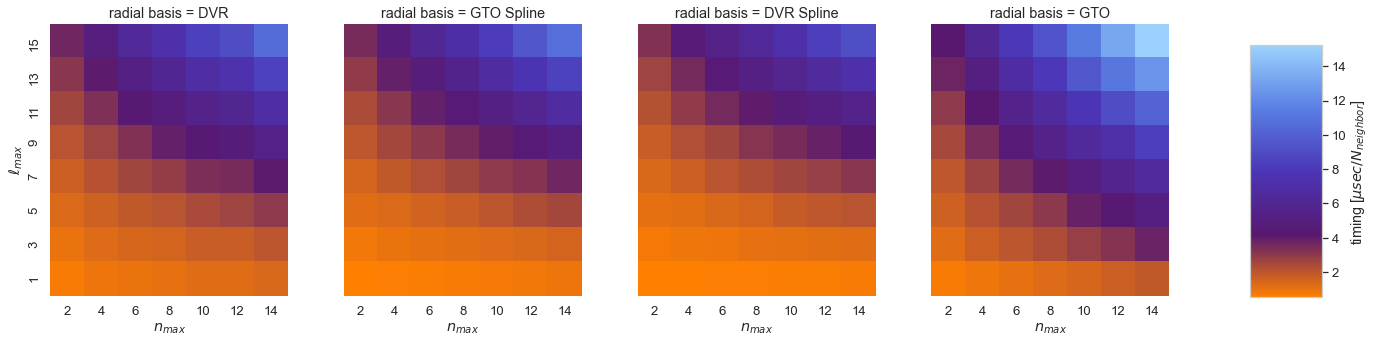

molecular_crystals Full True
2.6428082568240407 119.27851305042552


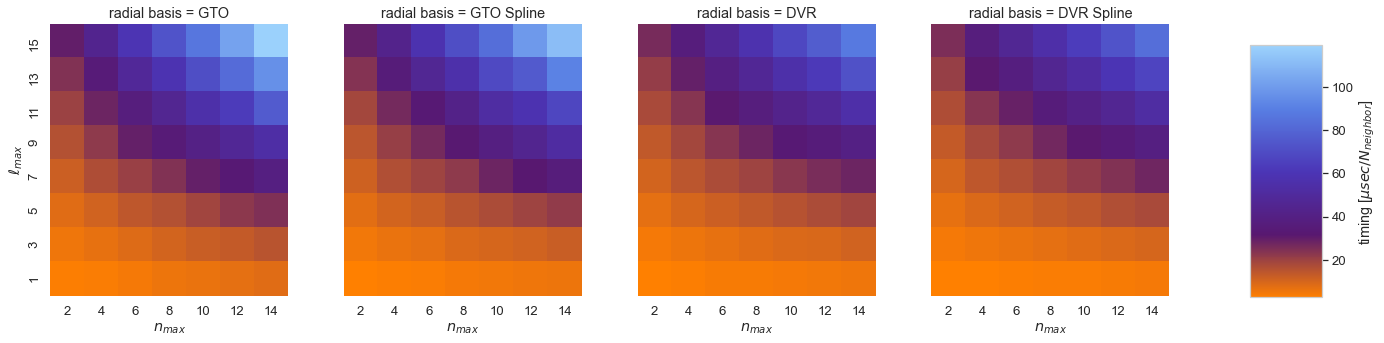

molecular_crystals Half False
0.6073454172375462 17.91665971292299


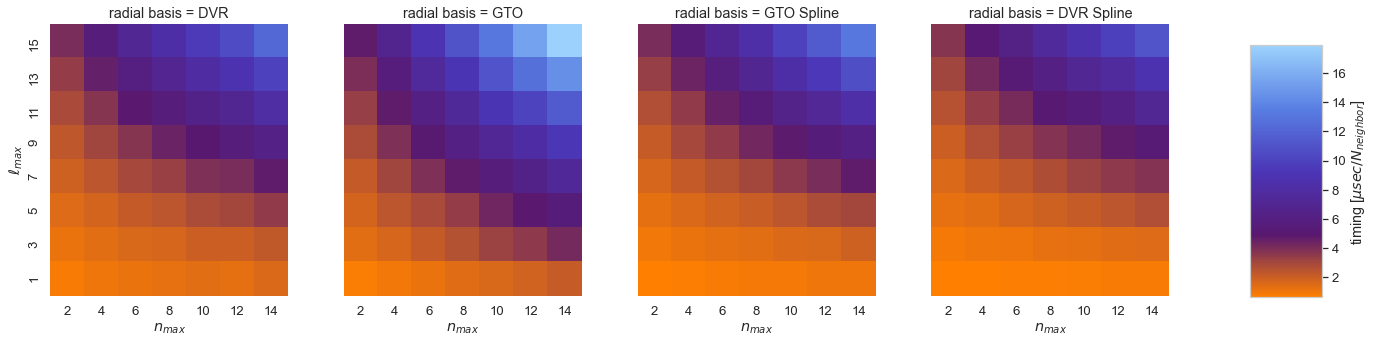

molecular_crystals Half True
2.8926254401158134 131.69685604399865


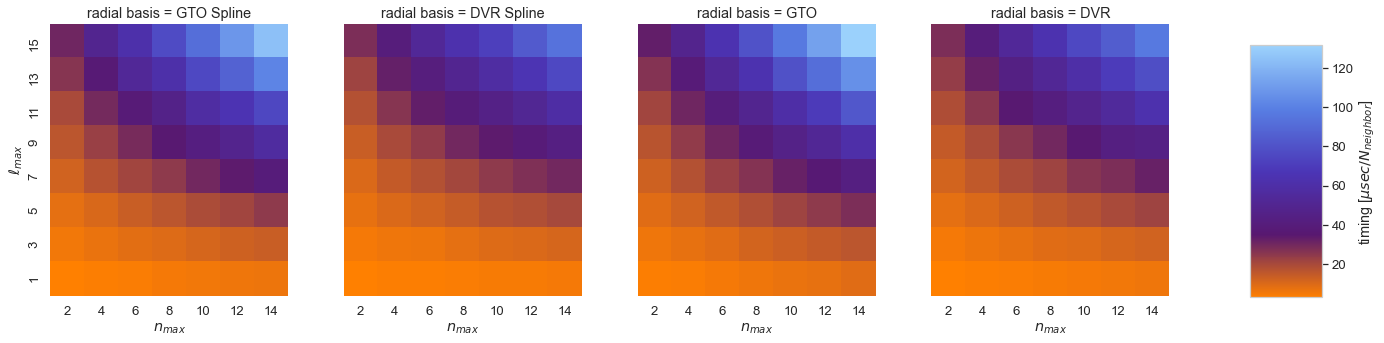

qm9 Full False
0.6267771356582232 19.68452097797003


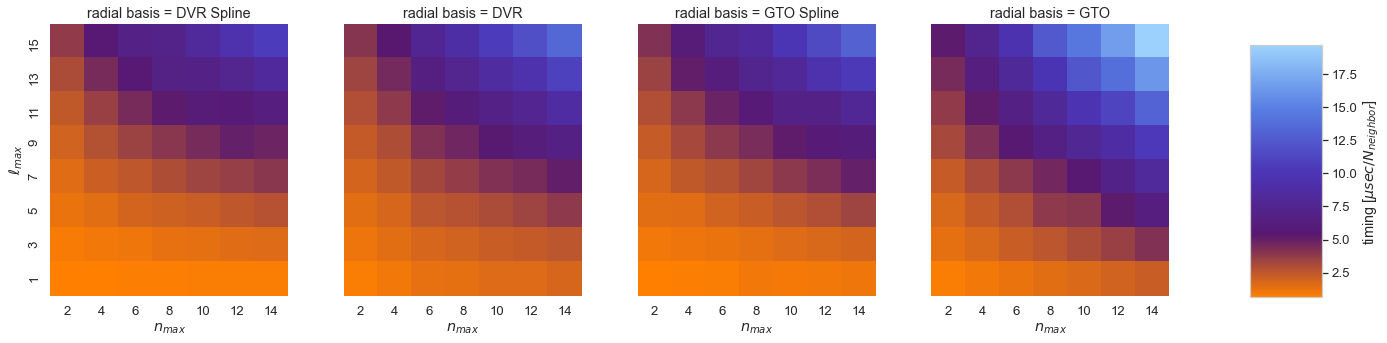

qm9 Full True
3.066091245094542 143.78966229620053


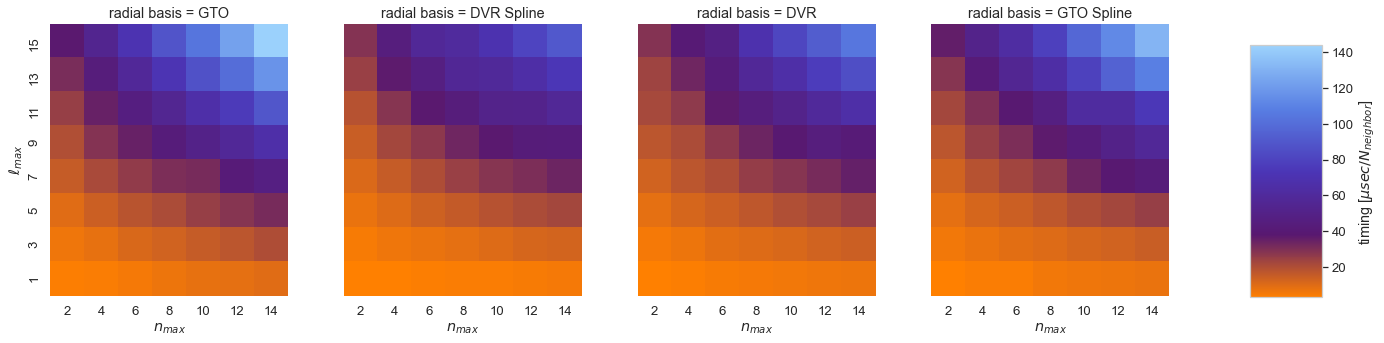

qm9 Half False
0.9782265376382449 26.65144512575812


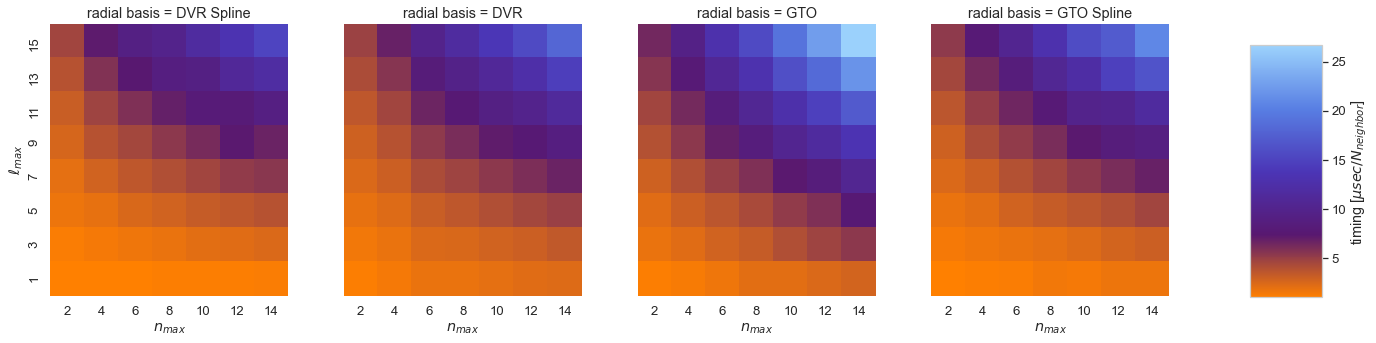

qm9 Half True
3.8081913833392793 171.86369002497324


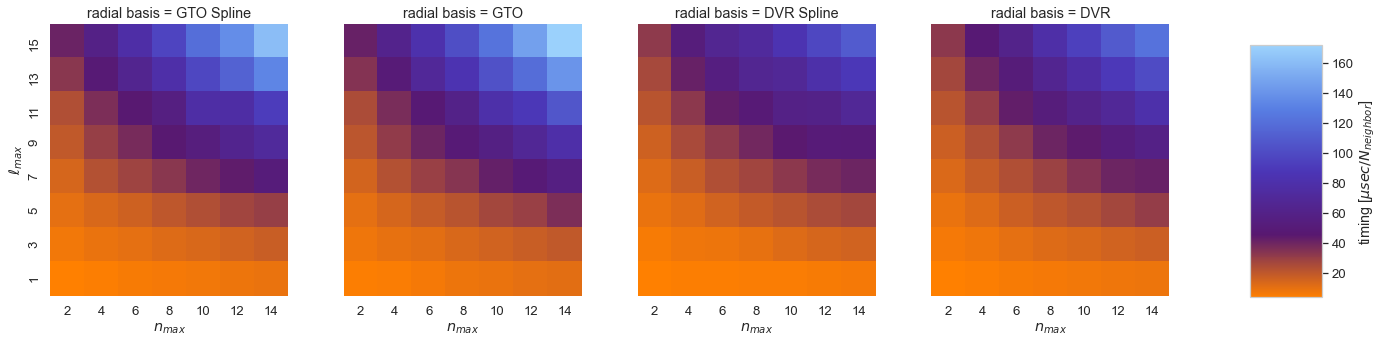

silicon_bulk Full False
0.4935198816987611 16.376449022988506


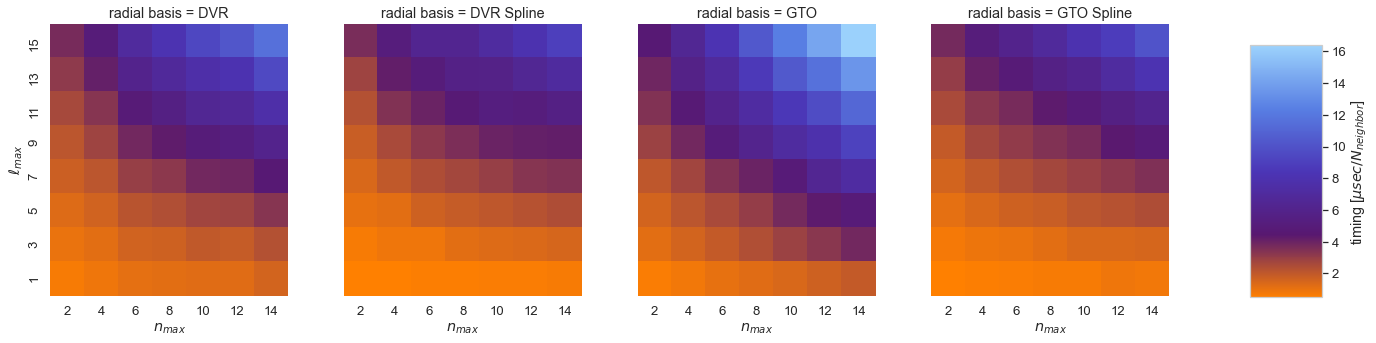

silicon_bulk Full True
2.6691906355426185 130.5005594614868


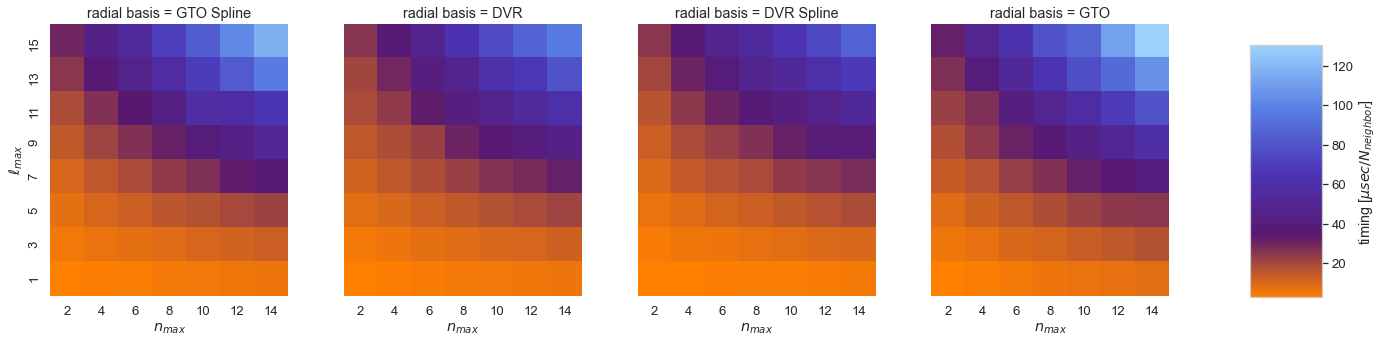

silicon_bulk Half False
0.566073947183946 17.58647114263892


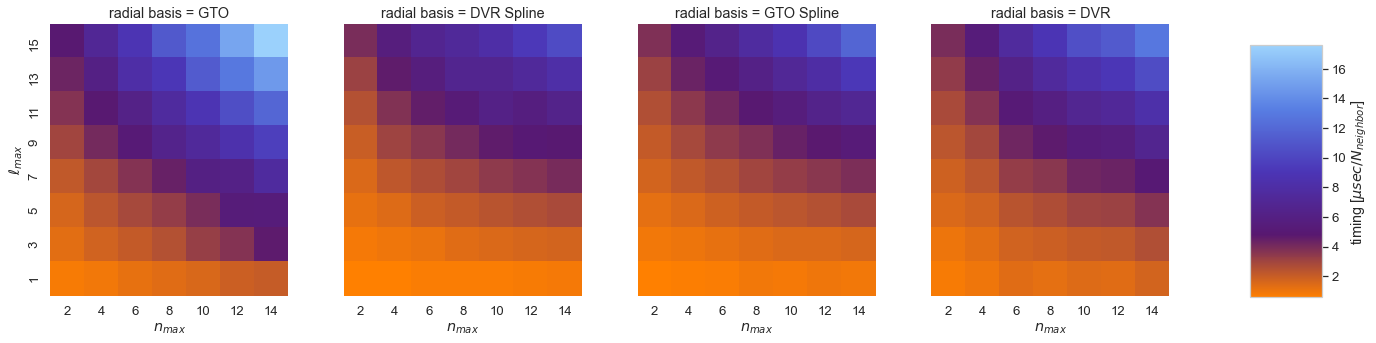

silicon_bulk Half True
2.831167272460948 138.61609065465544


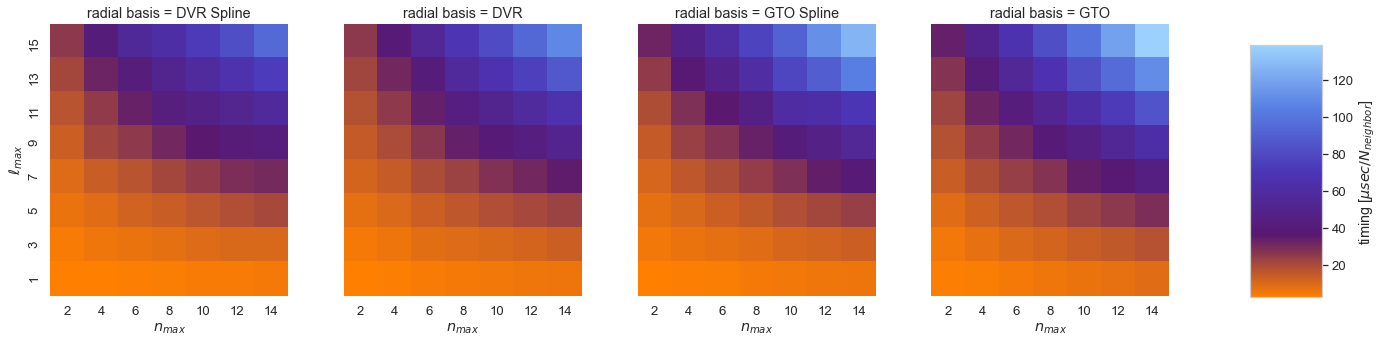

In [168]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
for (dataset,nl_type,grad), df1 in df.groupby(['Dataset','nl_type','compute grad']):
    print(dataset,nl_type,grad)
    try:
        g = plot_contour(df1,x='$n_{max}$',y='$\ell_{max}$', values='timing [$\mu sec/N_{neighbor}$]', 
                                   col='radial basis',row=None,**kwargs)
        fname = 'se/se-n_vs_l-{}-{}-{}.png'.format(dataset,nl_type,grad)
        plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
        plt.show()
    except:
        pass


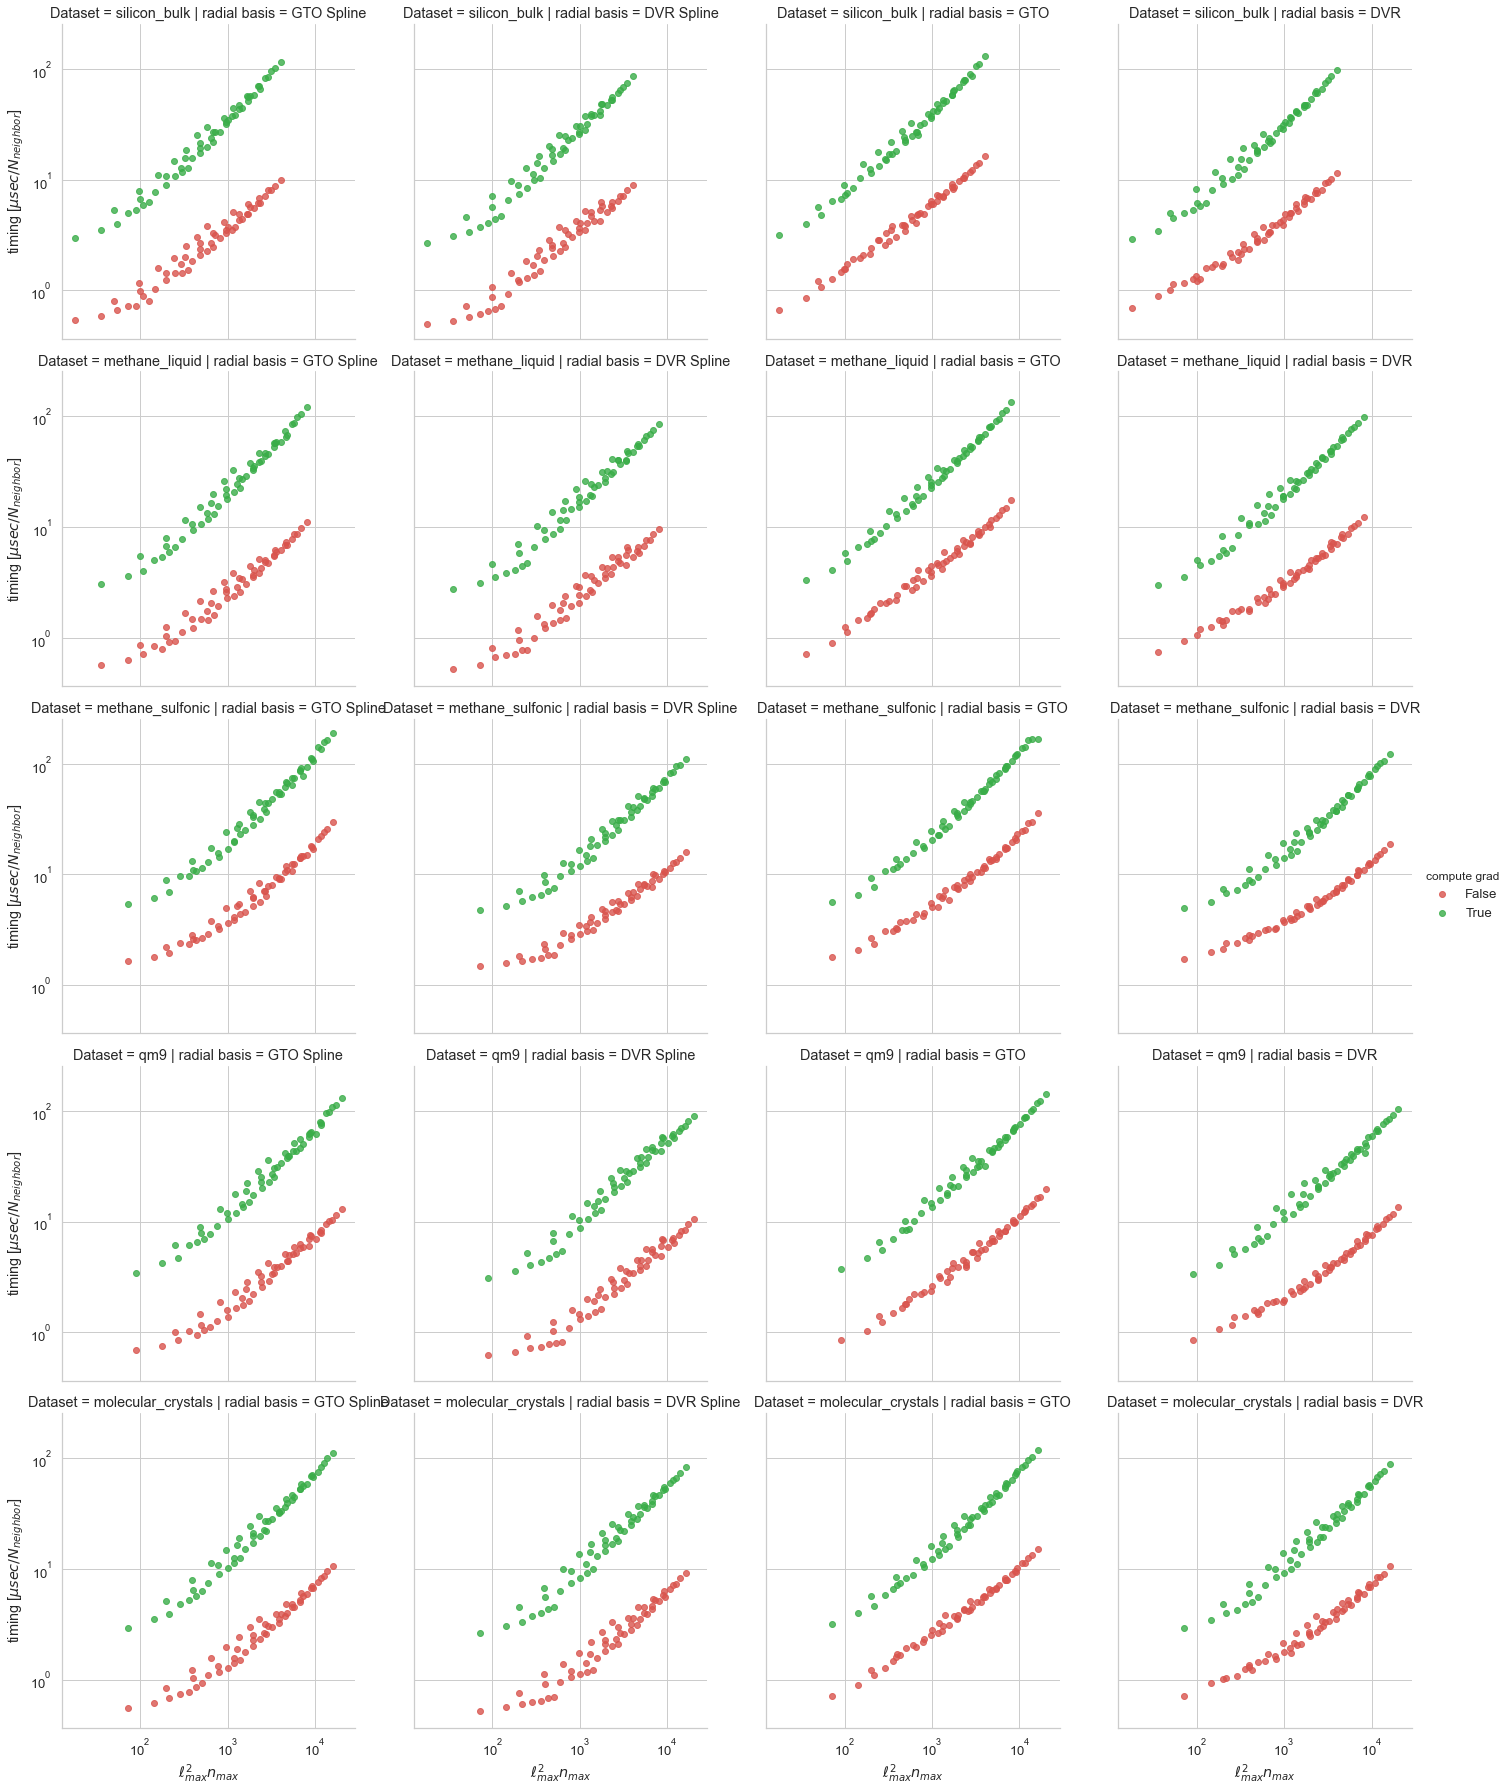

In [82]:
g = sns.lmplot(data=df.query("nl_type=='Full'"), x='$\ell_{max}^2n_{max}$', y='timing [$\mu sec/N_{neighbor}$]',
               hue='compute grad',line_kws={'linestyle':'--'},legend=True,
                height=5, palette=palette, col='radial basis', row='Dataset', fit_reg=False)   
# title = ' / '.join([k+':'+str(df.iloc[0][k]) for k in title_values])
# plt.title(title,pad=20)
plt.xscale('log')
plt.yscale('log')
fname = 'se/se-coef_scaling.png'.format(dataset,grad)
plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')

False Full


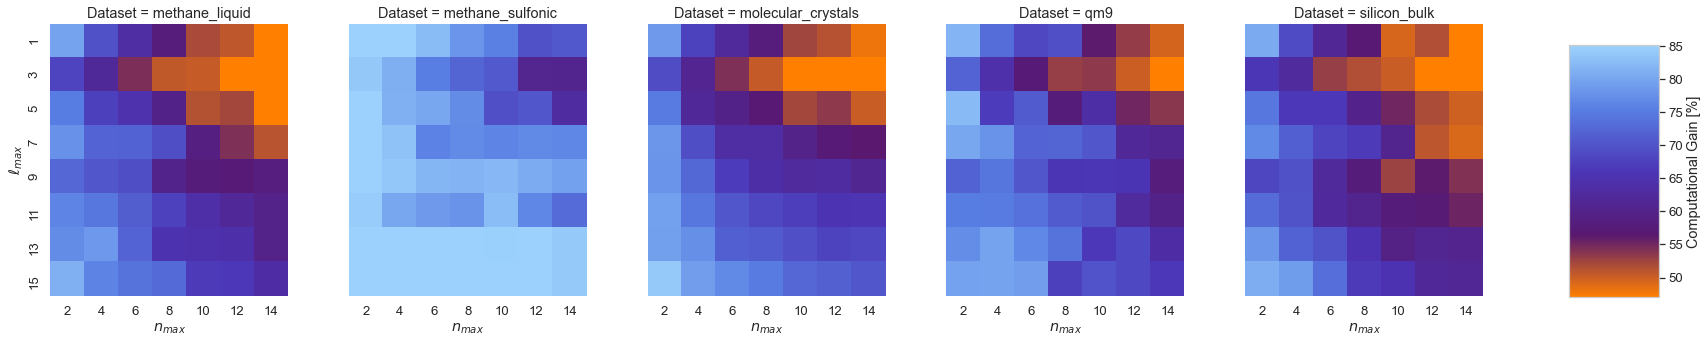

False Half


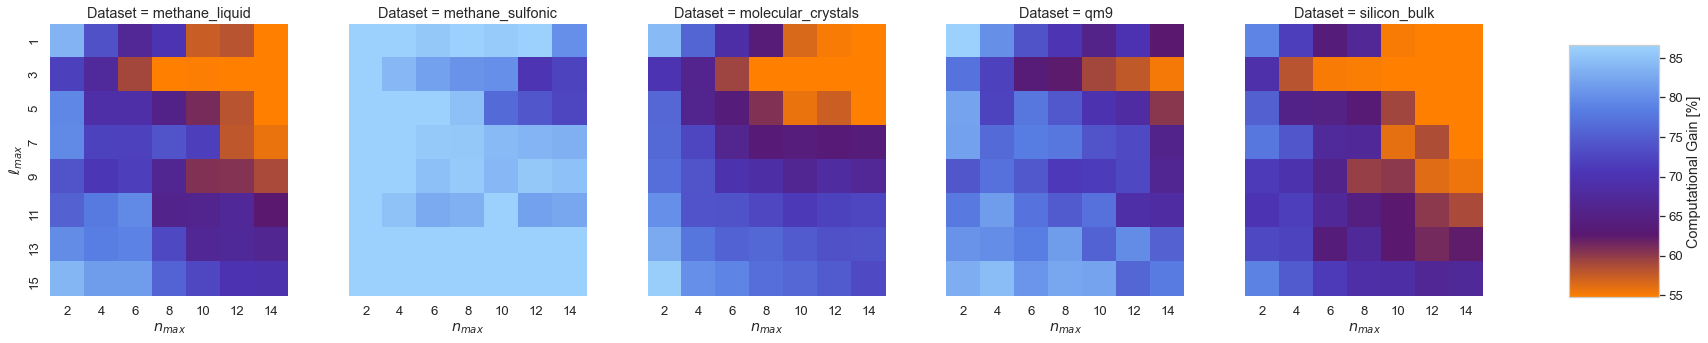

True Full


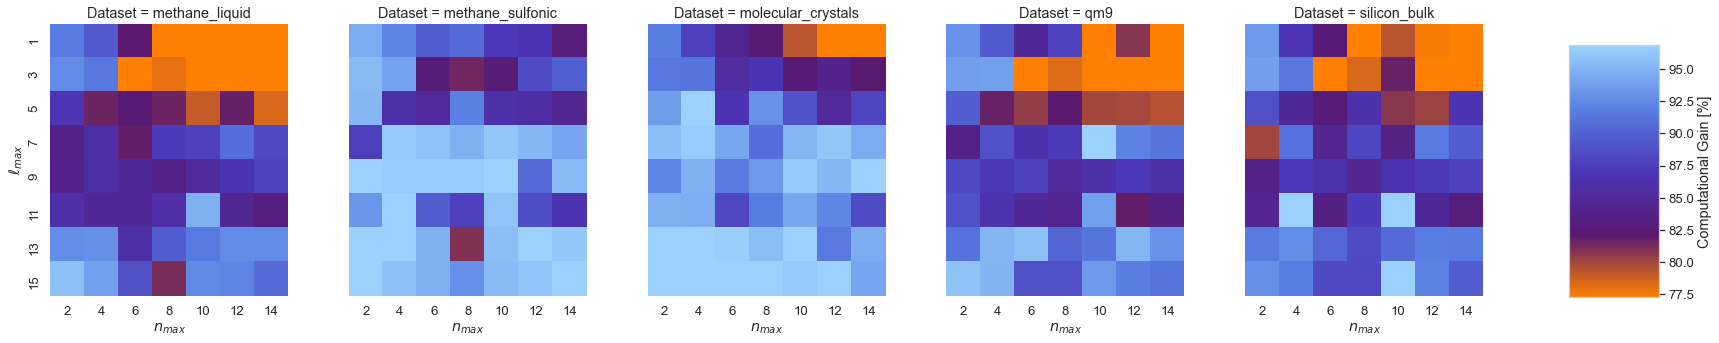

True Half


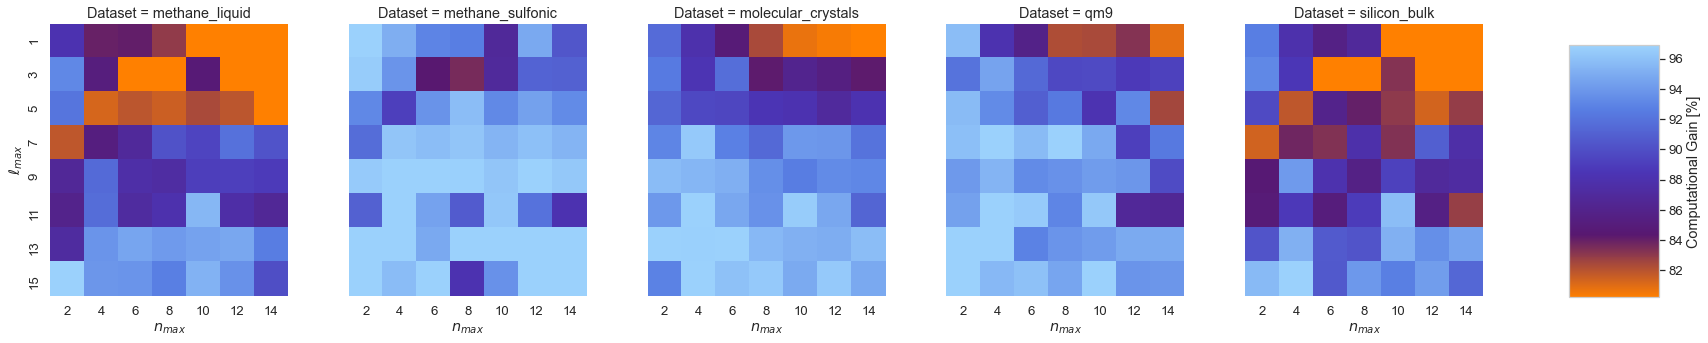

In [34]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
tag = 'radial basis'
A = 'GTO'
B = 'GTO Spline'
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
for (grad,nl_type), df_ in df.groupby(['compute grad','nl_type']):
    print(grad, nl_type)
    g = plot_contour_comp(df_,x,y,z,A,B,tag,None,'Dataset')
    fig = g.fig
    fname = 'se/se-gto_vs_spline-{}-{}.png'.format(nl_type,grad)
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

False Full


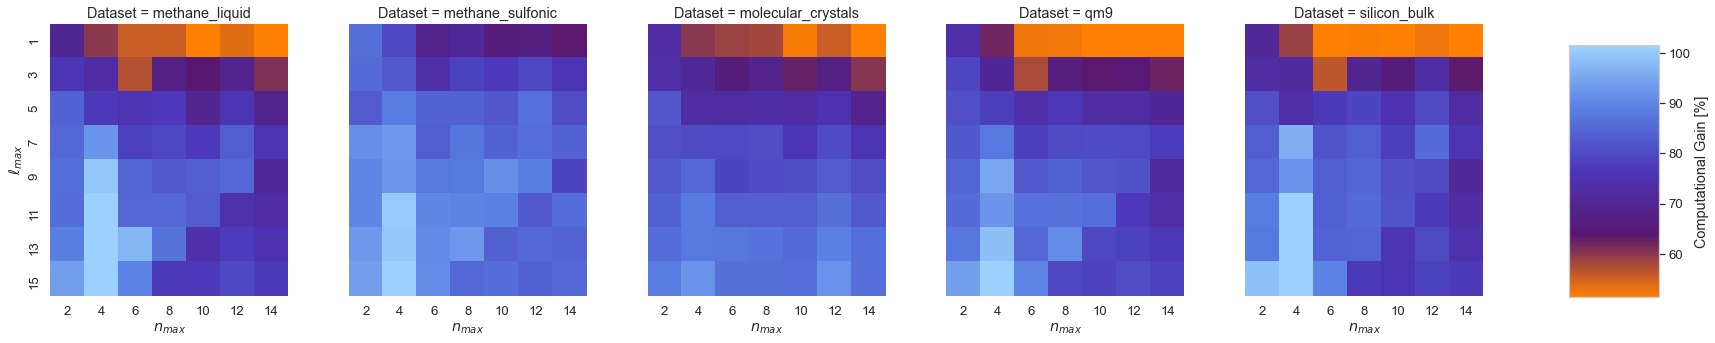

False Half


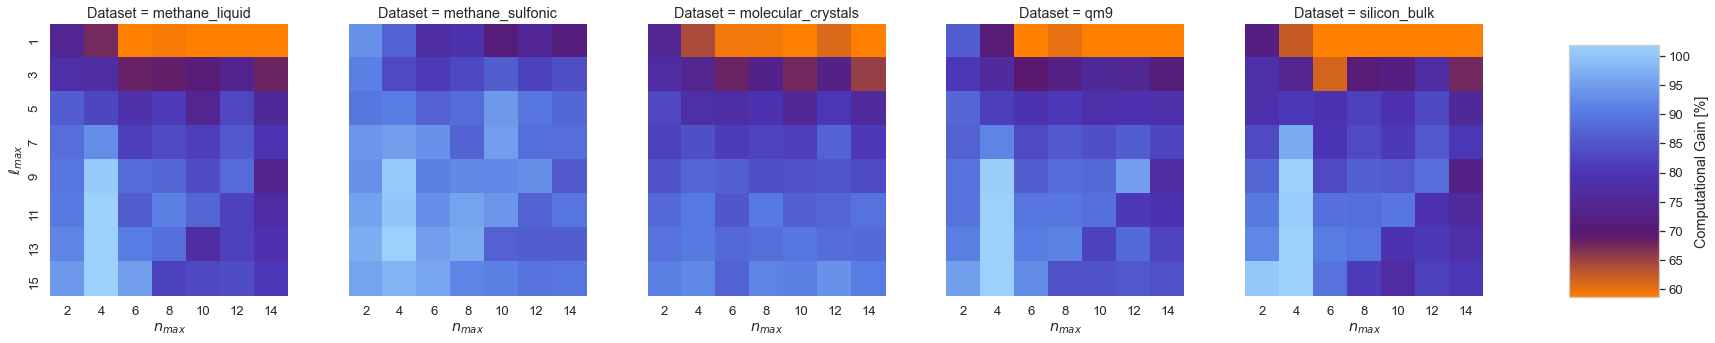

True Full


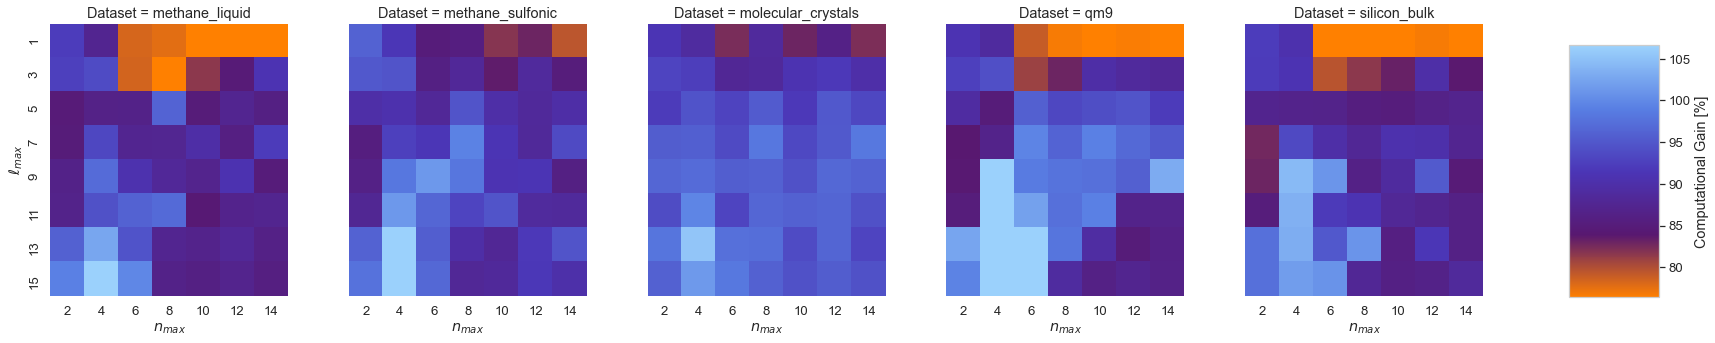

True Half


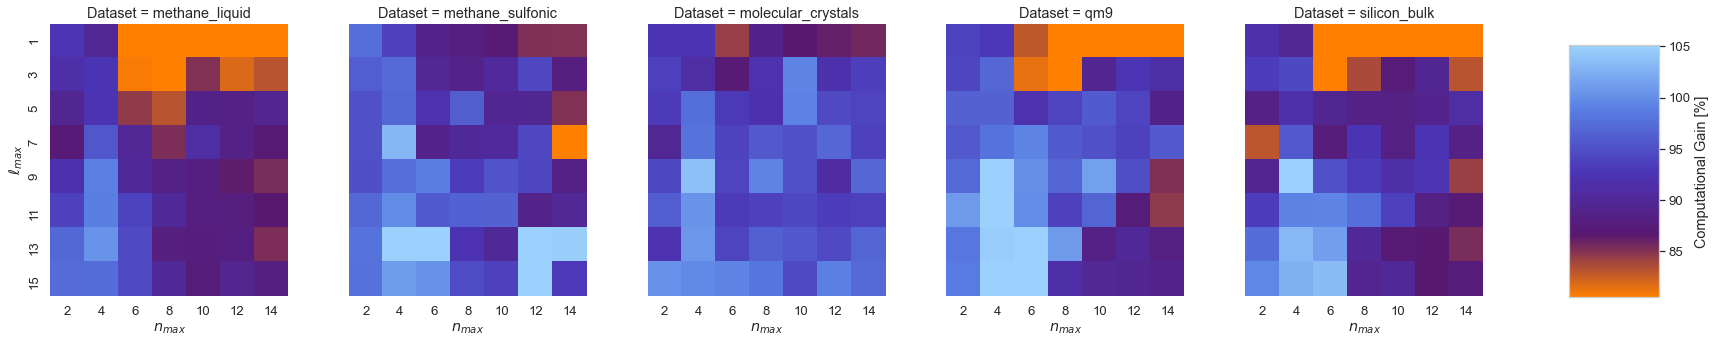

In [35]:
A = 'DVR'
B = 'DVR Spline'
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
for (grad,nl_type), df_ in df.groupby(['compute grad','nl_type']):
    print(grad, nl_type)
    g = plot_contour_comp(df_,x,y,z,A,B,tag,None,'Dataset')
    fname = 'se/se-dvr_vs_spline-{}-{}.png'.format(nl_type,grad)
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    fig = g.fig
    plt.show()

In [165]:
A = 'GTO'
B = 'DVR'
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
for (grad,nl_type), df_ in df.groupby(['compute grad','nl_type']):
    print(grad, nl_type)
    g = plot_contour_comp(df_,x,y,z,A,B,tag,None,'Dataset')
    fig = g.fig
    fname = 'se/se-gto_vs_dvr-{}-{}.png'.format(nl_type,grad)
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

False Full


/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


ValueError: zero-size array to reduction operation minimum which has no identity

Full


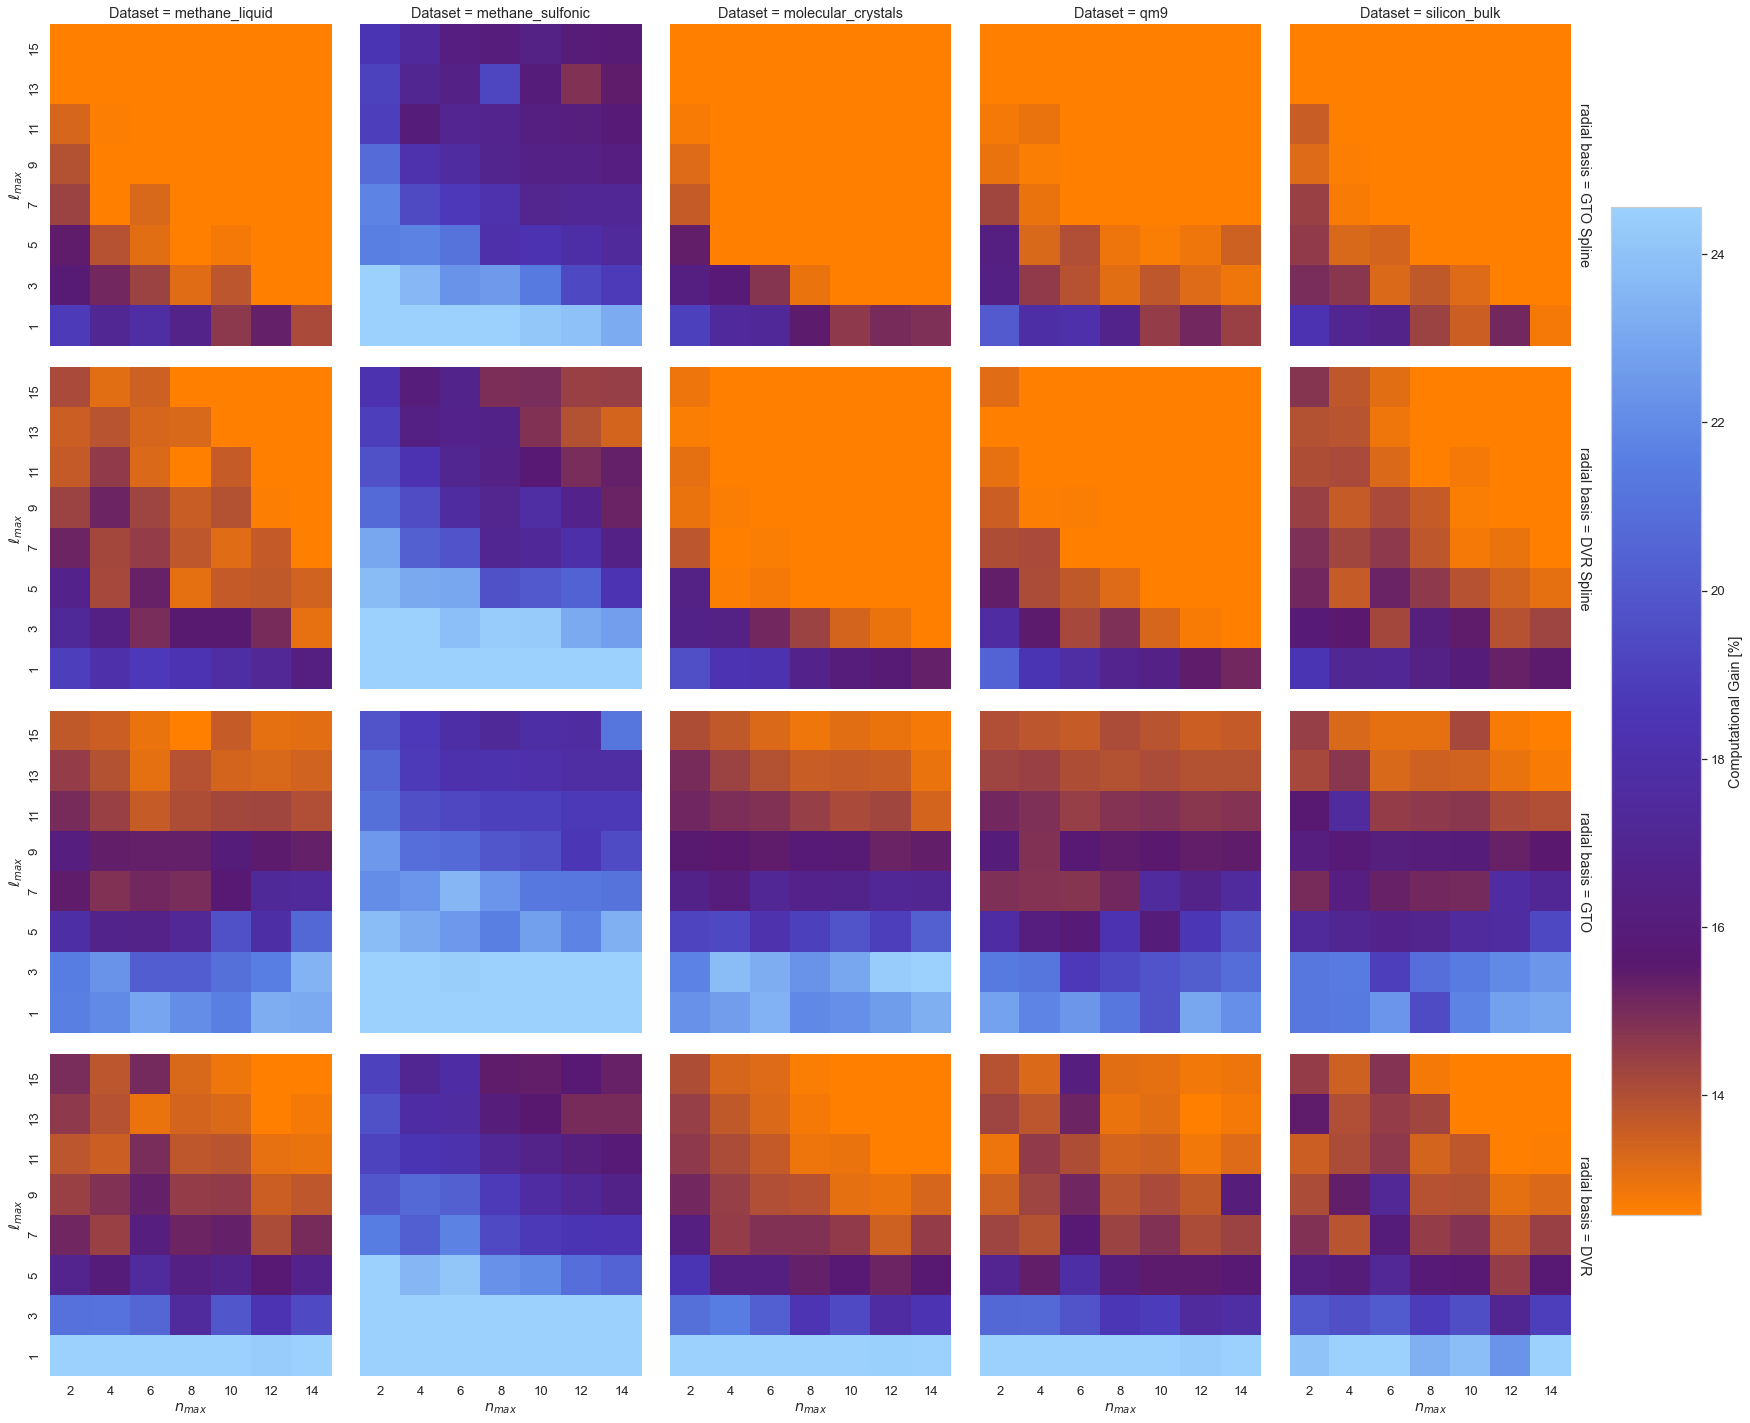

Half


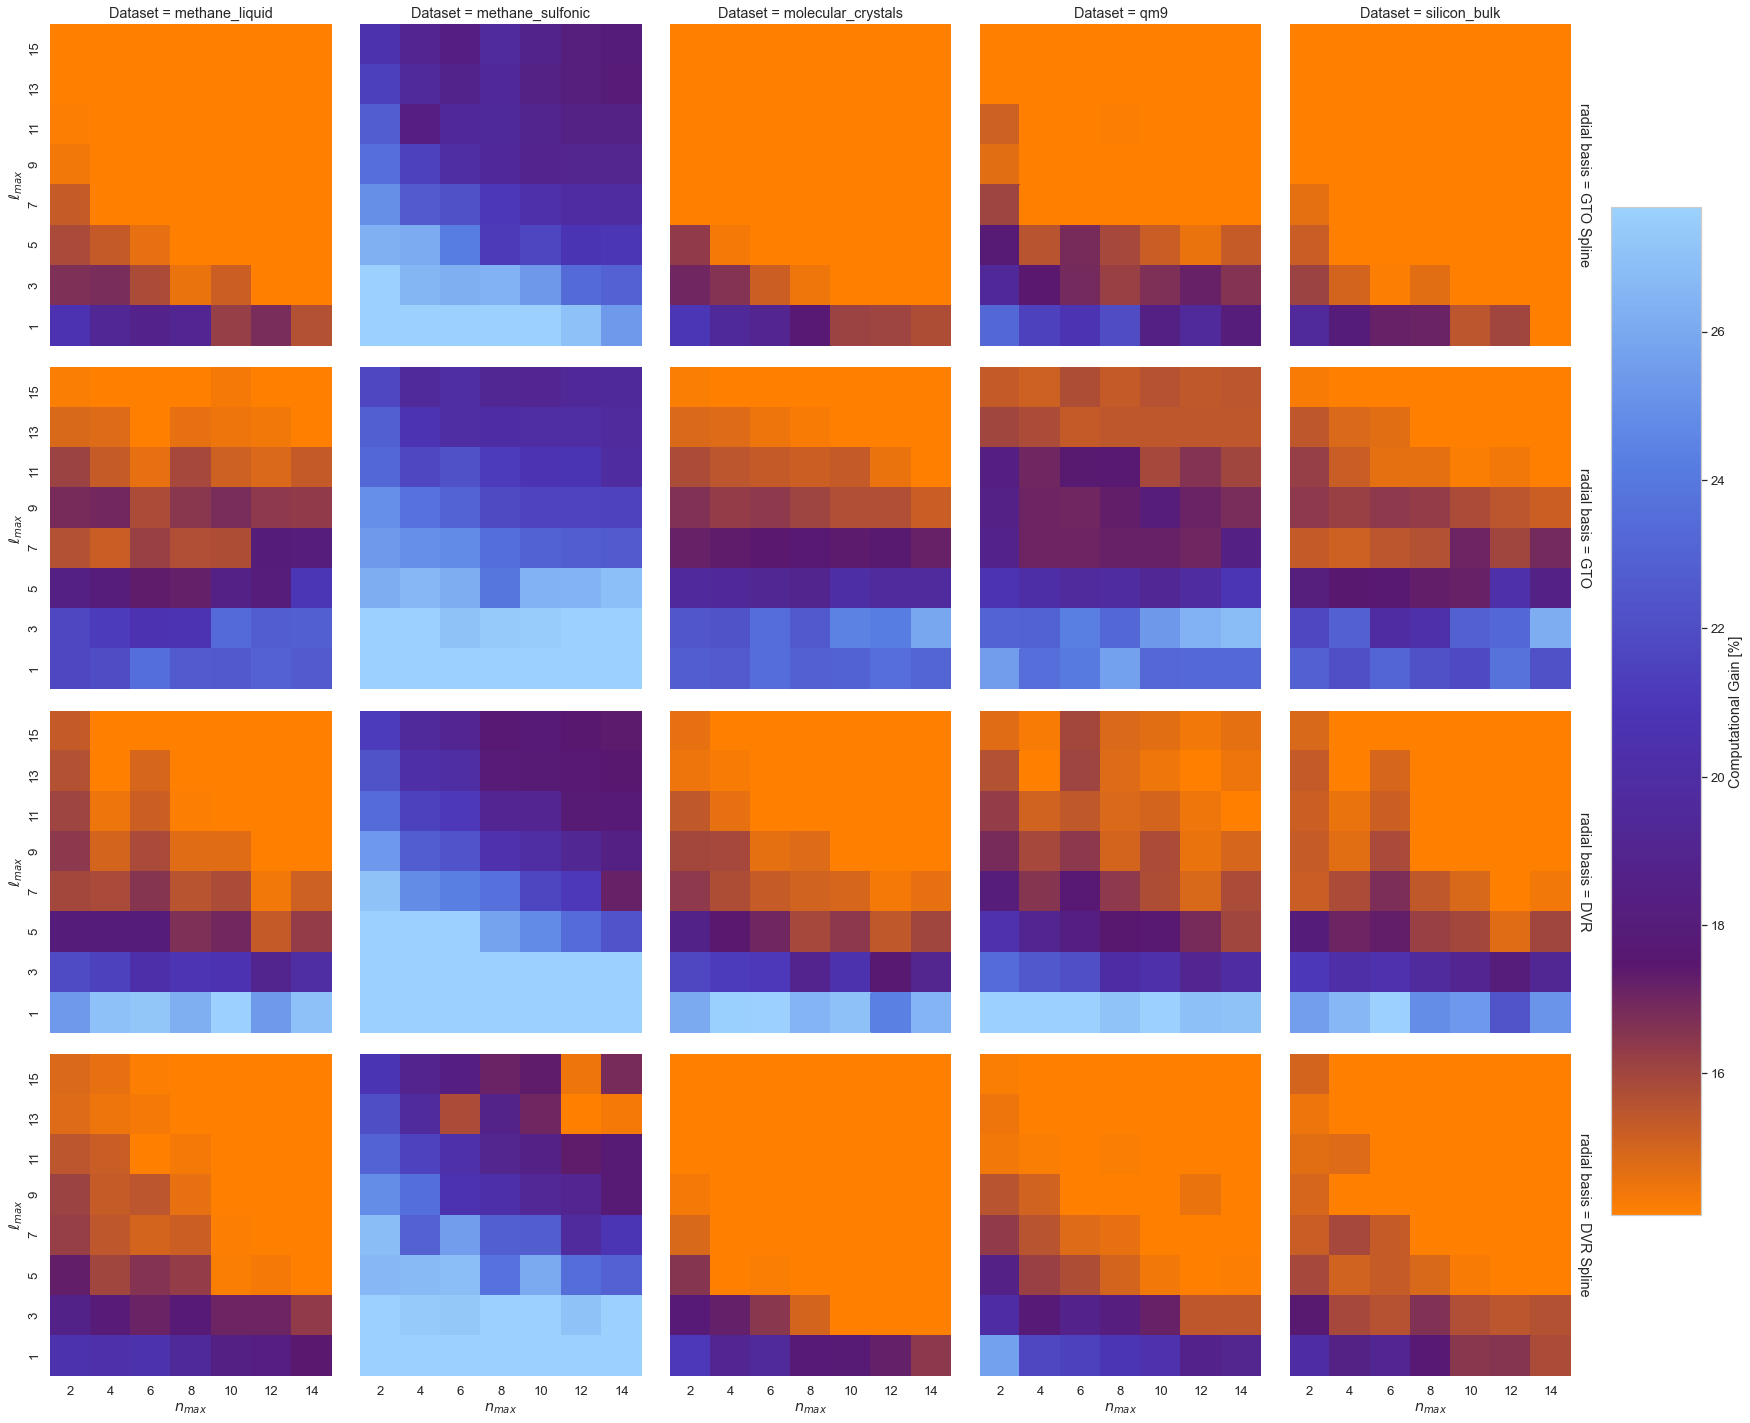

In [164]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
tag = 'compute grad'
A = True
B = False
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
for (nl_type), df_ in df.groupby(['nl_type']):
    print(nl_type)
    g = plot_contour_comp(df_,x,y,z,A,B,tag,'radial basis','Dataset',right=0.90,**kwargs)
    fname = 'se/se-grad_vs_nograd-{}.png'.format(nl_type)
    plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

# Spherical Invariants

In [50]:
def fromjson(fn):
    with open(fn, 'r') as f:
        data = json.load(f)
    return data

## Spherical Invariants $n_{max}\;vs\;l_{max}$

In [67]:
project = signac.get_project(fn_projects['si'])
results = []
qry = {'representation.interaction_cutoff': {'$eq':4},
       'representation.coefficient_subselection':{'$eq':None},
       '$or': [
           {'representation.optimization_args.accuracy': {'$eq':1e-8}},
           {'representation.optimization_args.accuracy': {'$exists':False}}
       ],
       'nl_type':{'$eq':'Full'},
       'representation.normalize':{'$eq':True},
      }
          
for job in project.find_jobs(qry):
    radial_basis = job.sp.representation.radial_basis
    if len(job.document) == 0: continue
    if 'type' in job.sp.representation.optimization_args:
        radial_basis += ' Spline'
        # if 'DVR' in radial_basis and job.sp.representation.optimization_args['range'][0] < 1e-6:
        #     continue
    # if job.sp.name == 'methane_sulfonic' and job.sp.n_structures != 10:
    #     continue
    n_max = job.sp.representation.max_radial
    l_max = job.sp.representation.max_angular+1
    sp_max = len(job.sp.representation.global_species)        
    res = {
        '$\ell_{max}$':job.sp.representation.max_angular, 
        '$n_{max}$':job.sp.representation.max_radial,                    
        '$\ell_{max}^2n_{max}^2$':(l_max+1)**2*n_max**2,
        'radial basis':radial_basis, 
        'compute grad':job.sp.representation.compute_gradients,
        'Dataset': job.sp.name, 
        '$\sigma$': job.sp.representation.gaussian_sigma_constant,
        'nl_type':job.sp.nl_type,
        # 'sp':job.sp,
    }
    
    res.update(**job.document)
    res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
    res['timing [$ms/N_{neighbor}$]'] = 1e3 * res['elapsed_mean'] / res['n_neighbors']
    res['timing [$ms/N_{atom}$]'] = 1e3 * res['elapsed_mean'] / res['n_centers']
    res['memory footprint [MiB]'] = res['mem_max']
    results.append(res)
df = pd.DataFrame(results)

In [64]:
df_ = df.query("Dataset=='methane_liquid'")
df_1 = df_[df_['$\ell_{max}$'] == 13]
df_2 = df_1[df_1['$n_{max}$'] == 10]
df_3 = df_2[df_2['compute grad'] == True]
df_3

$\ell_{max}$  $n_{max}$  $\ell_{max}^2n_{max}^2$ radial basis  \
208             13         10                    22500   DVR Spline   
725             13         10                    22500          DVR   
984             13         10                    22500          GTO   
1127            13         10                    22500   GTO Spline   

      compute grad         Dataset  $\sigma$ nl_type  elapsed_mean  \
208           True  methane_liquid       0.3    Full     20.471517   
725           True  methane_liquid       0.3    Full     20.603204   
984           True  methane_liquid       0.3    Full     21.726486   
1127          True  methane_liquid       0.3    Full     20.375040   

      elapsed_std  n_centers  n_neighbors time_unit n_features       mem_max  \
208      0.298088       4725        71152   seconds       None  11283.078125   
725      0.336702       4725        71152   seconds       None  11282.535156   
984      0.313247       4725        71152   seconds       None  11283.480469   
1127     0.150451       4725        71152   seconds       None  11283.734375   

     mem_unit  timing [$\mu sec/N_{neighbor}$]  timing [$ms/N_{neighbor}$]  \
208       MiB                       287.715278                    0.287715   
725       MiB                       289.566062                    0.289566   
984       MiB                       305.353131                    0.305353   
1127      MiB                       286.359341                    0.286359   

      timing [$ms/N_{atom}$]  memory footprint [MiB]  
208                 4.332596            11283.078125  
725                 4.360467            11282.535156  
984                 4.598198            11283.480469  
1127                4.312178            11283.734375

methane_liquid False
0.0008393603890263098 0.024860073420283336


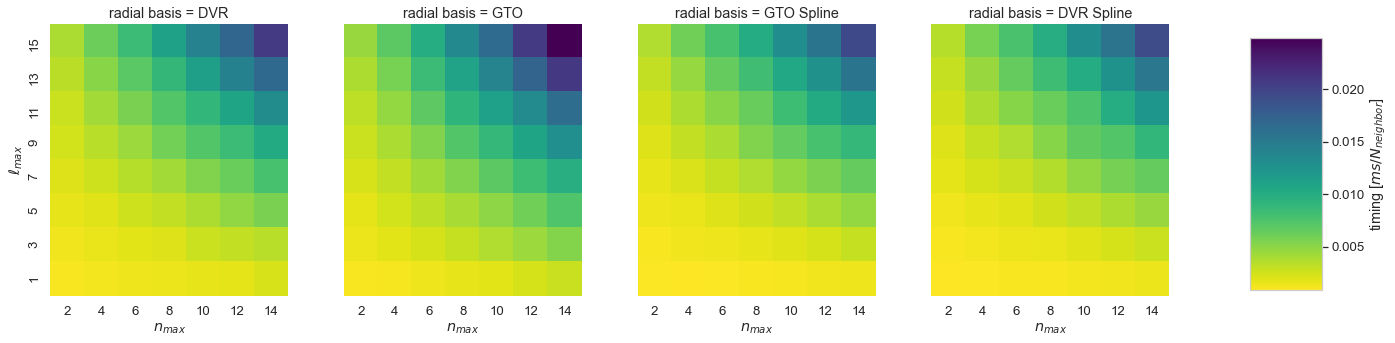

methane_liquid True
0.007896082190240612 0.6756910755846639


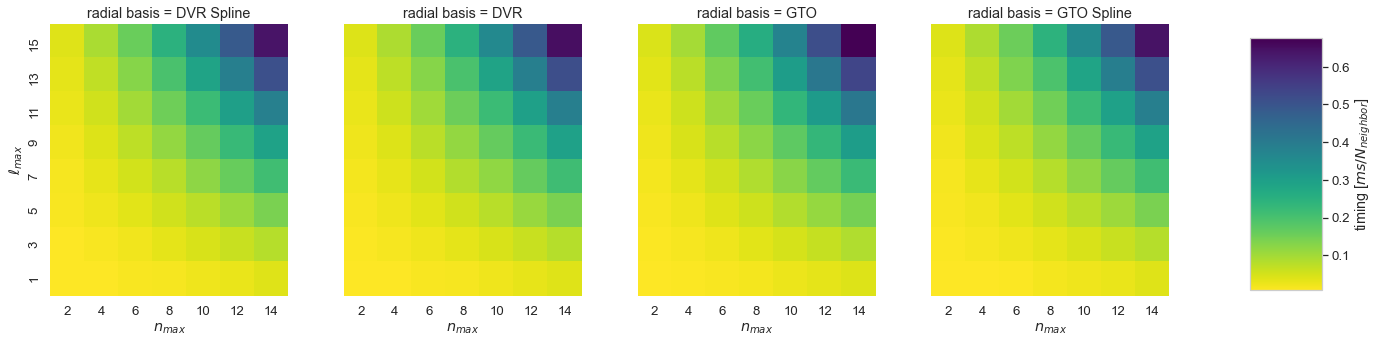

molecular_crystals False
0.0007871850723830736 0.03094695422605791


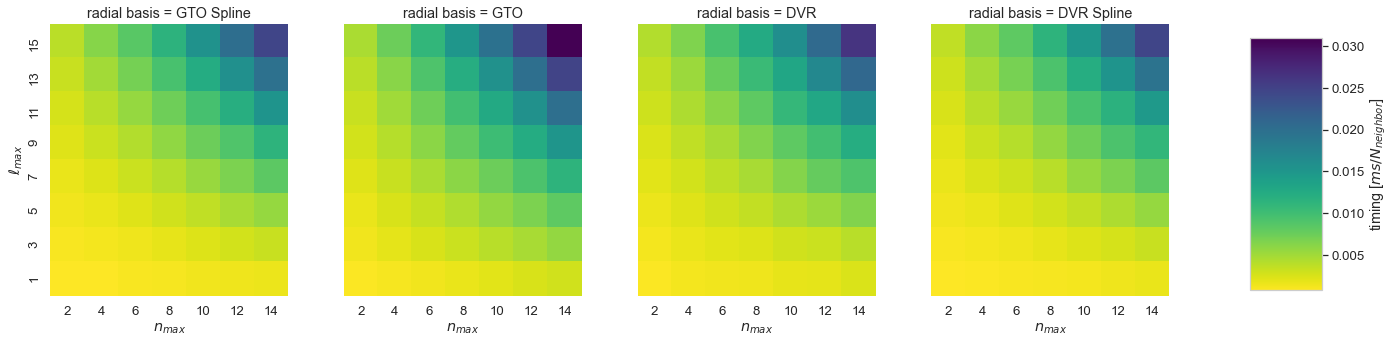

molecular_crystals True
0.015386871152561247 1.1643263787917595


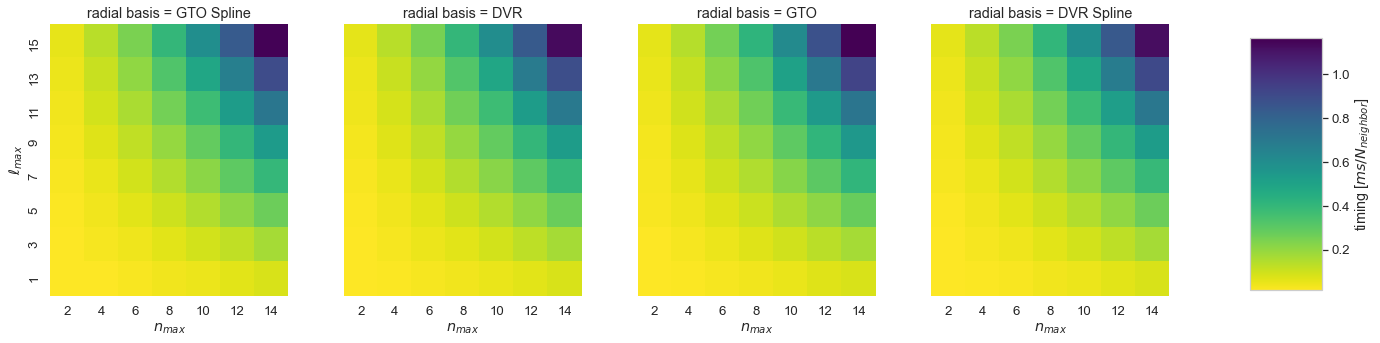

qm9 False
0.0011394771685393258 0.053173030714606745


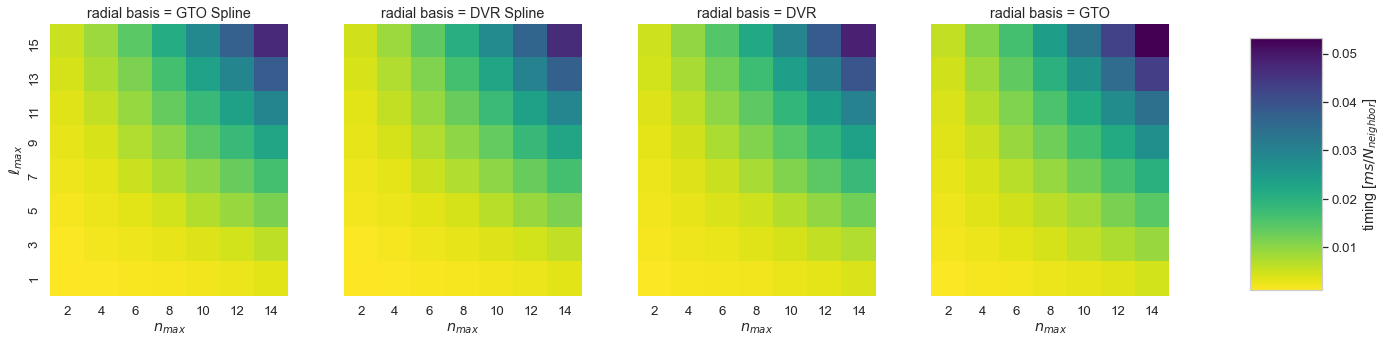

qm9 True
0.017166985730337078 1.2229245460224718


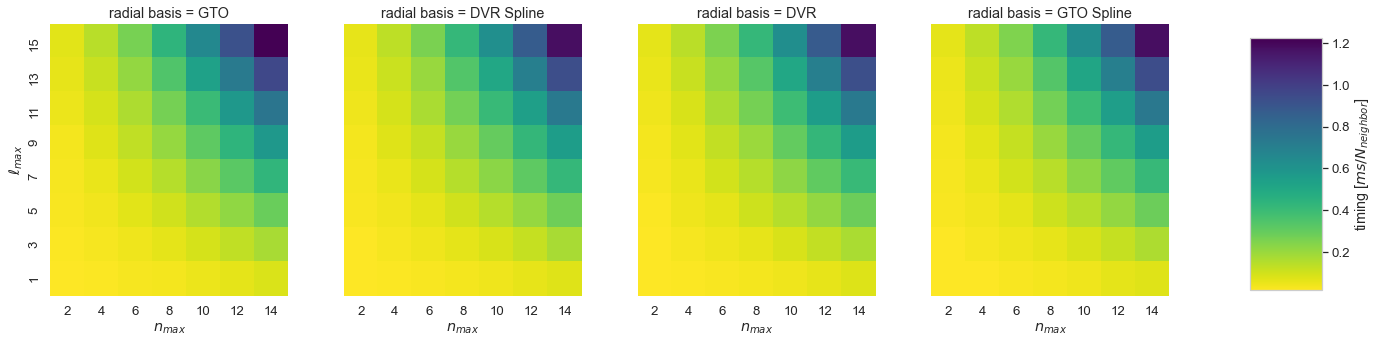

silicon_bulk False
0.0005492496402081257 0.016719285564042955


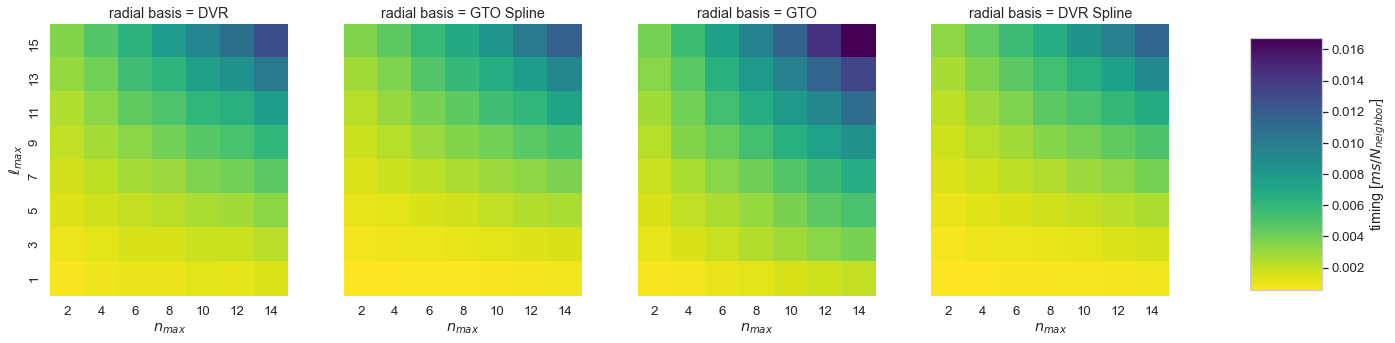

silicon_bulk True
0.004362028573010075 0.42067071743606776


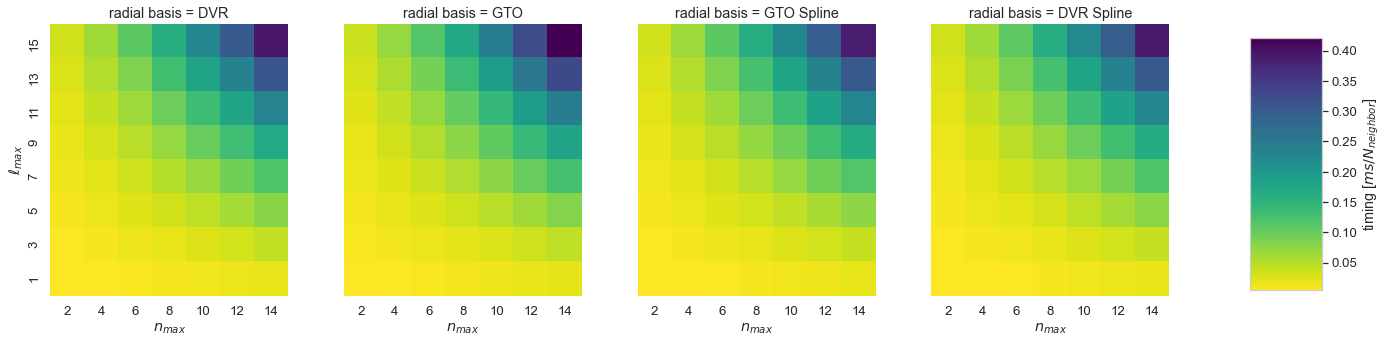

In [65]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
for (Dataset,grad), df_ in df.groupby(['Dataset','compute grad']):
    print(Dataset,grad)
    g = plot_contour(df_,x='$n_{max}$',y='$\ell_{max}$', values='timing [$ms/N_{neighbor}$]', 
                                   col='radial basis',row=None,**kwargs)
    fname = 'si/si-n_vs_l-{}-{}.png'.format(Dataset,grad)
    # plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

methane_liquid False
0.00058939355464358 0.024658810360917476


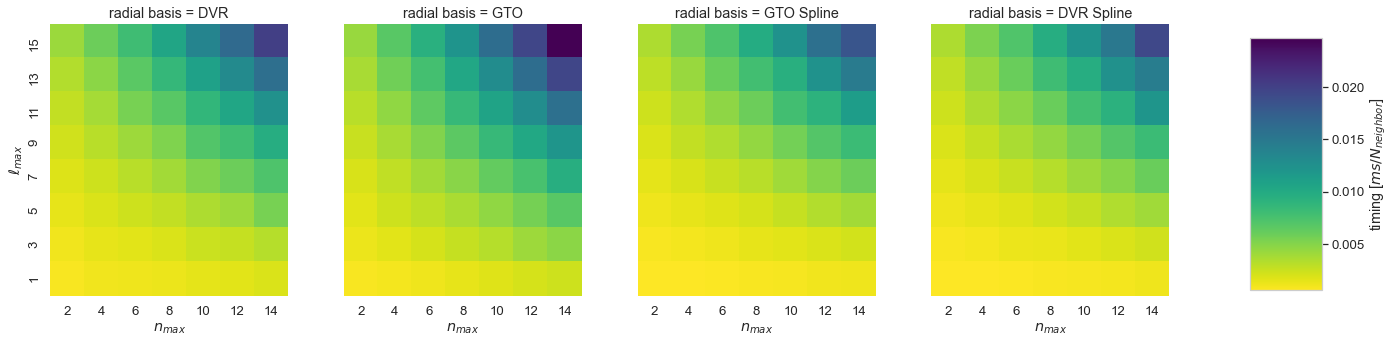

methane_liquid True
0.007555533500112434 0.6562276680627389


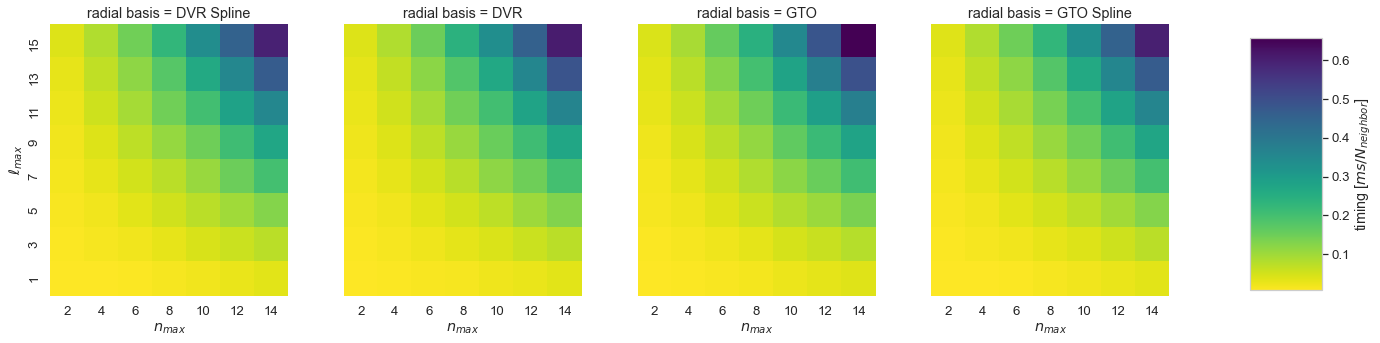

methane_sulfonic False
0.0037201752674145576 0.20682510106965823


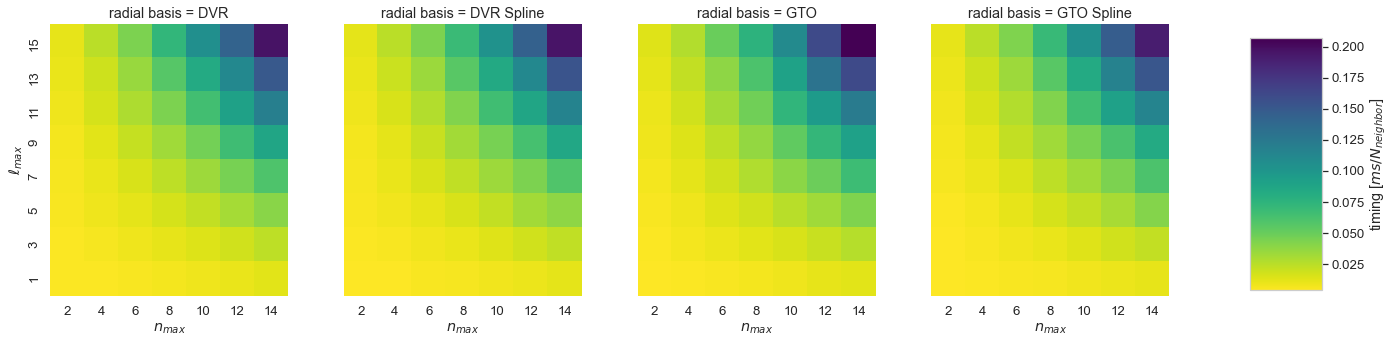

methane_sulfonic True
0.02679965220453953 2.3045206493086354


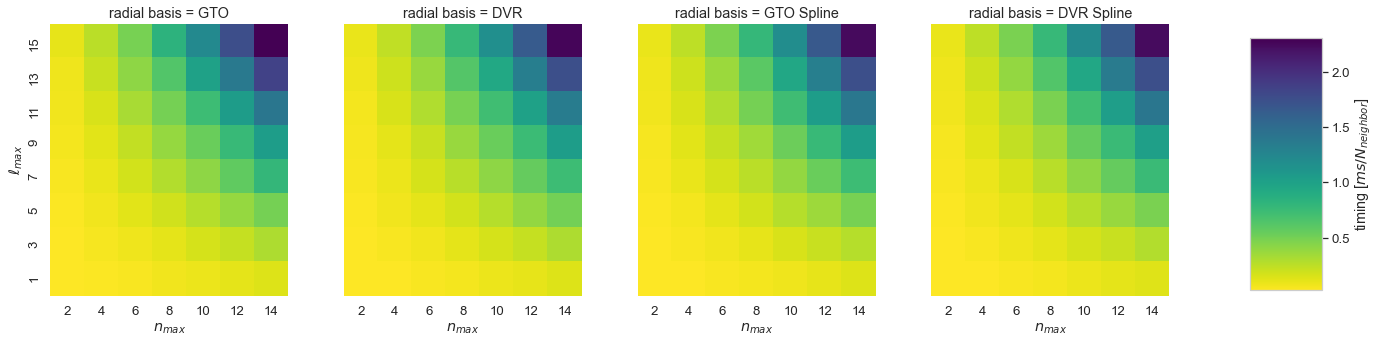

molecular_crystals False
0.0007446384688195991 0.029827523418708247


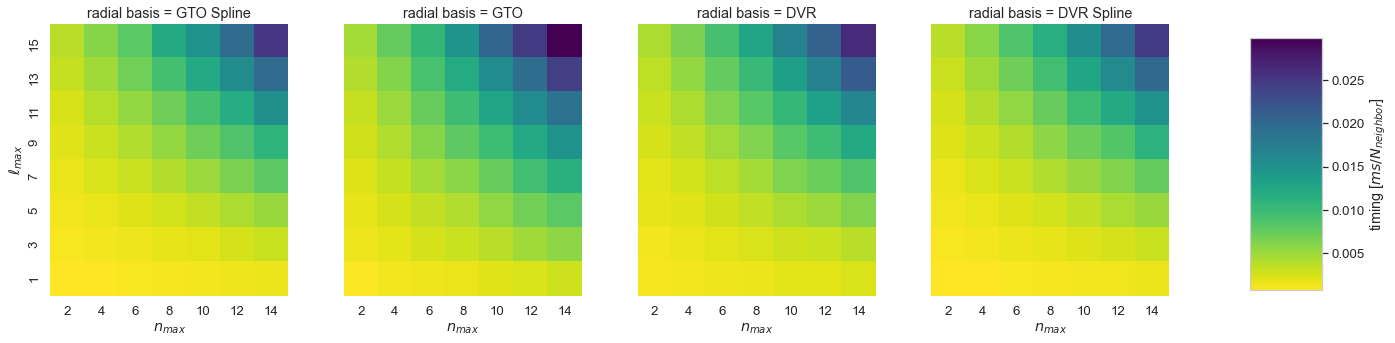

molecular_crystals True
0.016327473170935414 1.0757681230846323


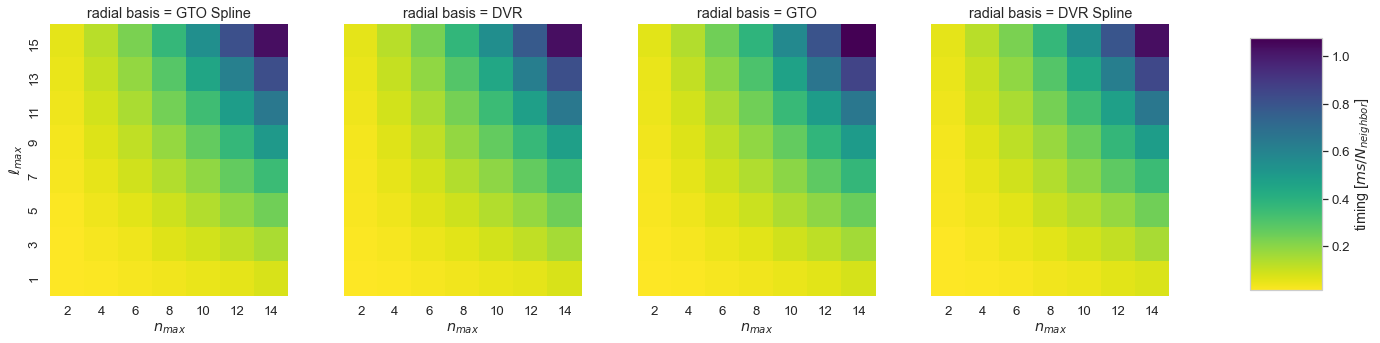

qm9 False
0.0010572038741573032 0.04904823775280899


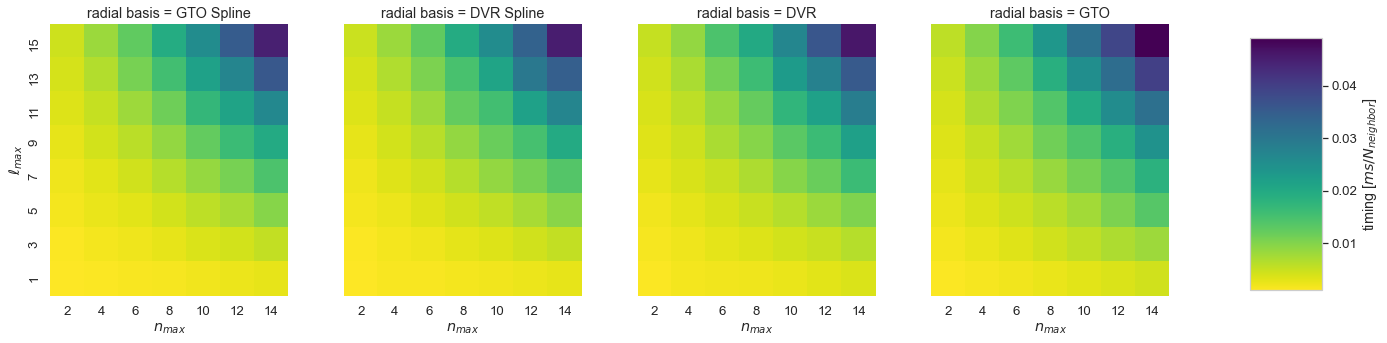

qm9 True
0.019823903433707865 1.176408162777528


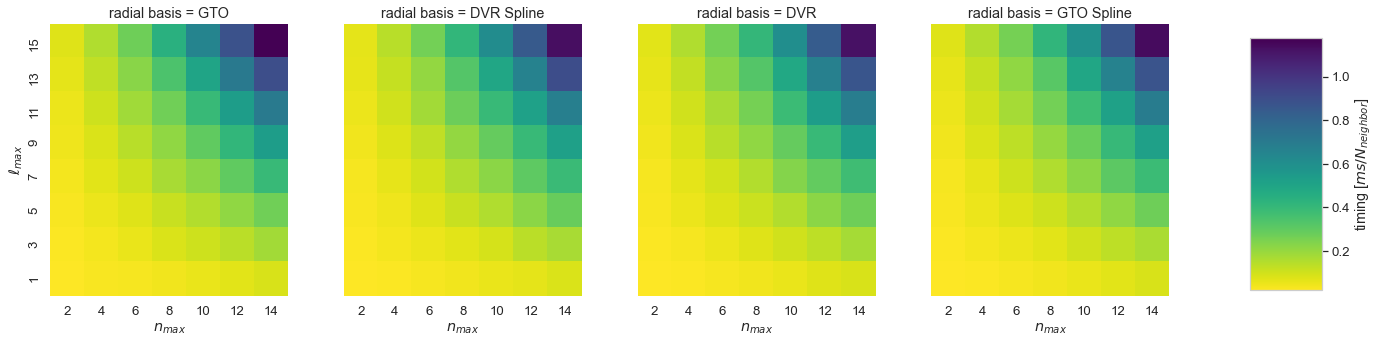

silicon_bulk False
0.0004626138307686631 0.01643086605778811


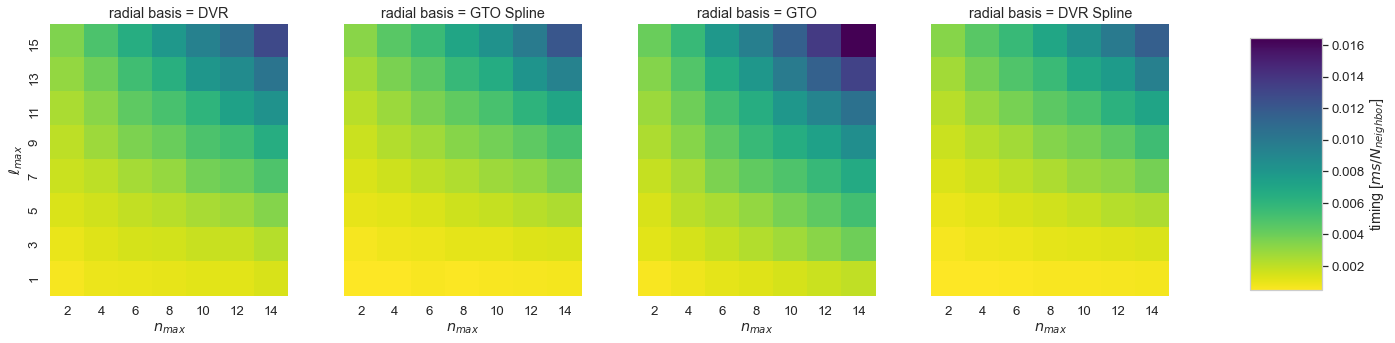

silicon_bulk True
0.004424571268312484 0.40775624197202853


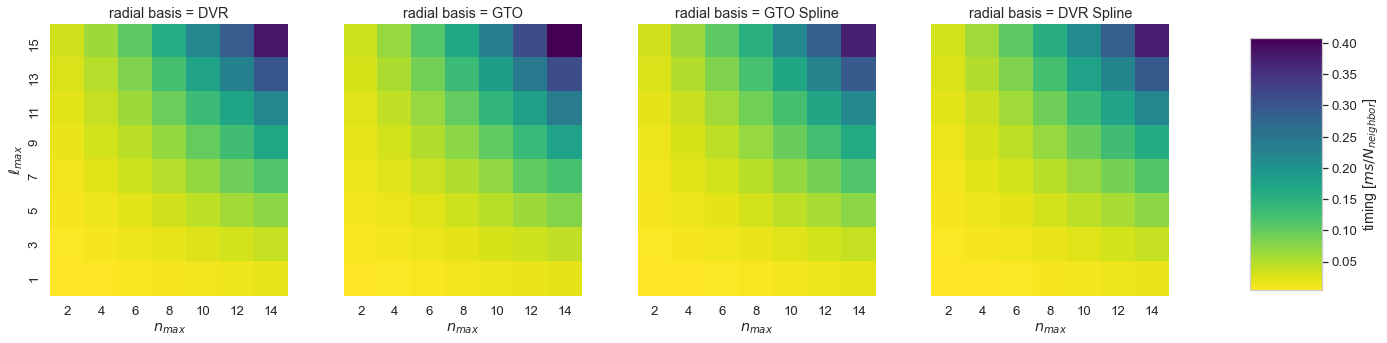

In [68]:
kwargs = dict(sharex=True, sharey=True, margin_titles=True)
for (Dataset,grad), df_ in df.groupby(['Dataset','compute grad']):
    print(Dataset,grad)
    g = plot_contour(df_,x='$n_{max}$',y='$\ell_{max}$', values='timing [$ms/N_{neighbor}$]', 
                                   col='radial basis',row=None,**kwargs)
    fname = 'si/si-n_vs_l-{}-{}.png'.format(Dataset,grad)
    # plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
    plt.show()

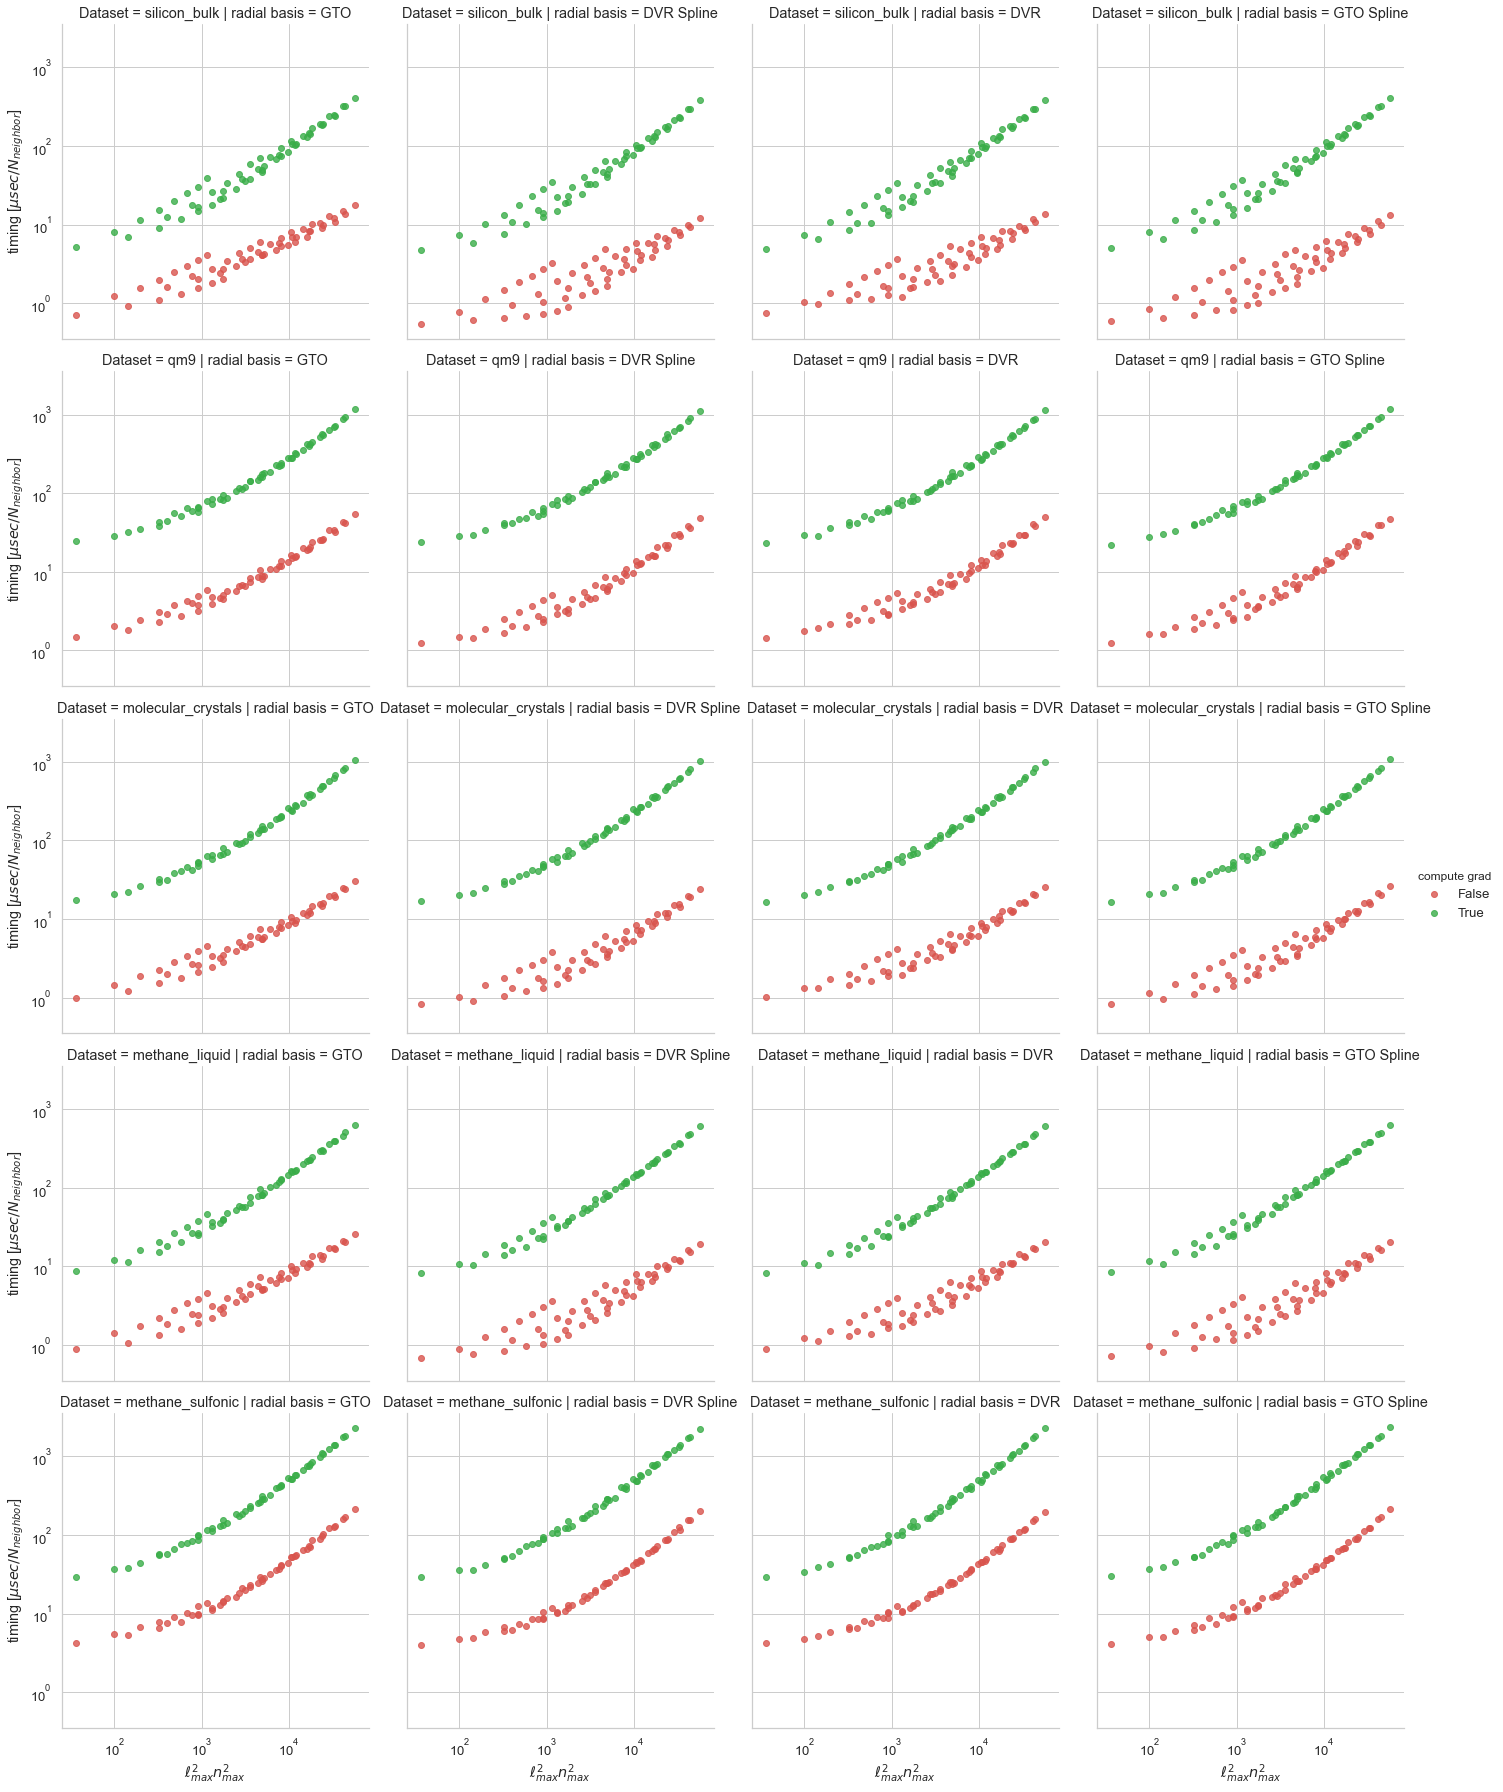

In [85]:
g = sns.lmplot(data=df, x='$\ell_{max}^2n_{max}^2$', y='timing [$\mu sec/N_{neighbor}$]',
               hue='compute grad',line_kws={'linestyle':'--'},legend=True,
                height=5, palette=palette, col='radial basis', row='Dataset', fit_reg=False)   
# title = ' / '.join([k+':'+str(df.iloc[0][k]) for k in title_values])
# plt.title(title,pad=20)
plt.xscale('log')
plt.yscale('log')
fname = 'si/si-coef_scaling.png'.format(dataset,grad)
plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')
# plt.legend()

## sparcification

In [348]:
project = signac.get_project(fn_projects['se'])
results = []

qry = {'representation.interaction_cutoff': {'$eq':4},
       'representation.max_angular': {'$eq':9},
       'representation.max_radial': {'$eq':10},
       'representation.compute_gradients':{'$eq':True},
       'representation.radial_basis':{'$eq':'GTO'},
       'representation.optimization_args.accuracy': {'$eq':1e-8},
       'nl_type':{'$eq':'Full'},
      }   
for job in project.find_jobs(qry):
    radial_basis = job.sp.representation.radial_basis
    if 'type' in job.sp.representation.optimization_args:
        radial_basis += ' Spline'
        # if 'DVR' in radial_basis and job.sp.representation.optimization_args['range'][0] < 1e-6:
        #     continue
    # if job.sp.name == 'methane_liquid'::
    n_max = job.sp.representation.max_radial
    l_max = job.sp.representation.max_angular+1
    sp_max = len(job.sp.representation.global_species)
    res = {
        'lmax':job.sp.representation.max_angular, 
        'nmax':job.sp.representation.max_radial,
        '$\ell_{max}^2n_{max}$':(l_max+1)**2*n_max,
        'radial basis':radial_basis, 
        'compute grad':job.sp.representation.compute_gradients,
        'Dataset': job.sp.name, 
        '$\sigma$': job.sp.representation.gaussian_sigma_constant,
        'nl_type':job.sp.nl_type
    }
    
    res.update(**job.document)
    res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
    res['timing [$ms/N_{atom}$]'] = 1e3 * res['elapsed_mean'] / res['n_centers']
    res['memory footprint [MiB]'] = res['mem_max']
    results.append(res)
df_se = pd.DataFrame(results)
df_se

lmax  nmax  $\ell_{max}^2n_{max}$ radial basis  compute grad  \
0     9    10                   1210   GTO Spline          True   
1     9    10                   1210   GTO Spline          True   
2     9    10                   1210   GTO Spline          True   
3     9    10                   1210   GTO Spline          True   
4     9    10                   1210   GTO Spline          True   

              Dataset  $\sigma$ nl_type  elapsed_mean  elapsed_std  n_centers  \
0                 qm9       0.3    Full      4.295119     0.236273       8977   
1    methane_sulfonic       0.3    Full      5.981832     0.351933      42125   
2  molecular_crystals       0.3    Full      4.026418     0.042866       4174   
3        silicon_bulk       0.3    Full      5.234846     0.054190       8508   
4      methane_liquid       0.3    Full      4.190368     0.072288       6750   

   n_neighbors time_unit      mem_max mem_unit  \
0       112120   seconds  3572.980469      MiB   
1       115446   seconds  7915.218750      MiB   
2       113276   seconds  3138.765625      MiB   
3       133980   seconds  3422.679688      MiB   
4       104946   seconds  2885.191406      MiB   

   timing [$\mu sec/N_{neighbor}$]  timing [$ms/N_{atom}$]  \
0                        38.308228                0.478458   
1                        51.814981                0.142002   
2                        35.545202                0.964643   
3                        39.071849                0.615285   
4                        39.928798                0.620795   

   memory footprint [MiB]  
0             3572.980469  
1             7915.218750  
2             3138.765625  
3             3422.679688  
4             2885.191406

In [349]:
def query(qry):
    # project = signac.get_project(fn_projects['si'])
    project = signac.get_project(fn_projects['si'])
    data = []
    for job in project.find_jobs(qry):
        aa = {}
        aa['name'] = job.sp.name
        aa['$n_{max}$'] = job.sp.representation.max_radial
        aa['$\ell_{max}$'] = job.sp.representation.max_angular
        aa['NL'] = job.sp.nl_type
        aa['grad'] = job.sp.representation.compute_gradients
        aa['normalize'] = job.sp.representation.normalize
        aa['timing [$\mu$s/neighbor]'] = job.document.elapsed_mean / job.document.n_neighbors *1e6
        aa['error [$\mu$s/neighbor]'] = job.document.elapsed_std / job.document.n_neighbors *1e6
        aa['timing [ms/at]'] = job.document.elapsed_mean / job.document.n_centers *1000
        aa['error [ms/at]'] = job.document.elapsed_std / job.document.n_centers *1000
        aa['n_features'] = job.document.n_features
        aa['n_neighbors'] = job.document.n_neighbors
        aa['n_centers'] = job.document.n_centers
        aa['elapsed_mean'] = job.document.elapsed_mean
        data.append(aa)
    df = pd.DataFrame(data)
    df1 = df.sort_values('n_features')
    return df1

def plot(df, x, y, err , row, col, hue, **kwargs):
    g = sns.FacetGrid(df, col=col, row=row, hue=hue, height=5, **kwargs)
    g.map(plt.errorbar, x, y, err, marker="o", linestyle='--')
    plt.legend(title=hue,loc='upper right', bbox_to_anchor=(1.25, 1))
    return g

In [341]:
names = [
    'qm9',
    'molecular_crystals',
    'silicon_bulk',
    'methane_liquid',
    'methane_sulfonic',
]
nl_types = ['Half', 'Full']
normalize = [False, True]
# qrys = []
# qry = {
#     'representation.coefficient_subselection':{'$ne':None},
#        'representation.max_radial':{'$eq':10}, 
#        'representation.compute_gradients':{'$eq':True},
#        'representation.max_angular':{'$eq':9}, 
# }
qry.update(**{'representation.coefficient_subselection':{'$ne':None},})
df = query(qry)    

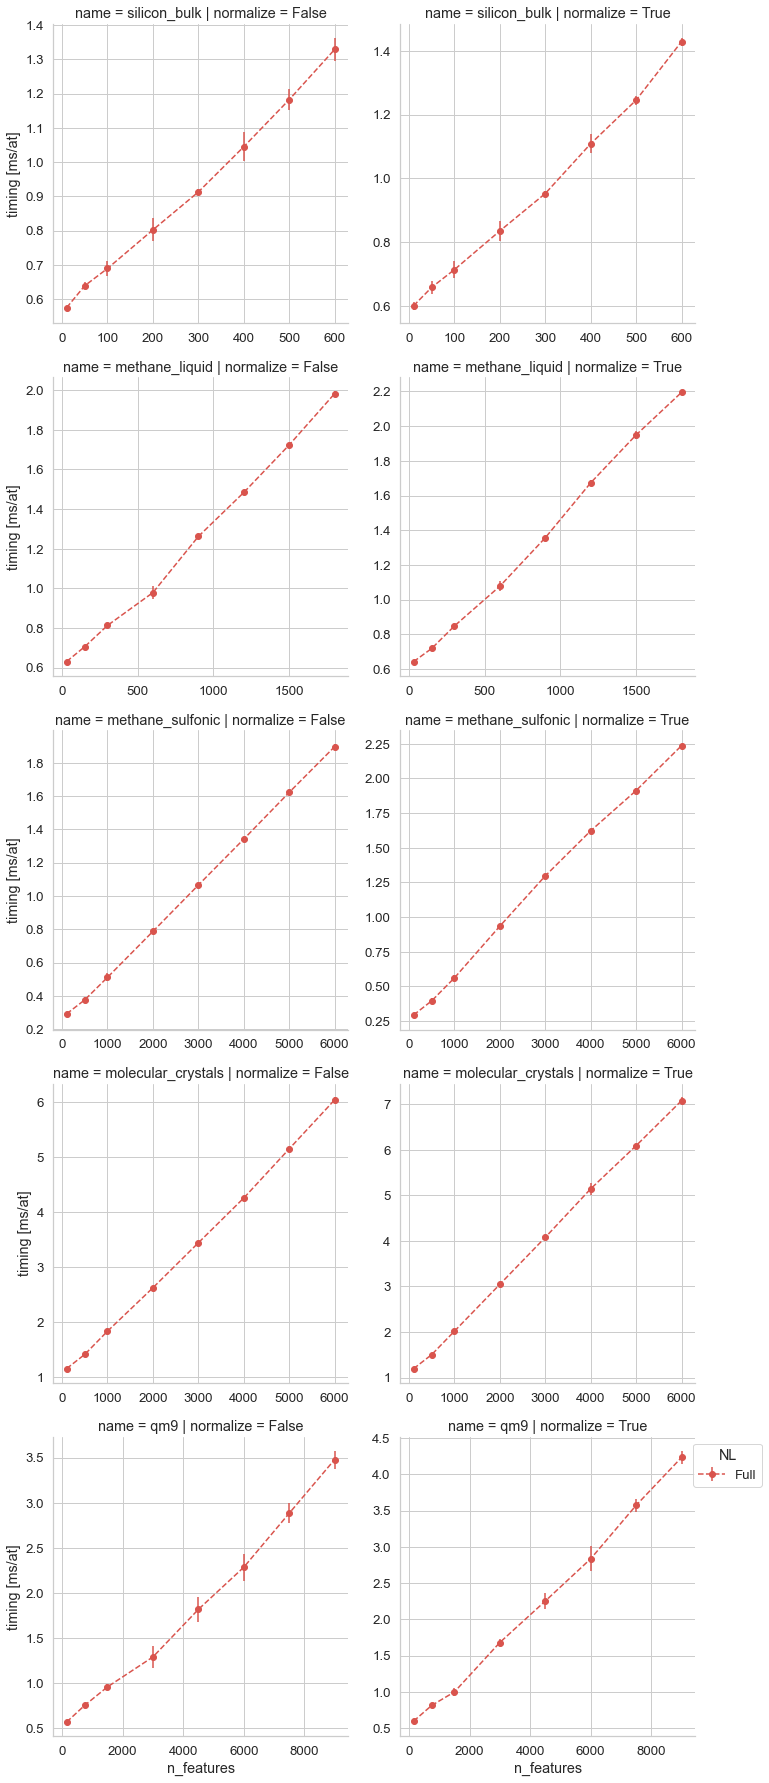

In [190]:
kwargs = dict(sharex=False, sharey=False,legend_out=True,palette=palette)
plot(df, x='n_features', y='timing [ms/at]', err='error [ms/at]',row='name', col='normalize',  hue='NL', **kwargs)
fname = 'si/si-features_sparsification.png'
# plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')

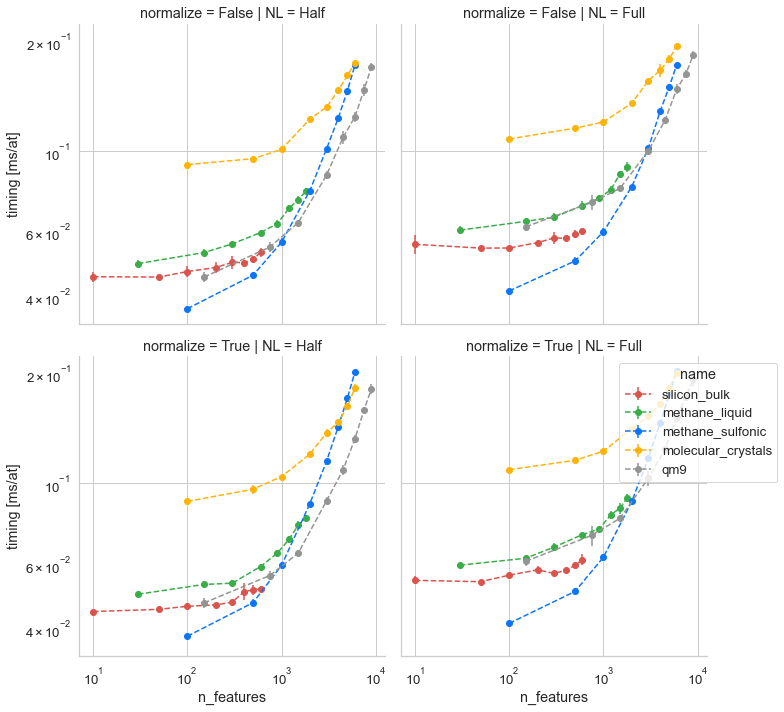

In [82]:
kwargs = dict(sharex=True, sharey=True,legend_out=True,palette=palette)
g = plot(df, x='n_features', y='timing [ms/at]', err='error [ms/at]',row='normalize', col='NL',  hue='name', **kwargs)
for ax in g.axes.flatten():
    # continue
    ax.set_xscale('log')
    ax.set_yscale('log')
fname = 'si/si-features_sparsification-all-log.png'
# plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')

In [191]:
from matplotlib.ticker import FormatStrFormatter,LogFormatterSciNotation,FuncFormatter,ScalarFormatter,LogFormatter,LogFormatterMathtext

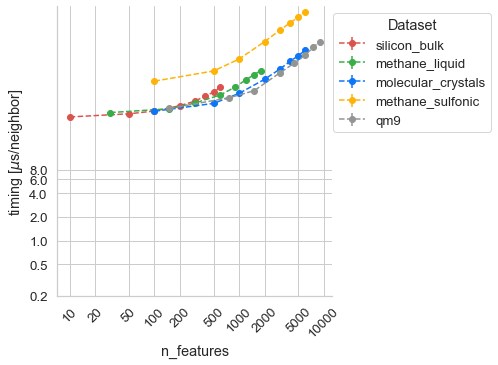

In [147]:
kwargs = dict(sharex=True, sharey=True,legend_out=True,palette=palette)

g = plot(df.query("NL=='Full' and normalize==True"), x='n_features', y='timing [$\mu$s/neighbor]', err='error [$\mu$s/neighbor]',row=None, col=None,  hue='name', **kwargs)



for ax in g.axes.flatten():
    plt.tick_params(axis='y', which='major')
    plt.tick_params(axis='x', which='major')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_yticks([0.2,0.5,1,2,4,6,8])
    ax.set_yticks([0.2,0.5,1,2,4,6,8])
    ax.set_xticks([10,20,50,100,200,500,1000,2000,5000,10000])
    
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    # ax.xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, minor_thresholds=600))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    for item in ax.get_xticklabels():
        item.set_rotation(45)

plt.legend(title='Dataset',loc='upper right', bbox_to_anchor=(1.60, 1))
fname = 'si/si-features_sparsification-all-log-nograd.png'
# plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')

In [250]:
df.columns

Index(['name', '$n_{max}$', '$\ell_{max}$', 'NL', 'grad', 'normalize',
       'timing [$\mu$s/neighbor]', 'error [$\mu$s/neighbor]', 'timing [ms/at]',
       'error [ms/at]', 'n_features', 'n_neighbors', 'n_centers',
       'elapsed_mean', 'timing [$\mu$s/neighbor] (se)',
       'timing [$\mu$s/neighbor] (no se)'],
      dtype='object')

In [167]:
df_se[['Dataset','timing [$\mu sec/N_{neighbor}$]','lmax', 'nmax','compute grad','elapsed_mean', 'elapsed_std',
       'n_centers', 'n_neighbors']]

Dataset  timing [$\mu sec/N_{neighbor}$]  lmax  nmax  \
0                 qm9                        38.308228     9    10   
1    methane_sulfonic                        51.814981     9    10   
2  molecular_crystals                        35.545202     9    10   
3        silicon_bulk                        39.071849     9    10   
4      methane_liquid                        39.928798     9    10   

   compute grad  elapsed_mean  elapsed_std  n_centers  n_neighbors  
0          True      4.295119     0.236273       8977       112120  
1          True      5.981832     0.351933      42125       115446  
2          True      4.026418     0.042866       4174       113276  
3          True      5.234846     0.054190       8508       133980  
4          True      4.190368     0.072288       6750       104946

In [235]:
def ffff(row):
    name = row['name']
    return df_se.query("Dataset=='{}'".format(name))['timing [$\mu sec/N_{neighbor}$]'].values[0]
df['timing [$\mu$s/neighbor] (se)'] = df.apply(ffff,axis=1)
df['timing [$\mu$s/neighbor] (no se)'] = df['timing [$\mu$s/neighbor]']-df['timing [$\mu$s/neighbor] (se)']

In [271]:
df.query("name=='{}' and NL=='Full' and normalize==True".format(name))

name  $n_{max}$  $\ell_{max}$    NL  grad  normalize  \
53  qm9         12            11  Full  True       True   
62  qm9         12            11  Full  True       True   
57  qm9         12            11  Full  True       True   
71  qm9         12            11  Full  True       True   
37  qm9         12            11  Full  True       True   
79  qm9         12            11  Full  True       True   
22  qm9         12            11  Full  True       True   
75  qm9         12            11  Full  True       True   

    timing [$\mu$s/neighbor]  error [$\mu$s/neighbor]  timing [ms/at]  \
53                 65.040853                 5.473178        0.805992   
62                 98.349136                 5.879621        1.218751   
57                141.169092                 7.245260        1.749380   
71                230.608539                14.426758        2.857722   
37                328.290832                 7.796573        4.068210   
79                426.400370                 8.139584        5.283992   
22                519.781774                11.165899        6.441183   
75                617.670157                13.173677        7.654225   

    error [ms/at]  n_features  n_neighbors  n_centers  elapsed_mean  \
53       0.067824         259        44500       3591      2.894318   
62       0.072861        1296        44500       3591      4.376537   
57       0.089784        2592        44500       3591      6.282025   
71       0.178778        5184        44500       3591     10.262080   
37       0.096616        7776        44500       3591     14.608942   
79       0.100866       10368        44500       3591     18.974816   
22       0.138369       12960        44500       3591     23.130289   
75       0.163249       15552        44500       3591     27.486322   

    timing [$\mu$s/neighbor] (se)  timing [$\mu$s/neighbor] (no se)  
53                      62.991421                          2.049432  
62                      62.991421                         35.357715  
57                      62.991421                         78.177671  
71                      62.991421                        167.617118  
37                      62.991421                        265.299411  
79                      62.991421                        363.408949  
22                      62.991421                        456.790353  
75                      62.991421                        554.678737

silicon_bulk


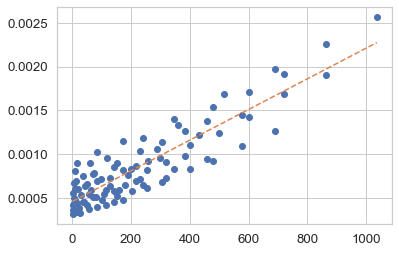

[4.57349734e-04 6.04659114e-16 3.23805939e-11]
methane_liquid


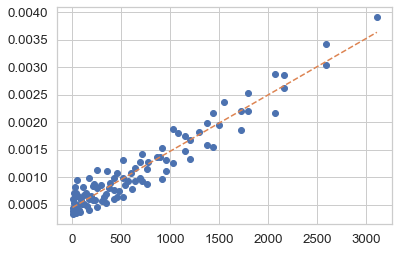

[4.39858798e-04 1.72424029e-16 1.44267885e-11]
methane_sulfonic


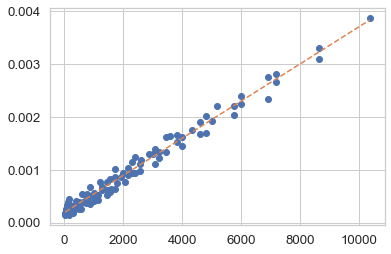

[1.89487547e-04 5.91635699e-15 4.58198085e-11]
molecular_crystals


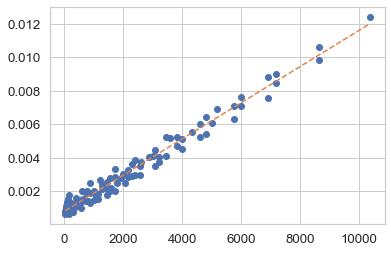

[8.09913252e-04 2.75886074e-16 1.50012794e-11]
qm9


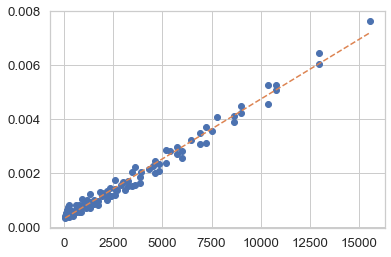

[3.13833271e-04 3.81370001e-16 9.94988373e-12]


No handles with labels found to put in legend.


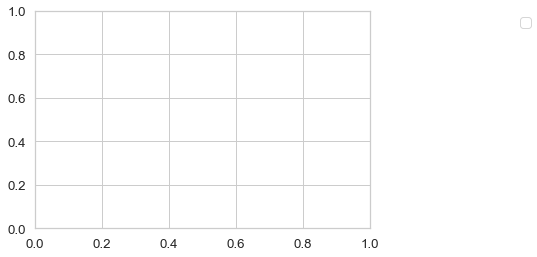

In [345]:
from scipy.sparse.linalg import lsmr
from sklearn import linear_model
from scipy.stats import spearmanr
def get_r2(y_pred, y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    denominator = (
        weight * (y_true - np.average(y_true, axis=0, weights=sample_weight)) ** 2
    ).sum(axis=0, dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)
name = 'silicon_bulk'
def fit(df,name):
    dd = df.query("name=='{}' and NL=='Full' and normalize==True".format(name))
    # y = np.array(dd['elapsed_mean']/dd['n_centers'])
    # A = np.ones((y.shape[0],2))
    # A[:,0] = 1
    # A[:,1] = dd['n_features']
    y = np.array(dd['elapsed_mean']/dd['n_centers'])
    A = np.ones((y.shape[0],3))
    A[:,0] = 1
    A[:,1] = dd['n_features']
    A[:,2] = dd['n_features']*dd['n_neighbors']
    # w, resid, rank, s = np.linalg.lstsq(A,y,rcond=None)
    w, istop, itn, normr = lsmr(A,y,damp=1e-15,atol=1e-13, btol=1e-13,maxiter=1e10)[:4]
    return A,y,w
for name in df['name'].unique():
    print(name)
    A,y,x = fit(df,name)
    # print(spearmanr(np.dot(A,x), y)[0])
    plt.plot(A[:,1],y,'o',label=name)
    plt.plot(A[:,1],np.dot(A,x),'--',label=name)
    # plt.xlim([0,2000])
    # plt.ylim([0,0.004])
    # plt.xscale('log')
    # plt.yscale('log')
    plt.show()
    print(x)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

In [321]:
spearmanr?

In [259]:
name = 'molecular_crystals'
dd = df.query("name=='{}'".format(name))
y = np.array(dd['elapsed_mean']/dd['n_centers'])
A = np.ones((y.shape[0],3))
A[:,0] /= dd['n_centers']
A[:,1] = dd['n_features']
A[:,2] = dd['n_features']*dd['n_neighbors']
x, resid, rank, s = np.linalg.lstsq(A,y,rcond=None)
x

array([4.18947220e+00, 1.85267282e-16, 1.33096015e-11])

In [260]:
name = 'qm9'
dd = df.query("name=='{}'".format(name))
y = np.array(dd['elapsed_mean']/dd['n_centers'])
A = np.ones((y.shape[0],3))
A[:,0] /= dd['n_centers']
A[:,1] = dd['n_features']
A[:,2] = dd['n_features']*dd['n_neighbors']
x, resid, rank, s = np.linalg.lstsq(A,y,rcond=None)
x

array([ 2.16943598e+00, -6.17852933e-04,  1.38934905e-08])

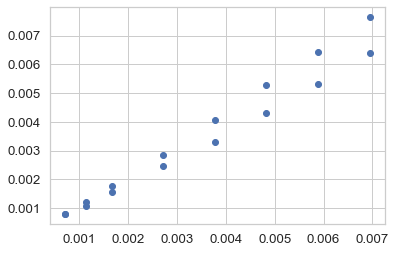

In [263]:
plt.plot(np.dot(A,x),y,'o')

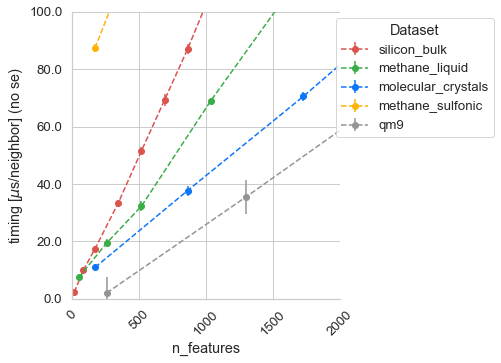

In [239]:
kwargs = dict(sharex=True, sharey=True,legend_out=True,palette=palette)
g = plot(df.query("NL=='Full' and normalize==True"), x='n_features', y='timing [$\mu$s/neighbor] (no se)', err='error [$\mu$s/neighbor]',row=None, col=None,  hue='name', **kwargs)
# plt.axhline(y=dd['timing [$\mu$s/neighbor] se'][0])
for ax in g.axes.flatten():
    plt.tick_params(axis='y', which='major')
    plt.tick_params(axis='x', which='major')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_yticks([0.2,0.5,1,2,4,6,8])
    # ax.set_yticks([30, 50, 100, 200, 300, 500, 1000])
    # ax.set_xticks([10,20,50,100,200,500,1000,2000,5000,10000])
    ax.set_xlim([0,2000])
    ax.set_ylim([0,100])
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    # ax.xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, minor_thresholds=600))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    for item in ax.get_xticklabels():
        item.set_rotation(45)

plt.legend(title='Dataset',loc='upper right', bbox_to_anchor=(1.60, 1))
fname = 'si/si-features_sparsification-all-log-nograd-neigh.png'
# plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')

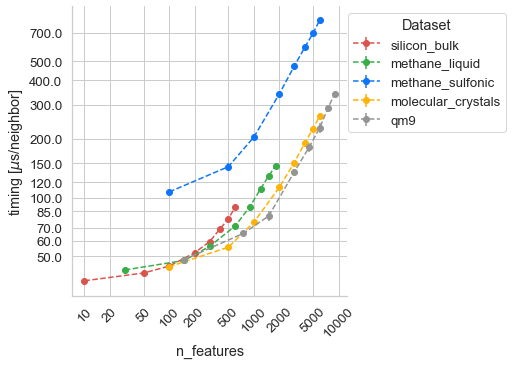

In [91]:
kwargs = dict(sharex=True, sharey=True,legend_out=True,palette=palette)
g = plot(df.query("NL=='Full' and normalize==True"), x='n_features', y='timing [$\mu$s/neighbor]', err='error [$\mu$s/neighbor]',row=None, col=None,  hue='name', **kwargs)
for ax in g.axes.flatten():
    plt.tick_params(axis='y', which='major')
    plt.tick_params(axis='x', which='major')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_yticks([0.2,0.5,1,2,4,6,8])
    ax.set_yticks([50,60,70,85,100,120,150,200,300,400,500,700])
    ax.set_xticks([10,20,50,100,200,500,1000,2000,5000,10000])
    
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    # ax.xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, minor_thresholds=600))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    for item in ax.get_xticklabels():
        item.set_rotation(45)

plt.legend(title='Dataset',loc='upper right', bbox_to_anchor=(1.60, 1))
fname = 'si/si-features_sparsification-all-log-grad-neigh.png'
# plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')

## sparcification

In [377]:
def query(qry):
    # project = signac.get_project(fn_projects['si'])
    project = signac.get_project(fn_projects['si'])
    data = []
    for job in project.find_jobs(qry):
        aa = {}
        aa['name'] = job.sp.name
        aa['$n_{max}$'] = job.sp.representation.max_radial
        aa['$\ell_{max}$'] = job.sp.representation.max_angular
        aa['NL'] = job.sp.nl_type
        aa['grad'] = job.sp.representation.compute_gradients
        aa['normalize'] = job.sp.representation.normalize
        aa['timing [$\mu$s/neighbor]'] = job.document.elapsed_mean / job.document.n_neighbors *1e6
        aa['error [$\mu$s/neighbor]'] = job.document.elapsed_std / job.document.n_neighbors *1e6
        aa['timing [ms/at]'] = job.document.elapsed_mean / job.document.n_centers *1000
        aa['error [ms/at]'] = job.document.elapsed_std / job.document.n_centers *1000
        aa['timing [ms/at] se'] = job.document.elapsed_mean_se / job.document.n_centers *1000
        aa['error [ms/at] se'] = job.document.elapsed_std_se / job.document.n_centers *1000
        aa['n_features'] = job.document.n_features
        aa['n_neighbors'] = job.document.n_neighbors
        aa['n_centers'] = job.document.n_centers
        aa['elapsed_mean'] = job.document.elapsed_mean
        data.append(aa)
    df = pd.DataFrame(data)
    df1 = df.sort_values('n_features')
    return df1

def plot(df, x, y, err , row, col, hue, **kwargs):
    g = sns.FacetGrid(df, col=col, row=row, hue=hue, height=5, **kwargs)
    g.map(plt.errorbar, x, y, err, marker="o", linestyle='--')
    plt.legend(title=hue,loc='upper right', bbox_to_anchor=(1.25, 1))
    return g

In [ ]:
import signac
qry = {'name': 'molecular_crystals',
      }
project = signac.get_project()
data = []
for job in project.find_jobs(qry):
    # job.clear()

In [378]:
names = [
    'qm9',
    'molecular_crystals',
    'silicon_bulk',
    'methane_liquid',
    'methane_sulfonic',
]
nl_types = ['Half', 'Full']
normalize = [False, True]
qry = {'representation.interaction_cutoff': {'$eq':5},
       'representation.max_angular': {'$eq':9},
       'representation.max_radial': {'$eq':10},
       'representation.compute_gradients':{'$eq':True},
       'representation.radial_basis':{'$eq':'GTO'},
       'representation.optimization_args.accuracy': {'$eq':1e-8},
       'nl_type':{'$eq':'Full'},
      }  
qry.update(**{'representation.coefficient_subselection':{'$ne':None},})
df = query(qry)    

In [379]:
df

name  $n_{max}$  $\ell_{max}$    NL  grad  normalize  \
12        silicon_bulk         10             9  Full  True       True   
11      methane_liquid         10             9  Full  True       True   
35        silicon_bulk         10             9  Full  True       True   
39        silicon_bulk         10             9  Full  True       True   
36  molecular_crystals         10             9  Full  True       True   
8     methane_sulfonic         10             9  Full  True       True   
20      methane_liquid         10             9  Full  True       True   
7                  qm9         10             9  Full  True       True   
18        silicon_bulk         10             9  Full  True       True   
22      methane_liquid         10             9  Full  True       True   
38        silicon_bulk         10             9  Full  True       True   
21        silicon_bulk         10             9  Full  True       True   
14    methane_sulfonic         10             9  Full  True       True   
0   molecular_crystals         10             9  Full  True       True   
4         silicon_bulk         10             9  Full  True       True   
3         silicon_bulk         10             9  Full  True       True   
31      methane_liquid         10             9  Full  True       True   
1                  qm9         10             9  Full  True       True   
23      methane_liquid         10             9  Full  True       True   
32  molecular_crystals         10             9  Full  True       True   
29    methane_sulfonic         10             9  Full  True       True   
26      methane_liquid         10             9  Full  True       True   
15                 qm9         10             9  Full  True       True   
17      methane_liquid         10             9  Full  True       True   
5       methane_liquid         10             9  Full  True       True   
9     methane_sulfonic         10             9  Full  True       True   
27  molecular_crystals         10             9  Full  True       True   
19    methane_sulfonic         10             9  Full  True       True   
24  molecular_crystals         10             9  Full  True       True   
13                 qm9         10             9  Full  True       True   
28    methane_sulfonic         10             9  Full  True       True   
6   molecular_crystals         10             9  Full  True       True   
34                 qm9         10             9  Full  True       True   
25    methane_sulfonic         10             9  Full  True       True   
16  molecular_crystals         10             9  Full  True       True   
30  molecular_crystals         10             9  Full  True       True   
2                  qm9         10             9  Full  True       True   
37    methane_sulfonic         10             9  Full  True       True   
10                 qm9         10             9  Full  True       True   
33                 qm9         10             9  Full  True       True   

    timing [$\mu$s/neighbor]  error [$\mu$s/neighbor]  timing [ms/at]  \
12                  3.049281                 0.481375        0.085428   
11                  3.936837                 0.107799        0.132358   
35                  6.155597                 0.514129        0.172455   
39                  9.202783                 0.324420        0.257825   
36                  6.489593                 0.245655        0.362409   
8                   8.554625                 0.424421        0.059959   
20                 10.461846                 0.156675        0.351731   
7                  10.558661                 0.442883        0.162976   
18                 15.470614                 0.944714        0.433424   
22                 18.486100                 0.318173        0.621509   
38                 21.773665                 1.072419        0.610010   
21                 27.255813                 0.485389        0.763597   
14                 26.066320      

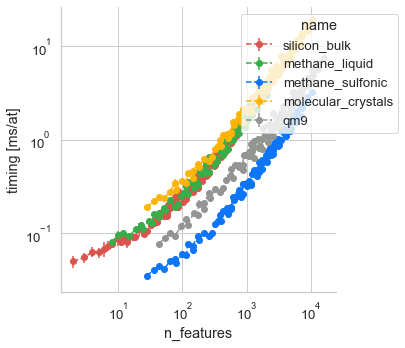

In [369]:
kwargs = dict(sharex=True, sharey=True,legend_out=True,palette=palette)
g = plot(df, x='n_features', y='timing [ms/at]', err='error [ms/at]',row=None, col=None,  hue='name', **kwargs)
for ax in g.axes.flatten():
    # continue
    ax.set_xscale('log')
    ax.set_yscale('log')
fname = 'si/si-features_sparsification-all-log.png'
# plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')

In [370]:
from matplotlib.ticker import FormatStrFormatter,LogFormatterSciNotation,FuncFormatter,ScalarFormatter,LogFormatter,LogFormatterMathtext

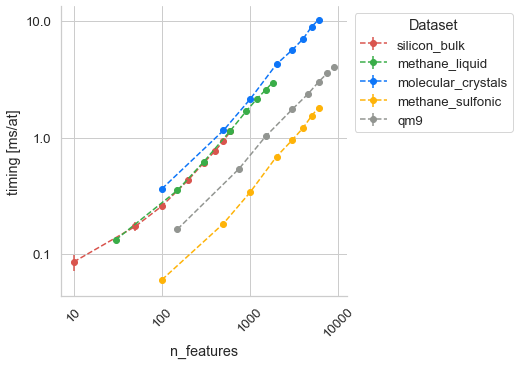

In [383]:
kwargs = dict(sharex=True, sharey=True,legend_out=True,palette=palette)

# g = plot(df, x='n_features', y='timing [$\mu$s/neighbor]', err='error [$\mu$s/neighbor]',row=None, col=None,  hue='name', **kwargs)
g = plot(df, x='n_features', y='timing [ms/at]', err='error [ms/at]',row=None, col=None,  hue='name', **kwargs)



for ax in g.axes.flatten():
    plt.tick_params(axis='y', which='major')
    plt.tick_params(axis='x', which='major')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_yticks([0.2,0.5,1,2,4,6,8])
    # ax.set_xticks([10,20,50,100,200,500,1000,2000,5000,10000])
    # ax.set_yticks([0,0.5,1,2,4,6,50])
    # ax.set_xticks([0,10,20,50,100,200,500,1000,2000,5000,10000])
    
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    # ax.xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, minor_thresholds=600))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    for item in ax.get_xticklabels():
        item.set_rotation(45)

plt.legend(title='Dataset',loc='upper right', bbox_to_anchor=(1.60, 1))
fname = 'si/si-features_sparsification-all-log-nograd.png'
# plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')

silicon_bulk


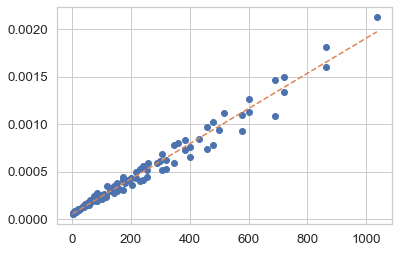

[5.24354578e-05 2.06772609e-16 1.95207768e-11]
methane_liquid


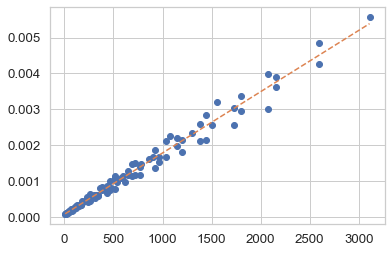

[8.41978229e-05 7.12377610e-17 1.07310497e-11]
methane_sulfonic


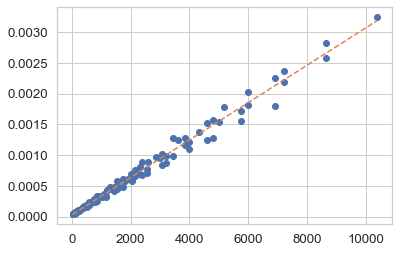

[2.60535693e-05 1.73184614e-16 7.75920416e-12]
molecular_crystals


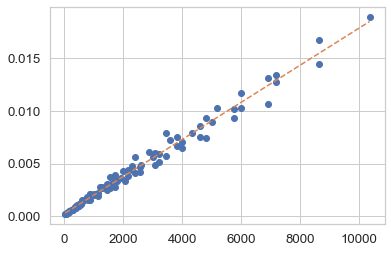

[2.68223678e-04 3.88041388e-17 1.17814972e-11]
qm9


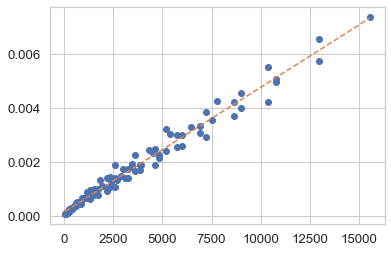

No handles with labels found to put in legend.


[1.70562320e-04 1.47857314e-16 8.30854866e-12]


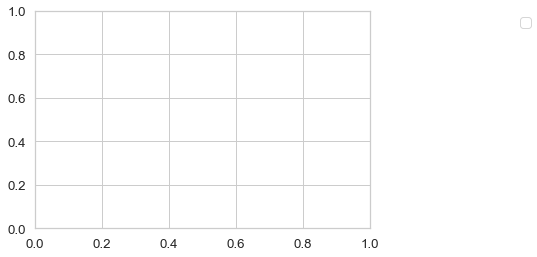

In [372]:
from scipy.sparse.linalg import lsmr
from sklearn import linear_model
from scipy.stats import spearmanr
def get_r2(y_pred, y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    denominator = (
        weight * (y_true - np.average(y_true, axis=0, weights=sample_weight)) ** 2
    ).sum(axis=0, dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)
name = 'silicon_bulk'
def fit(df,name):
    dd = df.query("name=='{}'".format(name))
    # y = np.array(dd['elapsed_mean']/dd['n_centers'])
    # A = np.ones((y.shape[0],2))
    # A[:,0] = 1
    # A[:,1] = dd['n_features']
    y = np.array(dd['elapsed_mean']/dd['n_centers'])
    A = np.ones((y.shape[0],3))
    A[:,0] = 1
    A[:,1] = dd['n_features']
    A[:,2] = dd['n_features']*dd['n_neighbors']
    # w, resid, rank, s = np.linalg.lstsq(A,y,rcond=None)
    w, istop, itn, normr = lsmr(A,y,damp=1e-15,atol=1e-13, btol=1e-13,maxiter=1e10)[:4]
    return A,y,w
for name in df['name'].unique():
    print(name)
    A,y,x = fit(df,name)
    # print(spearmanr(np.dot(A,x), y)[0])
    plt.plot(A[:,1],y,'o',label=name)
    plt.plot(A[:,1],np.dot(A,x),'--',label=name)
    # plt.xlim([0,2000])
    # plt.ylim([0,0.004])
    # plt.xscale('log')
    # plt.yscale('log')
    plt.show()
    print(x)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

In [321]:
spearmanr?

In [259]:
name = 'molecular_crystals'
dd = df.query("name=='{}'".format(name))
y = np.array(dd['elapsed_mean']/dd['n_centers'])
A = np.ones((y.shape[0],3))
A[:,0] /= dd['n_centers']
A[:,1] = dd['n_features']
A[:,2] = dd['n_features']*dd['n_neighbors']
x, resid, rank, s = np.linalg.lstsq(A,y,rcond=None)
x

array([4.18947220e+00, 1.85267282e-16, 1.33096015e-11])

In [260]:
name = 'qm9'
dd = df.query("name=='{}'".format(name))
y = np.array(dd['elapsed_mean']/dd['n_centers'])
A = np.ones((y.shape[0],3))
A[:,0] /= dd['n_centers']
A[:,1] = dd['n_features']
A[:,2] = dd['n_features']*dd['n_neighbors']
x, resid, rank, s = np.linalg.lstsq(A,y,rcond=None)
x

array([ 2.16943598e+00, -6.17852933e-04,  1.38934905e-08])

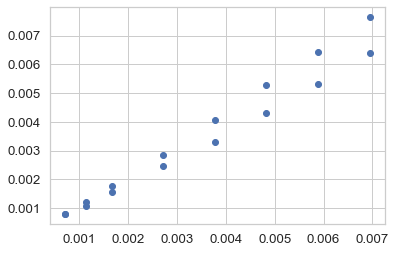

In [263]:
plt.plot(np.dot(A,x),y,'o')

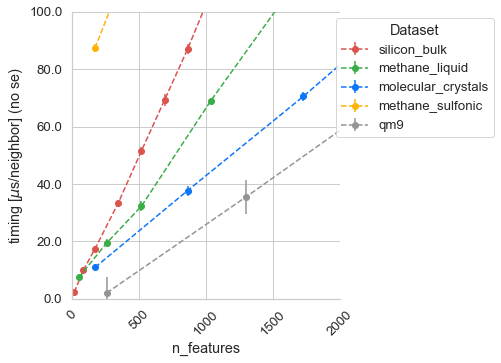

In [239]:
kwargs = dict(sharex=True, sharey=True,legend_out=True,palette=palette)
g = plot(df.query("NL=='Full' and normalize==True"), x='n_features', y='timing [$\mu$s/neighbor] (no se)', err='error [$\mu$s/neighbor]',row=None, col=None,  hue='name', **kwargs)
# plt.axhline(y=dd['timing [$\mu$s/neighbor] se'][0])
for ax in g.axes.flatten():
    plt.tick_params(axis='y', which='major')
    plt.tick_params(axis='x', which='major')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_yticks([0.2,0.5,1,2,4,6,8])
    # ax.set_yticks([30, 50, 100, 200, 300, 500, 1000])
    # ax.set_xticks([10,20,50,100,200,500,1000,2000,5000,10000])
    ax.set_xlim([0,2000])
    ax.set_ylim([0,100])
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    # ax.xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, minor_thresholds=600))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    for item in ax.get_xticklabels():
        item.set_rotation(45)

plt.legend(title='Dataset',loc='upper right', bbox_to_anchor=(1.60, 1))
fname = 'si/si-features_sparsification-all-log-nograd-neigh.png'
# plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')

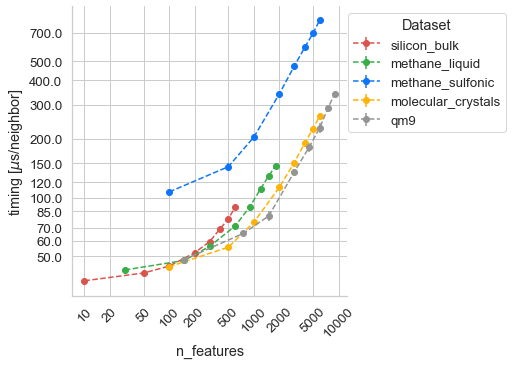

In [91]:
kwargs = dict(sharex=True, sharey=True,legend_out=True,palette=palette)
g = plot(df.query("NL=='Full' and normalize==True"), x='n_features', y='timing [$\mu$s/neighbor]', err='error [$\mu$s/neighbor]',row=None, col=None,  hue='name', **kwargs)
for ax in g.axes.flatten():
    plt.tick_params(axis='y', which='major')
    plt.tick_params(axis='x', which='major')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_yticks([0.2,0.5,1,2,4,6,8])
    ax.set_yticks([50,60,70,85,100,120,150,200,300,400,500,700])
    ax.set_xticks([10,20,50,100,200,500,1000,2000,5000,10000])
    
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    # ax.xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, minor_thresholds=600))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    for item in ax.get_xticklabels():
        item.set_rotation(45)

plt.legend(title='Dataset',loc='upper right', bbox_to_anchor=(1.60, 1))
fname = 'si/si-features_sparsification-all-log-grad-neigh.png'
# plt.savefig(fpfx+fname, dpi=300, bbox_inches='tight')

## NL

In [ ]:
qry = {'representation.interaction_cutoff': {'$eq':5},
       'representation.max_angular': {'$eq':9},
       'representation.max_radial': {'$eq':10},
       'representation.compute_gradients':{'$eq':True},
       'representation.radial_basis':{'$eq':'GTO'},
       'representation.optimization_args.accuracy': {'$eq':1e-8},
       'nl_type':{'$eq':'Full'},
      }  
qry.update(**{'representation.coefficient_subselection':{'$ne':None},})